# Notebook Dedicado a construir modelo Optimizados en cada regimen de energia usando Optuna

Regimes de prueba:

- [2,4] MeV (Hecho) - Optimizado -> Si, pesimos resultados. trial = 300
- [4,6] MeV (hecho) - Optimizado ?
- [2,10] MeV (hecho) - Optimizado -> Si, (esperando resultados). trial = 50
- [2,6] MeV - optimizado (hecho)
- [0.5, 16] MeV- Optimizado (trial = 100)

In [1]:
import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn
import pandas as pd 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
from keras.losses import BinaryCrossentropy
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import optuna
from keras.backend import clear_session

# 1 - Load Data

In [2]:
image_dim = (10, 10)
df_read = pd.read_csv("Data/High Stat/df_5500_10_(0.5_16)_(-5_7).csv")
df_read.describe()

,Unnamed: 0,pixel value,labels,energy (MeV),event radius (mm)
count,2.279520e+07,2.279520e+07,22795200.0,2.279520e+07,2.279520e+07
mean,1.139760e+07,9.774088e-02,0.5,3.784584e+00,4.100289e+03
std,6.580408e+06,1.445464e-01,0.5,1.719554e+00,1.070698e+03
min,0.000000e+00,0.000000e+00,0.0,5.000694e-01,6.875449e+01
25%,5.698800e+06,0.000000e+00,0.0,3.079932e+00,3.428651e+03
50%,1.139760e+07,5.000000e-02,0.5,3.652838e+00,4.338067e+03
75%,1.709640e+07,1.428571e-01,1.0,4.203391e+00,4.976620e+03
max,2.279520e+07,1.000000e+00,1.0,1.354674e+01,5.499991e+03


# 2 - Data Preprocesing

## 2.1 - Extract and Transform Data

In [3]:
df_pixel = df_read['pixel value'].to_numpy()
df_labels = df_read['labels'].to_numpy()
df_energy = df_read['energy (MeV)'].to_numpy()
df_rad = df_read['event radius (mm)'].to_numpy()

#Separate signal from background 
dataset_sig = (df_read[df_read['labels'] == 1]).drop(columns=['Unnamed: 0'])
dataset_bkg = (df_read[df_read['labels'] == 0]).drop(columns=['Unnamed: 0'])

#Separate Features for signal and background
pixel_value_sig = (dataset_sig['pixel value']).to_numpy()
energy_sig = (dataset_sig['energy (MeV)']).to_numpy()
radi_sig = (dataset_sig['event radius (mm)']).to_numpy()
signal_label = (dataset_sig['labels']).to_numpy()

pixel_value_bkg = (dataset_bkg['pixel value']).to_numpy()
energy_bkg = (dataset_bkg['energy (MeV)']).to_numpy()
radi_bkg = (dataset_bkg['event radius (mm)']).to_numpy()
bkg_label = (dataset_bkg['labels']).to_numpy()

## 2.2 - Reestructure Data


1) Agrupar pixeles en eventos,
2) hacer corresponder un unico valor de energia, radio y label

In [4]:
#Reestructure of Labels -> [1,0] = Signal, [0,1] = Bkg
signal_label_0 = signal_label
signal_label_1 = np.zeros(len(signal_label_0))

bkg_label_0 = bkg_label
bkg_label_1 = np.ones(len(bkg_label_0))

signal_label = np.array([signal_label_0,signal_label_1], dtype = np.int8).T
bkg_label = np.array([bkg_label_0, bkg_label_1], dtype = np.int8).T

In [5]:
# Ordenar data set por entradas de eventos: separar pixeles, energia y radios
split_dim = image_dim[0]*image_dim[1]

split_pixel_ev_sig = np.array(np.split(pixel_value_sig, len(pixel_value_sig) // split_dim))
split_pixel_ev_bkg = np.array(np.split(pixel_value_bkg, len(pixel_value_bkg) // split_dim))
split_en_sig = np.array(np.split(energy_sig, len(energy_sig) // split_dim))
split_rad_sig = np.array(np.split(radi_sig, len(radi_sig) // split_dim))

split_pixel_value_bkg = np.array(np.split(pixel_value_bkg, len(pixel_value_bkg) // split_dim))
split_en_bkg = np.array(np.split(energy_bkg, len(energy_bkg) // split_dim))
split_rad_bkg = np.array(np.split(radi_bkg, len(radi_bkg) // split_dim))

split_signal_label = np.array(np.split(signal_label, len(signal_label) // split_dim))
split_bkg_label = np.array(np.split(bkg_label, len(bkg_label) // split_dim))

### Eliminar redundancia dentro de eventos (energia, radio y label)

In [6]:
#deberan coincidir con split_pixel_ev_sig.shape[0]

single_en_ev_sig = []
single_rad_ev_sig = []
single_lab_ev_sig = []

single_en_ev_bkg = []
single_rad_ev_bkg = []
single_lab_ev_bkg = []

dim_en_sig = split_en_sig.shape[0]
dim_rad_sig = split_rad_sig.shape[0]
dim_lab_sig = split_signal_label.shape[0]

dim_en_bkg = split_en_bkg.shape[0]
dim_rad_bkg = split_rad_bkg.shape[0]
dim_lab_bkg = split_bkg_label.shape[0]

for i, j, k in zip(range(dim_en_sig), range(dim_rad_sig), range(dim_lab_sig)):
    single_en_ev_sig.append(split_en_sig[i][0])
    single_rad_ev_sig.append(split_rad_sig[j][0])
    single_lab_ev_sig.append(split_signal_label[k][0])

for i, j, k in zip(range(dim_en_bkg), range(dim_rad_bkg), range(dim_lab_bkg)):
    single_en_ev_bkg.append(split_en_bkg[i][0])
    single_rad_ev_bkg.append(split_rad_bkg[j][0])
    single_lab_ev_bkg.append(split_bkg_label[k][0])

single_en_ev_sig = np.array(single_en_ev_sig)
single_rad_ev_sig = np.array(single_rad_ev_sig)
single_lab_ev_sig = np.array(single_lab_ev_sig)

single_en_ev_bkg = np.array(single_en_ev_bkg)
single_rad_ev_bkg = np.array(single_rad_ev_bkg)
single_lab_ev_bkg = np.array(single_lab_ev_bkg)

## 2.3 - Data Split (Train, Test and Validation)

In [7]:
#Split datasets (train, validation , test)
#pixel_train, pixel_test , label_train, label_test = train_test_split(df_pixel, df_labels, train_size = len_train, test_size = len_test)
len_train = 0.8
len_test = 0.2
len_validation = 0.2 #(20% of train data)


pixel_sig_train, pixel_sig_test, label_sig_train, label_sig_test, energy_sig_train, energy_sig_test, radi_sig_train, radi_sig_test = train_test_split(split_pixel_ev_sig, 
                                                                                                                                                      single_lab_ev_sig, 
                                                                                                                                                      single_en_ev_sig, 
                                                                                                                                                      single_rad_ev_sig,
                                                                                                                                                      train_size = len_train, 
                                                                                                                                                      test_size = len_test)

pixel_bkg_train, pixel_bkg_test, label_bkg_train, label_bkg_test, energy_bkg_train, energy_bkg_test, radi_bkg_train, radi_bkg_test = train_test_split(split_pixel_ev_bkg, 
                                                                                                                                                      single_lab_ev_bkg, 
                                                                                                                                                      single_en_ev_bkg, 
                                                                                                                                                      single_rad_ev_bkg,
                                                                                                                                                      train_size = len_train, 
                                                                                                                                                      test_size = len_test)


## 2.4 - Data Transformation

In [8]:
# A Standard Scalar is used as transform, with a mean_value =  and std_deviation = 1

#This scaler is used in data we dont intend to recover in org. scale
scaler = StandardScaler()  

#Scalers applied to (energy, radius) of testing data, since we want to recover its org. representation
scaler_en_sig = StandardScaler()
scaler_en_bkg = StandardScaler()

scaler_rad_sig = StandardScaler()
scaler_rad_bkg = StandardScaler()

#std(Train):
pixel_sig_train_std = scaler.fit_transform(pixel_sig_train)
pixel_bkg_train_std = scaler.fit_transform(pixel_bkg_train)

energy_sig_train_std = scaler.fit_transform(energy_sig_train.reshape(-1,1)).T[0]
energy_bkg_train_std = scaler.fit_transform(energy_bkg_train.reshape(-1,1)).T[0]

radi_sig_train_std = scaler.fit_transform(radi_sig_train.reshape(-1,1)).T[0]
radi_bkg_train_std = scaler.fit_transform(radi_bkg_train.reshape(-1,1)).T[0]

#std(test):
pixel_sig_test_std = scaler.fit_transform(pixel_sig_test)
pixel_bkg_test_std = scaler.fit_transform(pixel_bkg_test)

energy_sig_test_std = scaler_en_sig.fit_transform(energy_sig_test.reshape(-1,1)).T[0]
energy_bkg_test_std = scaler_en_bkg.fit_transform(energy_bkg_test.reshape(-1,1)).T[0]

radi_sig_test_std = scaler_rad_sig.fit_transform(radi_sig_test.reshape(-1,1)).T[0]
radi_bkg_test_std = scaler_rad_bkg.fit_transform(radi_bkg_test.reshape(-1,1)).T[0]

In [9]:
#Unify datasets

pixel_train = np.concatenate((pixel_sig_train_std, pixel_bkg_train_std))
energy_train = np.concatenate((energy_sig_train_std, energy_bkg_train_std))
radi_train = np.concatenate((radi_sig_train_std, radi_bkg_train_std))
label_train = np.concatenate((label_sig_train, label_bkg_train))

pixel_test = np.concatenate ((pixel_sig_test_std, pixel_bkg_test_std))
energy_test = np.concatenate((energy_sig_test_std, energy_bkg_test_std))
radi_test = np.concatenate((radi_sig_test_std, radi_bkg_test_std))
label_test = np.concatenate((label_sig_test, label_bkg_test))

# 3 - Model Optimization

Hyperparams. to optimize:
- Learning Rate
- Number of neurons
- Number of Hidden layers:
   1) Hidden layers of Image
   4) Hidden layers before dropout layer
   5) Hidden layers after dropout layers
- Dropout Rate

In [10]:
def create_OP_Model(trial):

    #To save memory
    clear_session()
    
    #Optimization of Hyperparameters

    #Image layers suggestions
    n_image_layers = trial.suggest_int('N_Image_layers', 1, 10)

    #Energy layers suggestions
    n_en_layers = trial.suggest_int('N_Energy_layers', 1, 3)

    #Radius Layers suggestions
    n_rad_layers = trial.suggest_int('N_Radius_layers', 1, 3)

    # Nº of neurons suggestion
    #Before Dropout Layers - before concatenate
    n_bdo_layers = trial.suggest_int('N_bdo_layers', 1, 3)

    #After Dropout Layers
    n_ado_layers = trial.suggest_int('N_ado_layers', 1, 3)

    #Learning Rate and Dropout rate
    lr_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2)
    do_rate = trial.suggest_float('Drop_out_rate', 0, 0.7)

    #Number of neurons to be saved in each Optimized Layer
    n_units_image_ly = []
    n_units_en_ly = []
    n_units_rad_ly = []
    n_units_bdo_ly = []
    n_units_ado_ly = []

#-----------------------------------Arquitectura--------------------------------------------------------------------------
    #Input Layers
    #image
    image_dim = (10,10)
    input_im_shape = image_dim[0]*image_dim[1]
    input_image = Input(shape = (input_im_shape,), name = 'image_input')

    #Energy
    input_energy = Input(shape = (1,), name = 'energy_input')

    #Radius
    input_rad = Input(shape = (1,), name = 'radius_input')

    #Hidden Layers for Image (decreasing number of neurons)
    #first Image Hidden Layer
    n_neurons = trial.suggest_int('n_neurons_im_ly_0', 70, 90)
    image_ly = Dense(n_neurons, activation = 'gelu', name = 'im_ly_0')(input_image)
    for i in range(n_image_layers):
        if i == 0:
            n_neurons = trial.suggest_int(f'n_neurons_im_ly_{i+1}', 50, 70)
        else:
            n_neurons = trial.suggest_int(f'n_neurons_im_ly_{i+1}', 50, n_units_image_ly[i-1])  #Garantiza que el numero de neuronas disminuye, o es el mismo, con un minimo de 50!
        n_units_image_ly.append(n_neurons)
            
        image_ly = Dense(n_neurons, activation = 'gelu', name = f'im_ly_{i+1}')(image_ly)

    #Hidden Layers for Energy
    #first energy Hidden Layer
    n_en_neurons = trial.suggest_int('n_neurons_en_ly_0', 50, 70)
    energy_ly = Dense(n_en_neurons, activation = 'gelu', name = 'en_ly_0')(input_energy)
    for i in range(n_en_layers):
        if i == 0:
            n_en_neurons = trial.suggest_int(f'n_neurons_en_ly_{i+1}', 30, 50)
        else:
            n_en_neurons = trial.suggest_int(f'n_neurons_en_ly_{i+1}', 30, n_units_en_ly[i-1])
        n_units_en_ly.append(n_en_neurons)

        energy_ly = Dense(n_en_neurons, activation = 'gelu', name = f'en_ly_{i+1}')(energy_ly)

    #Hidden Layers for Radius
    #first radial hidden layer
    n_rad_neurons = trial.suggest_int('n_neurons_rad_ly_0', 50, 70)
    radial_ly = Dense(n_rad_neurons, activation = 'gelu', name = 'rad_ly_0')(input_rad)
    for i in range(n_rad_layers):
        if i == 0:
            n_rad_neurons = trial.suggest_int(f'n_neurons_rad_ly_{i+1}', 30, 50)
        else:
            n_rad_neurons = trial.suggest_int(f'n_neurons_rad_ly_{i+1}', 30, n_units_rad_ly[i-1])
        n_units_rad_ly.append(n_rad_neurons)

        radial_ly = Dense(n_rad_neurons, activation = 'gelu', name = f'rad_ly_{i+1}')(radial_ly)

    #Concatenate info:
    x = concatenate([image_ly, input_energy, input_rad])

    #first hidden layer after concatenate: Maximum neurons = min(en_units) + min(rad_units) + min(im_units) of last layer
    n_neurons = trial.suggest_int('n_neurons_bdo_ly_0', 30, n_rad_neurons + n_en_neurons + n_neurons)
    x = Dense(n_neurons, activation = 'gelu', name = 'bdo_ly_0')(x)
    for i in range(n_bdo_layers):
        if i == 0:
            n_neurons = trial.suggest_int(f'n_neurons_bdo_ly_{i+1}', 30, n_neurons)
        else:
            n_neurons = trial.suggest_int(f'n_neurons_bdo_ly_{i+1}', 30, n_units_bdo_ly[i-1])
        n_units_bdo_ly.append(n_neurons)
        x = Dense(n_neurons, activation = 'gelu', name = f'bdo_layer{i+1}')(x)

    #Dropout Layer
    x = Dropout(rate = do_rate)(x)

    for i in range(n_ado_layers):
        if i == 0:
            n_neurons = trial.suggest_int(f'n_neurons_ado_ly_{i}', 10, n_neurons)
        else:
            n_neurons = trial.suggest_int(f'n_neurons_ado_ly_{i}', 10, n_units_ado_ly[i-1])
        n_units_ado_ly.append(n_neurons)
        x = Dense(n_neurons, activation = 'gelu', name = f'ado_ly_{i}')(x)
        
    output_layer = Dense(2, activation = 'sigmoid', name = 'nu_predict')(x)

    model = Model(inputs = [input_image, input_energy, input_rad], outputs = output_layer)

    
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr_rate),
                  loss = tf.keras.losses.BinaryCrossentropy(),
                  metrics = ['AUC', 'accuracy'])

    return model

    #-------------------------------------------------------------------------------------------------------------

def objective(trial):

    model = create_OP_Model(trial)
    
    history = model.fit(x = {'image_input': pixel_train, 'energy_input': energy_train, 'radius_input': radi_train}, 
                    y = {'nu_predict':label_train}, 
                    epochs = 100, 
                    batch_size = 100, 
                    validation_split = 0.3,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience = 50, min_delta = 1e-2)],
                    shuffle = True)
    
    X_sig_pred = model.predict([pixel_sig_test_std, energy_sig_test_std, radi_sig_test_std])
    X_bkg_pred = model.predict([pixel_bkg_test_std, energy_bkg_test_std, radi_bkg_test_std])

    # Criterio de Optimización: 1) Disminuir error de predicción (BCE), 2) Aumentar AUC (probar)
    #1)BCE
    #BCE = tf.keras.losses.BinaryCrossentropy()

    #2)AUC
    x_pred = np.concatenate((X_sig_pred, X_bkg_pred))         #Predicted
    x_exp = np.concatenate((label_sig_test, label_bkg_test))  #expected

    # Classification overall Model
    fpr, tpr, thresholds = roc_curve(np.concatenate((x_exp[:,0], x_exp[:,1])), np.concatenate((x_pred[:,0], x_pred[:,1])))
    auc_val = auc(fpr, tpr)

    return auc_val
    
    
    #BCE_sig = BCE(label_sig_test, X_sig_pred)  #(x_real, x_predicted)
    #BCE_bkg = BCE(label_bkg_test, X_bkg_pred)

    # Usar ambos errores de predicción para minimizar el error de predicción (modulo del error)
    #BCE_mod = np.sqrt(BCE_sig**2 + BCE_bkg**2)
    
    #return BCE_mod

In [11]:
study = optuna.create_study(directions = ["maximize"])
study.optimize(objective, n_trials = 100)
best_trial = study.best_trial

print("Best Hyperparms.:", study.best_trial.params) #To see the best 
print("Value: ", best_trial.value)

[I 2024-07-19 23:06:05,469] A new study created in memory with name: no-name-a97a1c9e-5983-4db8-9025-5ecb9432ce47



Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8131 - accuracy: 0.7565 - loss: 0.5192 - val_AUC: 0.6505 - val_accuracy: 0.5832 - val_loss: 0.7420
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9382 - accuracy: 0.8629 - loss: 0.3168 - val_AUC: 0.7591 - val_accuracy: 0.6480 - val_loss: 0.6751
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9516 - accuracy: 0.8788 - loss: 0.2811 - val_AUC: 0.8065 - val_accuracy: 0.7118 - val_loss: 0.6011
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9592 - accuracy: 0.8900 - loss: 0.2579 - val_AUC: 0.8726 - val_accuracy: 0.7676 - val_loss: 0.4706
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9683 - accuracy: 0.9038 - loss: 0.2278 - val_AUC: 0.8345 - val_accuracy: 0.7403 - val_loss: 0.5405
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9783 - accuracy: 0.9217 - loss: 0.1882 - val_AUC: 0.9030 - val_accuracy: 0.8036 - val_loss: 0.4225
Epoch 7/100
1277/1277

[I 2024-07-19 23:09:29,882] Trial 0 finished with value: 0.9871185756854182 and parameters: {'N_Image_layers': 2, 'N_Energy_layers': 1, 'N_Radius_layers': 1, 'N_bdo_layers': 3, 'N_ado_layers': 2, 'learning_rate': 0.0011257943815361781, 'Drop_out_rate': 0.38884255990466504, 'n_neurons_im_ly_0': 84, 'n_neurons_im_ly_1': 61, 'n_neurons_im_ly_2': 53, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 33, 'n_neurons_rad_ly_0': 53, 'n_neurons_rad_ly_1': 33, 'n_neurons_bdo_ly_0': 57, 'n_neurons_bdo_ly_1': 41, 'n_neurons_bdo_ly_2': 33, 'n_neurons_bdo_ly_3': 30, 'n_neurons_ado_ly_0': 19, 'n_neurons_ado_ly_1': 12}. Best is trial 0 with value: 0.9871185756854182.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.6981 - accuracy: 0.6958 - loss: 0.6471 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2187
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.7294 - accuracy: 0.7145 - loss: 0.5945 - val_AUC: 1.2918e-07 - val_accuracy: 1.0967e-04 - val_loss: 1.1490
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.7929 - accuracy: 0.7250 - loss: 0.5547 - val_AUC: 0.2145 - val_accuracy: 0.3073 - val_loss: 1.0431
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8381 - accuracy: 0.7561 - loss: 0.4981 - val_AUC: 0.4066 - val_accuracy: 0.4534 - val_loss: 0.9311
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8614 - accuracy: 0.7755 - loss: 0.4624 - val_AUC: 0.5157 - val_accuracy: 0.5262 - val_loss: 0.8583
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8800 - accuracy: 0.7951 - loss: 0.4336 - val_AUC: 0.5807 - val_accuracy: 0.5670 - val_loss: 0.8123
Epoch 

[I 2024-07-19 23:14:45,143] Trial 1 finished with value: 0.9720349537800288 and parameters: {'N_Image_layers': 1, 'N_Energy_layers': 3, 'N_Radius_layers': 2, 'N_bdo_layers': 2, 'N_ado_layers': 3, 'learning_rate': 5.866521159920458e-05, 'Drop_out_rate': 0.654968079972319, 'n_neurons_im_ly_0': 82, 'n_neurons_im_ly_1': 54, 'n_neurons_en_ly_0': 56, 'n_neurons_en_ly_1': 35, 'n_neurons_en_ly_2': 31, 'n_neurons_en_ly_3': 31, 'n_neurons_rad_ly_0': 63, 'n_neurons_rad_ly_1': 34, 'n_neurons_rad_ly_2': 30, 'n_neurons_bdo_ly_0': 109, 'n_neurons_bdo_ly_1': 108, 'n_neurons_bdo_ly_2': 98, 'n_neurons_ado_ly_0': 32, 'n_neurons_ado_ly_1': 17, 'n_neurons_ado_ly_2': 10}. Best is trial 0 with value: 0.9871185756854182.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8420 - accuracy: 0.7730 - loss: 0.4793 - val_AUC: 0.8295 - val_accuracy: 0.7136 - val_loss: 0.5282
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9371 - accuracy: 0.8587 - loss: 0.3189 - val_AUC: 0.8460 - val_accuracy: 0.7219 - val_loss: 0.4976
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9481 - accuracy: 0.8733 - loss: 0.2905 - val_AUC: 0.7878 - val_accuracy: 0.6640 - val_loss: 0.5958
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9595 - accuracy: 0.8905 - loss: 0.2569 - val_AUC: 0.8871 - val_accuracy: 0.7737 - val_loss: 0.4466
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9748 - accuracy: 0.9177 - loss: 0.2024 - val_AUC: 0.8819 - val_accuracy: 0.7708 - val_loss: 0.5097
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9865 - accuracy: 0.9406 - loss: 0.1477 - val_AUC: 0.9485 - val_accuracy: 0.8533 - val_loss: 0.3298
Epoch 7/100
1277/1277 

[I 2024-07-19 23:18:41,742] Trial 2 finished with value: 0.9890295469084398 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0024625748123421032, 'Drop_out_rate': 0.2118879563836774, 'n_neurons_im_ly_0': 84, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 54, 'n_neurons_im_ly_3': 53, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 36, 'n_neurons_en_ly_2': 34, 'n_neurons_en_ly_3': 33, 'n_neurons_rad_ly_0': 54, 'n_neurons_rad_ly_1': 34, 'n_neurons_bdo_ly_0': 113, 'n_neurons_bdo_ly_1': 113, 'n_neurons_ado_ly_0': 98}. Best is trial 2 with value: 0.9890295469084398.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.8042 - accuracy: 0.7477 - loss: 0.5325 - val_AUC: 0.6915 - val_accuracy: 0.5929 - val_loss: 0.7006
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9114 - accuracy: 0.8322 - loss: 0.3921 - val_AUC: 0.6797 - val_accuracy: 0.5781 - val_loss: 0.7308
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9166 - accuracy: 0.8357 - loss: 0.3641 - val_AUC: 0.7483 - val_accuracy: 0.6275 - val_loss: 0.6433
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9299 - accuracy: 0.8514 - loss: 0.3346 - val_AUC: 0.6118 - val_accuracy: 0.5055 - val_loss: 0.8348
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9332 - accuracy: 0.8545 - loss: 0.3263 - val_AUC: 0.5494 - val_accuracy: 0.5118 - val_loss: 1.0910
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9142 - accuracy: 0.8331 - loss: 0.3683 - val_AUC: 0.7024 - val_accuracy: 0.6125 - val_loss: 0.6725
Epoch 7/100
1277/1277 

[I 2024-07-19 23:25:34,785] Trial 3 finished with value: 0.5000219336725742 and parameters: {'N_Image_layers': 10, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 1, 'N_ado_layers': 3, 'learning_rate': 0.004984859480988991, 'Drop_out_rate': 0.14276211477825673, 'n_neurons_im_ly_0': 81, 'n_neurons_im_ly_1': 60, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_im_ly_10': 50, 'n_neurons_en_ly_0': 60, 'n_neurons_en_ly_1': 31, 'n_neurons_en_ly_2': 30, 'n_neurons_rad_ly_0': 55, 'n_neurons_rad_ly_1': 38, 'n_neurons_rad_ly_2': 31, 'n_neurons_bdo_ly_0': 56, 'n_neurons_bdo_ly_1': 41, 'n_neurons_ado_ly_0': 30, 'n_neurons_ado_ly_1': 22, 'n_neurons_ado_ly_2': 11}. Best is trial 2 with value: 0.9890295469084398.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.8287 - accuracy: 0.7606 - loss: 0.4983 - val_AUC: 0.6830 - val_accuracy: 0.5713 - val_loss: 0.7480
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9377 - accuracy: 0.8596 - loss: 0.3174 - val_AUC: 0.7776 - val_accuracy: 0.6750 - val_loss: 0.6073
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9504 - accuracy: 0.8776 - loss: 0.2840 - val_AUC: 0.8873 - val_accuracy: 0.7802 - val_loss: 0.4438
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9646 - accuracy: 0.8978 - loss: 0.2403 - val_AUC: 0.8879 - val_accuracy: 0.7845 - val_loss: 0.4856
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9792 - accuracy: 0.9245 - loss: 0.1838 - val_AUC: 0.9373 - val_accuracy: 0.8296 - val_loss: 0.3602
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9878 - accuracy: 0.9424 - loss: 0.1404 - val_AUC: 0.9710 - val_accuracy: 0.8961 - val_loss: 0.2358
Epoch 7/100
1277/1277 

[I 2024-07-19 23:28:37,663] Trial 4 finished with value: 0.9835498453947416 and parameters: {'N_Image_layers': 1, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 1, 'N_ado_layers': 3, 'learning_rate': 0.0028025162598098383, 'Drop_out_rate': 0.28997414119304715, 'n_neurons_im_ly_0': 77, 'n_neurons_im_ly_1': 58, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 36, 'n_neurons_en_ly_2': 33, 'n_neurons_rad_ly_0': 68, 'n_neurons_rad_ly_1': 30, 'n_neurons_rad_ly_2': 30, 'n_neurons_bdo_ly_0': 100, 'n_neurons_bdo_ly_1': 93, 'n_neurons_ado_ly_0': 87, 'n_neurons_ado_ly_1': 25, 'n_neurons_ado_ly_2': 16}. Best is trial 2 with value: 0.9890295469084398.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8279 - accuracy: 0.7677 - loss: 0.5000 - val_AUC: 0.7542 - val_accuracy: 0.6573 - val_loss: 0.6279
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9380 - accuracy: 0.8617 - loss: 0.3169 - val_AUC: 0.6583 - val_accuracy: 0.5654 - val_loss: 0.7948
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9487 - accuracy: 0.8752 - loss: 0.2891 - val_AUC: 0.8445 - val_accuracy: 0.7276 - val_loss: 0.5094
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9580 - accuracy: 0.8874 - loss: 0.2617 - val_AUC: 0.7848 - val_accuracy: 0.7013 - val_loss: 0.6124
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9668 - accuracy: 0.9019 - loss: 0.2329 - val_AUC: 0.8287 - val_accuracy: 0.7655 - val_loss: 0.5777
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9785 - accuracy: 0.9231 - loss: 0.1880 - val_AUC: 0.8874 - val_accuracy: 0.8101 - val_loss: 0.4385
Epoch 7/100
1277/1277 

[I 2024-07-19 23:33:12,242] Trial 5 finished with value: 0.9788147103284253 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 1, 'learning_rate': 0.001867470138545462, 'Drop_out_rate': 0.5833957395645416, 'n_neurons_im_ly_0': 90, 'n_neurons_im_ly_1': 66, 'n_neurons_im_ly_2': 56, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 51, 'n_neurons_im_ly_6': 51, 'n_neurons_en_ly_0': 51, 'n_neurons_en_ly_1': 33, 'n_neurons_rad_ly_0': 63, 'n_neurons_rad_ly_1': 35, 'n_neurons_rad_ly_2': 35, 'n_neurons_rad_ly_3': 35, 'n_neurons_bdo_ly_0': 51, 'n_neurons_bdo_ly_1': 37, 'n_neurons_bdo_ly_2': 33, 'n_neurons_bdo_ly_3': 32, 'n_neurons_ado_ly_0': 16}. Best is trial 2 with value: 0.9890295469084398.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7555 - accuracy: 0.7251 - loss: 0.5737 - val_AUC: 0.6456 - val_accuracy: 0.5394 - val_loss: 0.7640
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9090 - accuracy: 0.8298 - loss: 0.3796 - val_AUC: 0.6567 - val_accuracy: 0.5845 - val_loss: 0.7643
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9287 - accuracy: 0.8509 - loss: 0.3386 - val_AUC: 0.6385 - val_accuracy: 0.5607 - val_loss: 0.7505
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9351 - accuracy: 0.8576 - loss: 0.3226 - val_AUC: 0.6524 - val_accuracy: 0.5662 - val_loss: 0.7725
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9435 - accuracy: 0.8664 - loss: 0.3020 - val_AUC: 0.8812 - val_accuracy: 0.7829 - val_loss: 0.4276
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9638 - accuracy: 0.8971 - loss: 0.2436 - val_AUC: 0.8124 - val_accuracy: 0.7578 - val_loss: 0.5825
Epoch 7/100
1277/1277 

[I 2024-07-19 23:38:34,359] Trial 6 finished with value: 0.5897966972642233 and parameters: {'N_Image_layers': 4, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.005864386423365113, 'Drop_out_rate': 0.5586471776156865, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 67, 'n_neurons_im_ly_2': 57, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 38, 'n_neurons_rad_ly_0': 54, 'n_neurons_rad_ly_1': 37, 'n_neurons_rad_ly_2': 34, 'n_neurons_bdo_ly_0': 46, 'n_neurons_bdo_ly_1': 45, 'n_neurons_bdo_ly_2': 44, 'n_neurons_ado_ly_0': 30, 'n_neurons_ado_ly_1': 25}. Best is trial 2 with value: 0.9890295469084398.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8030 - accuracy: 0.7451 - loss: 0.5304 - val_AUC: 0.6628 - val_accuracy: 0.5872 - val_loss: 0.6716
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9152 - accuracy: 0.8371 - loss: 0.3673 - val_AUC: 0.5672 - val_accuracy: 0.4757 - val_loss: 0.8448
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9272 - accuracy: 0.8495 - loss: 0.3408 - val_AUC: 0.7648 - val_accuracy: 0.6381 - val_loss: 0.6452
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9322 - accuracy: 0.8555 - loss: 0.3296 - val_AUC: 0.8161 - val_accuracy: 0.6803 - val_loss: 0.5946
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9405 - accuracy: 0.8643 - loss: 0.3089 - val_AUC: 0.7113 - val_accuracy: 0.5939 - val_loss: 0.7695
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9442 - accuracy: 0.8687 - loss: 0.2986 - val_AUC: 0.6042 - val_accuracy: 0.5132 - val_loss: 0.8302
Epoch 7/100
1277/1277 

[I 2024-07-19 23:42:27,297] Trial 7 finished with value: 0.5848177078867252 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.007852357387963574, 'Drop_out_rate': 0.18254031362208573, 'n_neurons_im_ly_0': 86, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 57, 'n_neurons_en_ly_1': 33, 'n_neurons_en_ly_2': 32, 'n_neurons_rad_ly_0': 53, 'n_neurons_rad_ly_1': 45, 'n_neurons_rad_ly_2': 34, 'n_neurons_bdo_ly_0': 66, 'n_neurons_bdo_ly_1': 50, 'n_neurons_bdo_ly_2': 34, 'n_neurons_ado_ly_0': 28}. Best is trial 2 with value: 0.9890295469084398.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - AUC: 0.7704 - accuracy: 0.7290 - loss: 0.5669 - val_AUC: 0.5236 - val_accuracy: 0.4861 - val_loss: 0.8360
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9029 - accuracy: 0.8239 - loss: 0.3916 - val_AUC: 0.7045 - val_accuracy: 0.6257 - val_loss: 0.6740
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9197 - accuracy: 0.8402 - loss: 0.3583 - val_AUC: 0.1035 - val_accuracy: 0.1368 - val_loss: 1.1066
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8330 - accuracy: 0.7578 - loss: 0.5001 - val_AUC: 0.2767 - val_accuracy: 0.3439 - val_loss: 1.0211
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8835 - accuracy: 0.8054 - loss: 0.4239 - val_AUC: 0.4791 - val_accuracy: 0.4445 - val_loss: 0.9459
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9240 - accuracy: 0.8465 - loss: 0.3480 - val_AUC: 0.1410 - val_accuracy: 0.2099 - val_loss: 1.0815
Epoch 7/100
1277/1277 

[I 2024-07-19 23:46:54,581] Trial 8 finished with value: 0.5 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 2, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.006924191272345464, 'Drop_out_rate': 0.5324337100965155, 'n_neurons_im_ly_0': 74, 'n_neurons_im_ly_1': 64, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 56, 'n_neurons_en_ly_1': 48, 'n_neurons_en_ly_2': 45, 'n_neurons_rad_ly_0': 56, 'n_neurons_rad_ly_1': 48, 'n_neurons_rad_ly_2': 40, 'n_neurons_rad_ly_3': 39, 'n_neurons_bdo_ly_0': 43, 'n_neurons_bdo_ly_1': 38, 'n_neurons_bdo_ly_2': 32, 'n_neurons_ado_ly_0': 31, 'n_neurons_ado_ly_1': 25}. Best is trial 2 with value: 0.9890295469084398.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.7430 - accuracy: 0.7203 - loss: 0.5897 - val_AUC: 0.0854 - val_accuracy: 0.0547 - val_loss: 1.1773
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7457 - accuracy: 0.7218 - loss: 0.5935 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2573
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7133 - accuracy: 0.7127 - loss: 0.5999 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2062
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7149 - accuracy: 0.7156 - loss: 0.5973 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2236
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7155 - accuracy: 0.7159 - loss: 0.5969 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2083
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7159 - accuracy: 0.7162 - loss: 0.5967 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 

[I 2024-07-19 23:50:56,037] Trial 9 finished with value: 0.5 and parameters: {'N_Image_layers': 10, 'N_Energy_layers': 1, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 1, 'learning_rate': 0.008287490385264657, 'Drop_out_rate': 0.04437608908037085, 'n_neurons_im_ly_0': 85, 'n_neurons_im_ly_1': 61, 'n_neurons_im_ly_2': 61, 'n_neurons_im_ly_3': 55, 'n_neurons_im_ly_4': 54, 'n_neurons_im_ly_5': 51, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_im_ly_10': 50, 'n_neurons_en_ly_0': 63, 'n_neurons_en_ly_1': 34, 'n_neurons_rad_ly_0': 69, 'n_neurons_rad_ly_1': 30, 'n_neurons_rad_ly_2': 30, 'n_neurons_bdo_ly_0': 71, 'n_neurons_bdo_ly_1': 53, 'n_neurons_bdo_ly_2': 52, 'n_neurons_bdo_ly_3': 36, 'n_neurons_ado_ly_0': 17}. Best is trial 2 with value: 0.9890295469084398.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8018 - accuracy: 0.7496 - loss: 0.5283 - val_AUC: 0.4851 - val_accuracy: 0.4311 - val_loss: 0.9885
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9216 - accuracy: 0.8428 - loss: 0.3529 - val_AUC: 0.6871 - val_accuracy: 0.5670 - val_loss: 0.7459
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9318 - accuracy: 0.8531 - loss: 0.3295 - val_AUC: 0.7247 - val_accuracy: 0.5969 - val_loss: 0.7432
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9397 - accuracy: 0.8628 - loss: 0.3110 - val_AUC: 0.7003 - val_accuracy: 0.5872 - val_loss: 0.7031
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9435 - accuracy: 0.8673 - loss: 0.3012 - val_AUC: 0.7220 - val_accuracy: 0.5921 - val_loss: 0.6953
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9464 - accuracy: 0.8717 - loss: 0.2930 - val_AUC: 0.7562 - val_accuracy: 0.6254 - val_loss: 0.6799
Epoch 7/100
1277/1277 

[I 2024-07-19 23:56:42,743] Trial 10 finished with value: 0.5894362435842757 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.004060065386975153, 'Drop_out_rate': 0.37813911932941696, 'n_neurons_im_ly_0': 90, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 54, 'n_neurons_im_ly_3': 54, 'n_neurons_im_ly_4': 54, 'n_neurons_im_ly_5': 54, 'n_neurons_im_ly_6': 54, 'n_neurons_im_ly_7': 54, 'n_neurons_im_ly_8': 54, 'n_neurons_en_ly_0': 62, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 36, 'n_neurons_en_ly_3': 35, 'n_neurons_rad_ly_0': 59, 'n_neurons_rad_ly_1': 44, 'n_neurons_bdo_ly_0': 130, 'n_neurons_bdo_ly_1': 130, 'n_neurons_ado_ly_0': 129}. Best is trial 2 with value: 0.9890295469084398.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7537 - accuracy: 0.7189 - loss: 0.5886 - val_AUC: 0.4640 - val_accuracy: 0.4437 - val_loss: 0.8691
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8961 - accuracy: 0.8168 - loss: 0.4050 - val_AUC: 0.6229 - val_accuracy: 0.5468 - val_loss: 0.8061
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9268 - accuracy: 0.8493 - loss: 0.3431 - val_AUC: 0.6759 - val_accuracy: 0.5861 - val_loss: 0.8064
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9400 - accuracy: 0.8636 - loss: 0.3113 - val_AUC: 0.8054 - val_accuracy: 0.6873 - val_loss: 0.5736
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9462 - accuracy: 0.8716 - loss: 0.2956 - val_AUC: 0.8042 - val_accuracy: 0.6831 - val_loss: 0.5837
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9508 - accuracy: 0.8767 - loss: 0.2828 - val_AUC: 0.8319 - val_accuracy: 0.7115 - val_loss: 0.5387
Epoch 7/100
1277/1277 

[I 2024-07-20 00:01:52,204] Trial 11 finished with value: 0.9853522169874253 and parameters: {'N_Image_layers': 4, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 3, 'N_ado_layers': 2, 'learning_rate': 0.0002213558462722618, 'Drop_out_rate': 0.3855820128555649, 'n_neurons_im_ly_0': 85, 'n_neurons_im_ly_1': 56, 'n_neurons_im_ly_2': 54, 'n_neurons_im_ly_3': 53, 'n_neurons_im_ly_4': 52, 'n_neurons_en_ly_0': 70, 'n_neurons_en_ly_1': 38, 'n_neurons_en_ly_2': 35, 'n_neurons_en_ly_3': 33, 'n_neurons_rad_ly_0': 50, 'n_neurons_rad_ly_1': 33, 'n_neurons_bdo_ly_0': 88, 'n_neurons_bdo_ly_1': 66, 'n_neurons_bdo_ly_2': 46, 'n_neurons_bdo_ly_3': 46, 'n_neurons_ado_ly_0': 10, 'n_neurons_ado_ly_1': 10}. Best is trial 2 with value: 0.9890295469084398.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8243 - accuracy: 0.7634 - loss: 0.5021 - val_AUC: 0.8154 - val_accuracy: 0.7037 - val_loss: 0.5621
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9352 - accuracy: 0.8577 - loss: 0.3237 - val_AUC: 0.8297 - val_accuracy: 0.7291 - val_loss: 0.5394
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9485 - accuracy: 0.8740 - loss: 0.2895 - val_AUC: 0.8018 - val_accuracy: 0.6977 - val_loss: 0.5852
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9575 - accuracy: 0.8868 - loss: 0.2633 - val_AUC: 0.8555 - val_accuracy: 0.7493 - val_loss: 0.5095
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9686 - accuracy: 0.9057 - loss: 0.2267 - val_AUC: 0.9123 - val_accuracy: 0.8211 - val_loss: 0.3994
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9825 - accuracy: 0.9303 - loss: 0.1689 - val_AUC: 0.9187 - val_accuracy: 0.8179 - val_loss: 0.4079
Epoch 7/100
1277/1277 

[I 2024-07-20 00:06:07,114] Trial 12 finished with value: 0.987106972853449 and parameters: {'N_Image_layers': 3, 'N_Energy_layers': 1, 'N_Radius_layers': 1, 'N_bdo_layers': 3, 'N_ado_layers': 2, 'learning_rate': 0.0021026482100125234, 'Drop_out_rate': 0.2767042292812932, 'n_neurons_im_ly_0': 78, 'n_neurons_im_ly_1': 70, 'n_neurons_im_ly_2': 67, 'n_neurons_im_ly_3': 63, 'n_neurons_en_ly_0': 70, 'n_neurons_en_ly_1': 30, 'n_neurons_rad_ly_0': 50, 'n_neurons_rad_ly_1': 40, 'n_neurons_bdo_ly_0': 114, 'n_neurons_bdo_ly_1': 83, 'n_neurons_bdo_ly_2': 67, 'n_neurons_bdo_ly_3': 65, 'n_neurons_ado_ly_0': 48, 'n_neurons_ado_ly_1': 42}. Best is trial 2 with value: 0.9890295469084398.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8284 - accuracy: 0.7607 - loss: 0.4999 - val_AUC: 0.7395 - val_accuracy: 0.6494 - val_loss: 0.6221
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9282 - accuracy: 0.8478 - loss: 0.3396 - val_AUC: 0.7517 - val_accuracy: 0.6569 - val_loss: 0.6750
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9430 - accuracy: 0.8669 - loss: 0.3040 - val_AUC: 0.7558 - val_accuracy: 0.6658 - val_loss: 0.6483
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9363 - accuracy: 0.8584 - loss: 0.3232 - val_AUC: 0.7817 - val_accuracy: 0.6578 - val_loss: 0.5656
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9266 - accuracy: 0.8494 - loss: 0.3436 - val_AUC: 0.7107 - val_accuracy: 0.6319 - val_loss: 0.6818
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9610 - accuracy: 0.8922 - loss: 0.2525 - val_AUC: 0.8049 - val_accuracy: 0.7013 - val_loss: 0.5801
Epoch 7/100
1277/1277 

[I 2024-07-20 00:11:54,901] Trial 13 finished with value: 0.9968782055721856 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.003300890974913478, 'Drop_out_rate': 0.4502325364288824, 'n_neurons_im_ly_0': 83, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 46, 'n_neurons_en_ly_2': 43, 'n_neurons_en_ly_3': 42, 'n_neurons_rad_ly_0': 58, 'n_neurons_rad_ly_1': 32, 'n_neurons_bdo_ly_0': 34, 'n_neurons_bdo_ly_1': 30, 'n_neurons_ado_ly_0': 22}. Best is trial 13 with value: 0.9968782055721856.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7285 - accuracy: 0.7111 - loss: 0.6072 - val_AUC: 4.3825e-04 - val_accuracy: 2.7418e-04 - val_loss: 1.0870
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.7895 - accuracy: 0.7226 - loss: 0.5599 - val_AUC: 0.1649 - val_accuracy: 0.2296 - val_loss: 1.1396
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8409 - accuracy: 0.7733 - loss: 0.4968 - val_AUC: 0.4643 - val_accuracy: 0.4284 - val_loss: 0.9877
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8945 - accuracy: 0.8225 - loss: 0.4102 - val_AUC: 0.6308 - val_accuracy: 0.5045 - val_loss: 0.8496
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9318 - accuracy: 0.8614 - loss: 0.3333 - val_AUC: 0.8660 - val_accuracy: 0.7172 - val_loss: 0.5123
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9474 - accuracy: 0.8777 - loss: 0.2966 - val_AUC: 0.5028 - val_accuracy: 0.4301 - val_loss: 0.8655
Epoch 7/100
12

[I 2024-07-20 00:15:00,299] Trial 14 finished with value: 0.5 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.009928713896985984, 'Drop_out_rate': 0.46966737234490014, 'n_neurons_im_ly_0': 88, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 46, 'n_neurons_en_ly_2': 43, 'n_neurons_en_ly_3': 42, 'n_neurons_rad_ly_0': 59, 'n_neurons_rad_ly_1': 37, 'n_neurons_bdo_ly_0': 30, 'n_neurons_bdo_ly_1': 30, 'n_neurons_ado_ly_0': 24}. Best is trial 13 with value: 0.9968782055721856.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8343 - accuracy: 0.7698 - loss: 0.4910 - val_AUC: 0.6975 - val_accuracy: 0.5662 - val_loss: 0.6892
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9249 - accuracy: 0.8479 - loss: 0.3453 - val_AUC: 0.6913 - val_accuracy: 0.5813 - val_loss: 0.7757
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9343 - accuracy: 0.8552 - loss: 0.3241 - val_AUC: 0.7961 - val_accuracy: 0.6714 - val_loss: 0.6053
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9445 - accuracy: 0.8680 - loss: 0.2991 - val_AUC: 0.8169 - val_accuracy: 0.7212 - val_loss: 0.6057
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9554 - accuracy: 0.8837 - loss: 0.2694 - val_AUC: 0.8008 - val_accuracy: 0.7102 - val_loss: 0.6411
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9680 - accuracy: 0.9034 - loss: 0.2286 - val_AUC: 0.8738 - val_accuracy: 0.7659 - val_loss: 0.5099
Epoch 7/100
1277/1277 

[I 2024-07-20 00:19:12,774] Trial 15 finished with value: 0.9900116512484636 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0035989286263432966, 'Drop_out_rate': 0.18340135750604747, 'n_neurons_im_ly_0': 79, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 60, 'n_neurons_en_ly_1': 44, 'n_neurons_en_ly_2': 40, 'n_neurons_en_ly_3': 40, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 31, 'n_neurons_bdo_ly_0': 86, 'n_neurons_bdo_ly_1': 63, 'n_neurons_ado_ly_0': 44}. Best is trial 13 with value: 0.9968782055721856.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8426 - accuracy: 0.7752 - loss: 0.4795 - val_AUC: 0.6713 - val_accuracy: 0.5705 - val_loss: 0.7428
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9284 - accuracy: 0.8483 - loss: 0.3383 - val_AUC: 0.7784 - val_accuracy: 0.6750 - val_loss: 0.6037
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9431 - accuracy: 0.8688 - loss: 0.3030 - val_AUC: 0.8040 - val_accuracy: 0.7009 - val_loss: 0.5823
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9544 - accuracy: 0.8824 - loss: 0.2722 - val_AUC: 0.8280 - val_accuracy: 0.7160 - val_loss: 0.5466
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9666 - accuracy: 0.9020 - loss: 0.2336 - val_AUC: 0.8825 - val_accuracy: 0.7536 - val_loss: 0.4636
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9775 - accuracy: 0.9218 - loss: 0.1916 - val_AUC: 0.9482 - val_accuracy: 0.8505 - val_loss: 0.3398
Epoch 7/100
1277/1277 

[I 2024-07-20 00:22:49,289] Trial 16 finished with value: 0.9885540388673915 and parameters: {'N_Image_layers': 4, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.003925474456727351, 'Drop_out_rate': 0.021805084180696543, 'n_neurons_im_ly_0': 78, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_en_ly_0': 59, 'n_neurons_en_ly_1': 44, 'n_neurons_en_ly_2': 40, 'n_neurons_en_ly_3': 40, 'n_neurons_rad_ly_0': 63, 'n_neurons_rad_ly_1': 30, 'n_neurons_bdo_ly_0': 85, 'n_neurons_bdo_ly_1': 66, 'n_neurons_ado_ly_0': 48}. Best is trial 13 with value: 0.9968782055721856.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7893 - accuracy: 0.7436 - loss: 0.5445 - val_AUC: 0.7252 - val_accuracy: 0.5960 - val_loss: 0.6802
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9206 - accuracy: 0.8424 - loss: 0.3549 - val_AUC: 0.7578 - val_accuracy: 0.6136 - val_loss: 0.6200
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9336 - accuracy: 0.8552 - loss: 0.3258 - val_AUC: 0.7551 - val_accuracy: 0.6183 - val_loss: 0.6469
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9396 - accuracy: 0.8615 - loss: 0.3109 - val_AUC: 0.7350 - val_accuracy: 0.5959 - val_loss: 0.6782
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9464 - accuracy: 0.8715 - loss: 0.2928 - val_AUC: 0.7636 - val_accuracy: 0.6298 - val_loss: 0.6655
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9498 - accuracy: 0.8759 - loss: 0.2837 - val_AUC: 0.8299 - val_accuracy: 0.6973 - val_loss: 0.5595
Epoch 7/100
1277/1277 

[I 2024-07-20 00:27:15,386] Trial 17 finished with value: 0.6282114486512211 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0038301549336153136, 'Drop_out_rate': 0.11330205643701122, 'n_neurons_im_ly_0': 74, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 52, 'n_neurons_en_ly_1': 50, 'n_neurons_en_ly_2': 42, 'n_neurons_en_ly_3': 39, 'n_neurons_rad_ly_0': 65, 'n_neurons_rad_ly_1': 41, 'n_neurons_bdo_ly_0': 31, 'n_neurons_bdo_ly_1': 30, 'n_neurons_ado_ly_0': 11}. Best is trial 13 with value: 0.9968782055721856.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8224 - accuracy: 0.7609 - loss: 0.5085 - val_AUC: 0.6473 - val_accuracy: 0.5322 - val_loss: 0.7983
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9171 - accuracy: 0.8381 - loss: 0.3632 - val_AUC: 0.7141 - val_accuracy: 0.5861 - val_loss: 0.6535
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9294 - accuracy: 0.8524 - loss: 0.3368 - val_AUC: 0.7080 - val_accuracy: 0.6185 - val_loss: 0.7327
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9350 - accuracy: 0.8581 - loss: 0.3220 - val_AUC: 0.6809 - val_accuracy: 0.5568 - val_loss: 0.7530
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9395 - accuracy: 0.8624 - loss: 0.3118 - val_AUC: 0.7515 - val_accuracy: 0.6238 - val_loss: 0.6272
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9437 - accuracy: 0.8687 - loss: 0.3004 - val_AUC: 0.7645 - val_accuracy: 0.6328 - val_loss: 0.6293
Epoch 7/100
1277/1277 

[I 2024-07-20 00:32:54,692] Trial 18 finished with value: 0.5 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.0053605927269493045, 'Drop_out_rate': 0.48645457691043964, 'n_neurons_im_ly_0': 80, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 54, 'n_neurons_en_ly_1': 44, 'n_neurons_en_ly_2': 39, 'n_neurons_en_ly_3': 37, 'n_neurons_rad_ly_0': 58, 'n_neurons_rad_ly_1': 32, 'n_neurons_bdo_ly_0': 81, 'n_neurons_bdo_ly_1': 62, 'n_neurons_bdo_ly_2': 58, 'n_neurons_ado_ly_0': 40}. Best is trial 13 with value: 0.9968782055721856.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.8203 - accuracy: 0.7579 - loss: 0.5093 - val_AUC: 0.7143 - val_accuracy: 0.6057 - val_loss: 0.7348
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9224 - accuracy: 0.8433 - loss: 0.3517 - val_AUC: 0.7103 - val_accuracy: 0.6211 - val_loss: 0.7229
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9370 - accuracy: 0.8587 - loss: 0.3187 - val_AUC: 0.7498 - val_accuracy: 0.6357 - val_loss: 0.6902
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9448 - accuracy: 0.8680 - loss: 0.2990 - val_AUC: 0.8278 - val_accuracy: 0.7286 - val_loss: 0.5333
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9528 - accuracy: 0.8809 - loss: 0.2771 - val_AUC: 0.8309 - val_accuracy: 0.7108 - val_loss: 0.5229
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9581 - accuracy: 0.8876 - loss: 0.2618 - val_AUC: 0.8131 - val_accuracy: 0.7034 - val_loss: 0.6268
Epoch 7/100
1277/1277 

[I 2024-07-20 00:39:11,335] Trial 19 finished with value: 0.5 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 3, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0036745782520647115, 'Drop_out_rate': 0.31582622365905183, 'n_neurons_im_ly_0': 75, 'n_neurons_im_ly_1': 58, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 62, 'n_neurons_en_ly_1': 44, 'n_neurons_en_ly_2': 41, 'n_neurons_en_ly_3': 41, 'n_neurons_rad_ly_0': 66, 'n_neurons_rad_ly_1': 50, 'n_neurons_rad_ly_2': 49, 'n_neurons_rad_ly_3': 49, 'n_neurons_bdo_ly_0': 135, 'n_neurons_bdo_ly_1': 80, 'n_neurons_ado_ly_0': 57, 'n_neurons_ado_ly_1': 57}. Best is trial 13 with value: 0.9968782055721856.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8240 - accuracy: 0.7609 - loss: 0.5056 - val_AUC: 0.5530 - val_accuracy: 0.4952 - val_loss: 0.9146
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9222 - accuracy: 0.8424 - loss: 0.3526 - val_AUC: 0.8051 - val_accuracy: 0.6940 - val_loss: 0.5834
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9383 - accuracy: 0.8608 - loss: 0.3157 - val_AUC: 0.7700 - val_accuracy: 0.6577 - val_loss: 0.6510
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9360 - accuracy: 0.8575 - loss: 0.3220 - val_AUC: 0.8308 - val_accuracy: 0.7167 - val_loss: 0.5211
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9450 - accuracy: 0.8677 - loss: 0.2984 - val_AUC: 0.8481 - val_accuracy: 0.7393 - val_loss: 0.5154
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9472 - accuracy: 0.8725 - loss: 0.2924 - val_AUC: 0.9043 - val_accuracy: 0.7893 - val_loss: 0.4169
Epoch 7/100
1277/1277 

[I 2024-07-20 00:42:52,535] Trial 20 finished with value: 0.5903980278141444 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.006269731096390794, 'Drop_out_rate': 0.23984544293516022, 'n_neurons_im_ly_0': 82, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 59, 'n_neurons_en_ly_1': 46, 'n_neurons_en_ly_2': 45, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 36, 'n_neurons_bdo_ly_0': 96, 'n_neurons_bdo_ly_1': 58, 'n_neurons_ado_ly_0': 38}. Best is trial 13 with value: 0.9968782055721856.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8317 - accuracy: 0.7678 - loss: 0.4919 - val_AUC: 0.6030 - val_accuracy: 0.5081 - val_loss: 0.8314
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9254 - accuracy: 0.8459 - loss: 0.3444 - val_AUC: 0.7076 - val_accuracy: 0.5975 - val_loss: 0.6907
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9352 - accuracy: 0.8583 - loss: 0.3215 - val_AUC: 0.7133 - val_accuracy: 0.5761 - val_loss: 0.6991
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9395 - accuracy: 0.8628 - loss: 0.3109 - val_AUC: 0.7751 - val_accuracy: 0.6485 - val_loss: 0.6177
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9442 - accuracy: 0.8682 - loss: 0.2988 - val_AUC: 0.8543 - val_accuracy: 0.7348 - val_loss: 0.5165
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9514 - accuracy: 0.8777 - loss: 0.2806 - val_AUC: 0.8233 - val_accuracy: 0.7160 - val_loss: 0.5756
Epoch 7/100
1277/1277 

[I 2024-07-20 00:48:54,159] Trial 21 finished with value: 0.9863216531305489 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0027582370848793832, 'Drop_out_rate': 0.2120783929224077, 'n_neurons_im_ly_0': 83, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 39, 'n_neurons_en_ly_2': 37, 'n_neurons_en_ly_3': 33, 'n_neurons_rad_ly_0': 57, 'n_neurons_rad_ly_1': 32, 'n_neurons_bdo_ly_0': 75, 'n_neurons_bdo_ly_1': 49, 'n_neurons_ado_ly_0': 23}. Best is trial 13 with value: 0.9968782055721856.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8207 - accuracy: 0.7625 - loss: 0.5040 - val_AUC: 0.6738 - val_accuracy: 0.5820 - val_loss: 0.7449
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9349 - accuracy: 0.8570 - loss: 0.3236 - val_AUC: 0.7706 - val_accuracy: 0.6679 - val_loss: 0.6111
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9482 - accuracy: 0.8727 - loss: 0.2896 - val_AUC: 0.8294 - val_accuracy: 0.7018 - val_loss: 0.5461
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9589 - accuracy: 0.8890 - loss: 0.2590 - val_AUC: 0.8945 - val_accuracy: 0.7748 - val_loss: 0.4483
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9734 - accuracy: 0.9133 - loss: 0.2086 - val_AUC: 0.9478 - val_accuracy: 0.8439 - val_loss: 0.3154
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9873 - accuracy: 0.9431 - loss: 0.1431 - val_AUC: 0.9642 - val_accuracy: 0.8852 - val_loss: 0.2952
Epoch 7/100
1277/1277 

[I 2024-07-20 00:53:01,504] Trial 22 finished with value: 0.9863042171309193 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.002814095372234445, 'Drop_out_rate': 0.09375086709865435, 'n_neurons_im_ly_0': 87, 'n_neurons_im_ly_1': 57, 'n_neurons_im_ly_2': 55, 'n_neurons_im_ly_3': 53, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 51, 'n_neurons_en_ly_0': 68, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 35, 'n_neurons_en_ly_3': 30, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 32, 'n_neurons_bdo_ly_0': 92, 'n_neurons_bdo_ly_1': 77, 'n_neurons_ado_ly_0': 67}. Best is trial 13 with value: 0.9968782055721856.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8416 - accuracy: 0.7736 - loss: 0.4810 - val_AUC: 0.7952 - val_accuracy: 0.6770 - val_loss: 0.5576
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9372 - accuracy: 0.8589 - loss: 0.3184 - val_AUC: 0.7396 - val_accuracy: 0.6367 - val_loss: 0.6577
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9479 - accuracy: 0.8731 - loss: 0.2904 - val_AUC: 0.7321 - val_accuracy: 0.6295 - val_loss: 0.6768
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9536 - accuracy: 0.8804 - loss: 0.2743 - val_AUC: 0.8402 - val_accuracy: 0.7217 - val_loss: 0.5320
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9606 - accuracy: 0.8916 - loss: 0.2530 - val_AUC: 0.9053 - val_accuracy: 0.7975 - val_loss: 0.4188
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9688 - accuracy: 0.9046 - loss: 0.2262 - val_AUC: 0.8678 - val_accuracy: 0.7485 - val_loss: 0.5079
Epoch 7/100
1277/1277 

[I 2024-07-20 00:56:54,678] Trial 23 finished with value: 0.9876093211631098 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0014805638577957202, 'Drop_out_rate': 0.1995515272573113, 'n_neurons_im_ly_0': 80, 'n_neurons_im_ly_1': 53, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 61, 'n_neurons_en_ly_1': 37, 'n_neurons_en_ly_2': 34, 'n_neurons_en_ly_3': 32, 'n_neurons_rad_ly_0': 52, 'n_neurons_rad_ly_1': 39, 'n_neurons_bdo_ly_0': 106, 'n_neurons_bdo_ly_1': 96, 'n_neurons_ado_ly_0': 79}. Best is trial 13 with value: 0.9968782055721856.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.8121 - accuracy: 0.7560 - loss: 0.5195 - val_AUC: 0.6952 - val_accuracy: 0.5642 - val_loss: 0.6774
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9186 - accuracy: 0.8407 - loss: 0.3597 - val_AUC: 0.7244 - val_accuracy: 0.6116 - val_loss: 0.6916
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9292 - accuracy: 0.8518 - loss: 0.3365 - val_AUC: 0.5631 - val_accuracy: 0.4893 - val_loss: 0.8506
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9359 - accuracy: 0.8583 - loss: 0.3202 - val_AUC: 0.7262 - val_accuracy: 0.5965 - val_loss: 0.7060
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9407 - accuracy: 0.8646 - loss: 0.3087 - val_AUC: 0.7320 - val_accuracy: 0.5832 - val_loss: 0.7076
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9447 - accuracy: 0.8686 - loss: 0.2977 - val_AUC: 0.7345 - val_accuracy: 0.6171 - val_loss: 0.7034
Epoch 7/100
1277/1277 

[I 2024-07-20 01:03:08,149] Trial 24 finished with value: 0.8183517200198216 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.004541926657752791, 'Drop_out_rate': 0.4323648107519058, 'n_neurons_im_ly_0': 83, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 69, 'n_neurons_en_ly_1': 50, 'n_neurons_en_ly_2': 48, 'n_neurons_en_ly_3': 48, 'n_neurons_rad_ly_0': 56, 'n_neurons_rad_ly_1': 35, 'n_neurons_bdo_ly_0': 124, 'n_neurons_bdo_ly_1': 123, 'n_neurons_bdo_ly_2': 111, 'n_neurons_ado_ly_0': 107}. Best is trial 13 with value: 0.9968782055721856.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.8227 - accuracy: 0.7622 - loss: 0.5034 - val_AUC: 0.5192 - val_accuracy: 0.4826 - val_loss: 0.9573
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9351 - accuracy: 0.8575 - loss: 0.3238 - val_AUC: 0.7138 - val_accuracy: 0.6188 - val_loss: 0.6953
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9481 - accuracy: 0.8739 - loss: 0.2902 - val_AUC: 0.8132 - val_accuracy: 0.7323 - val_loss: 0.5655
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9549 - accuracy: 0.8819 - loss: 0.2713 - val_AUC: 0.7697 - val_accuracy: 0.6739 - val_loss: 0.6469
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9692 - accuracy: 0.9072 - loss: 0.2242 - val_AUC: 0.9145 - val_accuracy: 0.8208 - val_loss: 0.3783
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9841 - accuracy: 0.9353 - loss: 0.1606 - val_AUC: 0.9569 - val_accuracy: 0.8656 - val_loss: 0.2759
Epoch 7/100
1277/1277 

[I 2024-07-20 01:07:45,880] Trial 25 finished with value: 0.9819581769585766 and parameters: {'N_Image_layers': 3, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0034115137888802286, 'Drop_out_rate': 0.3121963929724366, 'n_neurons_im_ly_0': 79, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 51, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 47, 'n_neurons_en_ly_2': 44, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 31, 'n_neurons_rad_ly_2': 30, 'n_neurons_bdo_ly_0': 64, 'n_neurons_bdo_ly_1': 34, 'n_neurons_ado_ly_0': 20, 'n_neurons_ado_ly_1': 14}. Best is trial 13 with value: 0.9968782055721856.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8180 - accuracy: 0.7577 - loss: 0.5103 - val_AUC: 0.7678 - val_accuracy: 0.6642 - val_loss: 0.6141
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9330 - accuracy: 0.8552 - loss: 0.3287 - val_AUC: 0.6503 - val_accuracy: 0.5650 - val_loss: 0.8225
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9473 - accuracy: 0.8715 - loss: 0.2922 - val_AUC: 0.8357 - val_accuracy: 0.7271 - val_loss: 0.5251
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9569 - accuracy: 0.8853 - loss: 0.2652 - val_AUC: 0.8560 - val_accuracy: 0.7402 - val_loss: 0.4865
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9653 - accuracy: 0.8989 - loss: 0.2381 - val_AUC: 0.8826 - val_accuracy: 0.7738 - val_loss: 0.4615
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9752 - accuracy: 0.9157 - loss: 0.2014 - val_AUC: 0.9061 - val_accuracy: 0.8055 - val_loss: 0.4228
Epoch 7/100
1277/1277 

[I 2024-07-20 01:11:58,198] Trial 26 finished with value: 0.9972007725275018 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.000981365786267006, 'Drop_out_rate': 0.25620294621629014, 'n_neurons_im_ly_0': 76, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 58, 'n_neurons_en_ly_1': 43, 'n_neurons_en_ly_2': 40, 'n_neurons_en_ly_3': 35, 'n_neurons_rad_ly_0': 58, 'n_neurons_rad_ly_1': 35, 'n_neurons_bdo_ly_0': 80, 'n_neurons_bdo_ly_1': 61, 'n_neurons_ado_ly_0': 42}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8021 - accuracy: 0.7474 - loss: 0.5345 - val_AUC: 0.7860 - val_accuracy: 0.6818 - val_loss: 0.5883
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9271 - accuracy: 0.8509 - loss: 0.3435 - val_AUC: 0.7425 - val_accuracy: 0.6478 - val_loss: 0.6785
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9443 - accuracy: 0.8699 - loss: 0.3009 - val_AUC: 0.7373 - val_accuracy: 0.6390 - val_loss: 0.6792
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9508 - accuracy: 0.8768 - loss: 0.2834 - val_AUC: 0.8141 - val_accuracy: 0.7141 - val_loss: 0.5474
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9551 - accuracy: 0.8840 - loss: 0.2705 - val_AUC: 0.7847 - val_accuracy: 0.7070 - val_loss: 0.6269
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9609 - accuracy: 0.8913 - loss: 0.2528 - val_AUC: 0.7826 - val_accuracy: 0.7122 - val_loss: 0.6040
Epoch 7/100
1277/1277 

[I 2024-07-20 01:17:02,431] Trial 27 finished with value: 0.9872407862006587 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.0007242051844297492, 'Drop_out_rate': 0.6843905978296915, 'n_neurons_im_ly_0': 76, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 58, 'n_neurons_en_ly_1': 43, 'n_neurons_en_ly_2': 40, 'n_neurons_en_ly_3': 36, 'n_neurons_rad_ly_0': 59, 'n_neurons_rad_ly_1': 35, 'n_neurons_bdo_ly_0': 79, 'n_neurons_bdo_ly_1': 60, 'n_neurons_bdo_ly_2': 41, 'n_neurons_ado_ly_0': 26}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.8157 - accuracy: 0.7564 - loss: 0.5163 - val_AUC: 0.7507 - val_accuracy: 0.6410 - val_loss: 0.6355
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9272 - accuracy: 0.8482 - loss: 0.3419 - val_AUC: 0.8342 - val_accuracy: 0.7015 - val_loss: 0.5118
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9446 - accuracy: 0.8671 - loss: 0.2997 - val_AUC: 0.8544 - val_accuracy: 0.7342 - val_loss: 0.4984
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9518 - accuracy: 0.8794 - loss: 0.2796 - val_AUC: 0.8464 - val_accuracy: 0.7245 - val_loss: 0.5108
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9579 - accuracy: 0.8878 - loss: 0.2618 - val_AUC: 0.8358 - val_accuracy: 0.7139 - val_loss: 0.5338
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9629 - accuracy: 0.8944 - loss: 0.2462 - val_AUC: 0.8438 - val_accuracy: 0.7235 - val_loss: 0.5446
Epoch 7/100
1277/1277 

[I 2024-07-20 01:22:11,493] Trial 28 finished with value: 0.9843163664419381 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0011030451721430166, 'Drop_out_rate': 0.3379466851808655, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 53, 'n_neurons_en_ly_1': 45, 'n_neurons_en_ly_2': 42, 'n_neurons_rad_ly_0': 65, 'n_neurons_rad_ly_1': 43, 'n_neurons_rad_ly_2': 40, 'n_neurons_bdo_ly_0': 37, 'n_neurons_bdo_ly_1': 31, 'n_neurons_ado_ly_0': 13, 'n_neurons_ado_ly_1': 10}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.8133 - accuracy: 0.7575 - loss: 0.5191 - val_AUC: 0.7164 - val_accuracy: 0.6025 - val_loss: 0.6820
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9275 - accuracy: 0.8493 - loss: 0.3410 - val_AUC: 0.7014 - val_accuracy: 0.5870 - val_loss: 0.7383
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9426 - accuracy: 0.8662 - loss: 0.3051 - val_AUC: 0.8158 - val_accuracy: 0.7092 - val_loss: 0.5579
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9514 - accuracy: 0.8773 - loss: 0.2809 - val_AUC: 0.7935 - val_accuracy: 0.6920 - val_loss: 0.6038
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9569 - accuracy: 0.8869 - loss: 0.2652 - val_AUC: 0.8341 - val_accuracy: 0.7415 - val_loss: 0.5344
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9649 - accuracy: 0.8990 - loss: 0.2394 - val_AUC: 0.8463 - val_accuracy: 0.7424 - val_loss: 0.5778
Epoch 7/100
1277/1277 

[I 2024-07-20 01:27:11,491] Trial 29 finished with value: 0.9837428960629337 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.0014084292920415384, 'Drop_out_rate': 0.4327515362004254, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 53, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 55, 'n_neurons_en_ly_1': 48, 'n_neurons_en_ly_2': 47, 'n_neurons_en_ly_3': 43, 'n_neurons_rad_ly_0': 57, 'n_neurons_rad_ly_1': 33, 'n_neurons_bdo_ly_0': 64, 'n_neurons_bdo_ly_1': 54, 'n_neurons_bdo_ly_2': 38, 'n_neurons_ado_ly_0': 21, 'n_neurons_ado_ly_1': 17}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8392 - accuracy: 0.7730 - loss: 0.4854 - val_AUC: 0.6989 - val_accuracy: 0.6135 - val_loss: 0.7139
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9326 - accuracy: 0.8521 - loss: 0.3295 - val_AUC: 0.7709 - val_accuracy: 0.6657 - val_loss: 0.6097
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9470 - accuracy: 0.8726 - loss: 0.2934 - val_AUC: 0.8656 - val_accuracy: 0.7647 - val_loss: 0.4818
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9580 - accuracy: 0.8880 - loss: 0.2617 - val_AUC: 0.8742 - val_accuracy: 0.7710 - val_loss: 0.4708
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9748 - accuracy: 0.9172 - loss: 0.2027 - val_AUC: 0.9165 - val_accuracy: 0.7968 - val_loss: 0.3979
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9873 - accuracy: 0.9430 - loss: 0.1430 - val_AUC: 0.9446 - val_accuracy: 0.8512 - val_loss: 0.3550
Epoch 7/100
1277/1277 

[I 2024-07-20 01:30:44,466] Trial 30 finished with value: 0.9800473493397237 and parameters: {'N_Image_layers': 3, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.004772934833198206, 'Drop_out_rate': 0.26006523533493886, 'n_neurons_im_ly_0': 76, 'n_neurons_im_ly_1': 63, 'n_neurons_im_ly_2': 58, 'n_neurons_im_ly_3': 57, 'n_neurons_en_ly_0': 60, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 38, 'n_neurons_en_ly_3': 37, 'n_neurons_rad_ly_0': 60, 'n_neurons_rad_ly_1': 31, 'n_neurons_bdo_ly_0': 70, 'n_neurons_bdo_ly_1': 56, 'n_neurons_ado_ly_0': 36}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8404 - accuracy: 0.7734 - loss: 0.4814 - val_AUC: 0.7917 - val_accuracy: 0.6928 - val_loss: 0.6229
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9357 - accuracy: 0.8587 - loss: 0.3222 - val_AUC: 0.7836 - val_accuracy: 0.6781 - val_loss: 0.5937
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9485 - accuracy: 0.8743 - loss: 0.2891 - val_AUC: 0.7782 - val_accuracy: 0.6750 - val_loss: 0.6334
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9594 - accuracy: 0.8886 - loss: 0.2575 - val_AUC: 0.8437 - val_accuracy: 0.7522 - val_loss: 0.5516
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9713 - accuracy: 0.9089 - loss: 0.2166 - val_AUC: 0.8266 - val_accuracy: 0.7223 - val_loss: 0.5990
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9841 - accuracy: 0.9337 - loss: 0.1606 - val_AUC: 0.9145 - val_accuracy: 0.7965 - val_loss: 0.3963
Epoch 7/100
1277/1277 

[I 2024-07-20 01:34:51,066] Trial 31 finished with value: 0.9936396371413905 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.002184787126495312, 'Drop_out_rate': 0.15121831370200023, 'n_neurons_im_ly_0': 84, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 40, 'n_neurons_en_ly_3': 34, 'n_neurons_rad_ly_0': 52, 'n_neurons_rad_ly_1': 34, 'n_neurons_bdo_ly_0': 102, 'n_neurons_bdo_ly_1': 72, 'n_neurons_ado_ly_0': 46}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8285 - accuracy: 0.7654 - loss: 0.4989 - val_AUC: 0.7053 - val_accuracy: 0.5978 - val_loss: 0.7240
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9247 - accuracy: 0.8465 - loss: 0.3455 - val_AUC: 0.7820 - val_accuracy: 0.6418 - val_loss: 0.6048
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9315 - accuracy: 0.8522 - loss: 0.3320 - val_AUC: 0.2512 - val_accuracy: 0.2902 - val_loss: 1.0432
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9004 - accuracy: 0.8205 - loss: 0.3950 - val_AUC: 0.7610 - val_accuracy: 0.6221 - val_loss: 0.6457
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9346 - accuracy: 0.8573 - loss: 0.3231 - val_AUC: 0.6617 - val_accuracy: 0.5564 - val_loss: 0.8170
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9425 - accuracy: 0.8654 - loss: 0.3034 - val_AUC: 0.6959 - val_accuracy: 0.5808 - val_loss: 0.7364
Epoch 7/100
1277/1277 

[I 2024-07-20 01:40:02,745] Trial 32 finished with value: 0.98566194784683 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.003320585302947175, 'Drop_out_rate': 0.16717980562039894, 'n_neurons_im_ly_0': 81, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 63, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 40, 'n_neurons_en_ly_3': 35, 'n_neurons_rad_ly_0': 52, 'n_neurons_rad_ly_1': 34, 'n_neurons_bdo_ly_0': 100, 'n_neurons_bdo_ly_1': 73, 'n_neurons_ado_ly_0': 46}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8341 - accuracy: 0.7682 - loss: 0.4903 - val_AUC: 0.8062 - val_accuracy: 0.6893 - val_loss: 0.5581
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9361 - accuracy: 0.8573 - loss: 0.3209 - val_AUC: 0.7488 - val_accuracy: 0.6338 - val_loss: 0.6490
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9475 - accuracy: 0.8720 - loss: 0.2918 - val_AUC: 0.7833 - val_accuracy: 0.6762 - val_loss: 0.6083
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9573 - accuracy: 0.8838 - loss: 0.2634 - val_AUC: 0.7617 - val_accuracy: 0.6484 - val_loss: 0.7243
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9646 - accuracy: 0.8980 - loss: 0.2402 - val_AUC: 0.8652 - val_accuracy: 0.7514 - val_loss: 0.4948
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9730 - accuracy: 0.9122 - loss: 0.2097 - val_AUC: 0.8774 - val_accuracy: 0.7603 - val_loss: 0.5521
Epoch 7/100
1277/1277 

[I 2024-07-20 01:44:04,555] Trial 33 finished with value: 0.9882482447346639 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.002037489736641783, 'Drop_out_rate': 0.10403880411820624, 'n_neurons_im_ly_0': 83, 'n_neurons_im_ly_1': 53, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 57, 'n_neurons_en_ly_1': 43, 'n_neurons_en_ly_2': 41, 'n_neurons_en_ly_3': 34, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 33, 'n_neurons_bdo_ly_0': 86, 'n_neurons_bdo_ly_1': 70, 'n_neurons_ado_ly_0': 43}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8095 - accuracy: 0.7498 - loss: 0.5210 - val_AUC: 0.7162 - val_accuracy: 0.6187 - val_loss: 0.6504
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9323 - accuracy: 0.8531 - loss: 0.3305 - val_AUC: 0.7615 - val_accuracy: 0.6537 - val_loss: 0.6382
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9470 - accuracy: 0.8712 - loss: 0.2931 - val_AUC: 0.8017 - val_accuracy: 0.6846 - val_loss: 0.5814
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9534 - accuracy: 0.8802 - loss: 0.2754 - val_AUC: 0.8368 - val_accuracy: 0.7181 - val_loss: 0.5497
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9589 - accuracy: 0.8894 - loss: 0.2585 - val_AUC: 0.8215 - val_accuracy: 0.7055 - val_loss: 0.5829
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9629 - accuracy: 0.8942 - loss: 0.2459 - val_AUC: 0.8694 - val_accuracy: 0.7578 - val_loss: 0.4864
Epoch 7/100
1277/1277 

[I 2024-07-20 01:48:17,304] Trial 34 finished with value: 0.9883407792199086 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0005706899238327437, 'Drop_out_rate': 0.14567125799997394, 'n_neurons_im_ly_0': 79, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 68, 'n_neurons_en_ly_1': 46, 'n_neurons_en_ly_2': 42, 'n_neurons_en_ly_3': 39, 'n_neurons_rad_ly_0': 55, 'n_neurons_rad_ly_1': 36, 'n_neurons_bdo_ly_0': 93, 'n_neurons_bdo_ly_1': 66, 'n_neurons_ado_ly_0': 53}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.8063 - accuracy: 0.7526 - loss: 0.5210 - val_AUC: 0.7113 - val_accuracy: 0.6024 - val_loss: 0.7054
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9255 - accuracy: 0.8472 - loss: 0.3447 - val_AUC: 0.7411 - val_accuracy: 0.6173 - val_loss: 0.6779
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9363 - accuracy: 0.8586 - loss: 0.3193 - val_AUC: 0.7478 - val_accuracy: 0.6381 - val_loss: 0.6603
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9407 - accuracy: 0.8624 - loss: 0.3077 - val_AUC: 0.7259 - val_accuracy: 0.6023 - val_loss: 0.7055
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9481 - accuracy: 0.8731 - loss: 0.2896 - val_AUC: 0.7379 - val_accuracy: 0.6303 - val_loss: 0.7737
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9566 - accuracy: 0.8841 - loss: 0.2655 - val_AUC: 0.8891 - val_accuracy: 0.7757 - val_loss: 0.4451
Epoch 7/100
1277/1277 

[I 2024-07-20 01:53:38,660] Trial 35 finished with value: 0.9877525825581279 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 3, 'learning_rate': 0.0023706391173116633, 'Drop_out_rate': 0.06324538642013995, 'n_neurons_im_ly_0': 81, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 61, 'n_neurons_en_ly_1': 39, 'n_neurons_en_ly_2': 37, 'n_neurons_en_ly_3': 34, 'n_neurons_rad_ly_0': 58, 'n_neurons_rad_ly_1': 34, 'n_neurons_bdo_ly_0': 79, 'n_neurons_bdo_ly_1': 61, 'n_neurons_ado_ly_0': 34, 'n_neurons_ado_ly_1': 31, 'n_neurons_ado_ly_2': 31}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8428 - accuracy: 0.7731 - loss: 0.4800 - val_AUC: 0.7262 - val_accuracy: 0.6249 - val_loss: 0.6715
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9319 - accuracy: 0.8529 - loss: 0.3310 - val_AUC: 0.7803 - val_accuracy: 0.6817 - val_loss: 0.6038
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9453 - accuracy: 0.8692 - loss: 0.2978 - val_AUC: 0.7599 - val_accuracy: 0.6521 - val_loss: 0.7052
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9566 - accuracy: 0.8870 - loss: 0.2659 - val_AUC: 0.8569 - val_accuracy: 0.7502 - val_loss: 0.5261
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9692 - accuracy: 0.9070 - loss: 0.2245 - val_AUC: 0.8802 - val_accuracy: 0.7631 - val_loss: 0.5164
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9819 - accuracy: 0.9294 - loss: 0.1720 - val_AUC: 0.9518 - val_accuracy: 0.8585 - val_loss: 0.3145
Epoch 7/100
1277/1277 

[I 2024-07-20 01:57:39,223] Trial 36 finished with value: 0.9867218233457008 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0030656132179308305, 'Drop_out_rate': 0.2350342003092567, 'n_neurons_im_ly_0': 84, 'n_neurons_im_ly_1': 59, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 48, 'n_neurons_en_ly_2': 44, 'n_neurons_rad_ly_0': 64, 'n_neurons_rad_ly_1': 31, 'n_neurons_rad_ly_2': 30, 'n_neurons_bdo_ly_0': 104, 'n_neurons_bdo_ly_1': 87, 'n_neurons_ado_ly_0': 55}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.8101 - accuracy: 0.7557 - loss: 0.5203 - val_AUC: 0.6928 - val_accuracy: 0.5844 - val_loss: 0.6843
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9308 - accuracy: 0.8520 - loss: 0.3345 - val_AUC: 0.7581 - val_accuracy: 0.6745 - val_loss: 0.6145
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9452 - accuracy: 0.8703 - loss: 0.2984 - val_AUC: 0.6148 - val_accuracy: 0.5463 - val_loss: 0.9402
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9520 - accuracy: 0.8795 - loss: 0.2796 - val_AUC: 0.8096 - val_accuracy: 0.7018 - val_loss: 0.5760
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9601 - accuracy: 0.8908 - loss: 0.2553 - val_AUC: 0.8036 - val_accuracy: 0.7171 - val_loss: 0.6270
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9667 - accuracy: 0.9024 - loss: 0.2335 - val_AUC: 0.9079 - val_accuracy: 0.8192 - val_loss: 0.4013
Epoch 7/100
1277/1277 

[I 2024-07-20 02:04:36,467] Trial 37 finished with value: 0.9966796017283812 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.0016071749807144325, 'Drop_out_rate': 0.6304346129933777, 'n_neurons_im_ly_0': 77, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 39, 'n_neurons_en_ly_3': 38, 'n_neurons_rad_ly_0': 52, 'n_neurons_rad_ly_1': 38, 'n_neurons_bdo_ly_0': 115, 'n_neurons_bdo_ly_1': 97, 'n_neurons_bdo_ly_2': 75, 'n_neurons_ado_ly_0': 43}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.8177 - accuracy: 0.7608 - loss: 0.5102 - val_AUC: 0.6578 - val_accuracy: 0.5869 - val_loss: 0.7883
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9323 - accuracy: 0.8539 - loss: 0.3307 - val_AUC: 0.7008 - val_accuracy: 0.6127 - val_loss: 0.7620
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9468 - accuracy: 0.8722 - loss: 0.2944 - val_AUC: 0.7522 - val_accuracy: 0.6829 - val_loss: 0.7112
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9566 - accuracy: 0.8846 - loss: 0.2660 - val_AUC: 0.8104 - val_accuracy: 0.7131 - val_loss: 0.5711
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9633 - accuracy: 0.8956 - loss: 0.2454 - val_AUC: 0.8143 - val_accuracy: 0.6886 - val_loss: 0.5715
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9737 - accuracy: 0.9139 - loss: 0.2076 - val_AUC: 0.9253 - val_accuracy: 0.8296 - val_loss: 0.3793
Epoch 7/100
1277/1277 

[I 2024-07-20 02:12:23,435] Trial 38 finished with value: 0.9854353859311089 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 2, 'N_ado_layers': 3, 'learning_rate': 0.0017177046866729806, 'Drop_out_rate': 0.6155806659291203, 'n_neurons_im_ly_0': 77, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 39, 'n_neurons_rad_ly_0': 52, 'n_neurons_rad_ly_1': 38, 'n_neurons_rad_ly_2': 36, 'n_neurons_bdo_ly_0': 114, 'n_neurons_bdo_ly_1': 99, 'n_neurons_bdo_ly_2': 76, 'n_neurons_ado_ly_0': 52, 'n_neurons_ado_ly_1': 42, 'n_neurons_ado_ly_2': 42}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.8086 - accuracy: 0.7518 - loss: 0.5261 - val_AUC: 0.6649 - val_accuracy: 0.5765 - val_loss: 0.7550
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9301 - accuracy: 0.8542 - loss: 0.3362 - val_AUC: 0.7499 - val_accuracy: 0.6498 - val_loss: 0.6482
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9434 - accuracy: 0.8683 - loss: 0.3031 - val_AUC: 0.7726 - val_accuracy: 0.6842 - val_loss: 0.6511
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9490 - accuracy: 0.8755 - loss: 0.2879 - val_AUC: 0.7848 - val_accuracy: 0.6995 - val_loss: 0.6151
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9570 - accuracy: 0.8872 - loss: 0.2649 - val_AUC: 0.7598 - val_accuracy: 0.6877 - val_loss: 0.6890
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9611 - accuracy: 0.8933 - loss: 0.2522 - val_AUC: 0.8314 - val_accuracy: 0.7433 - val_loss: 0.5331
Epoch 7/100
1277/1277 

[I 2024-07-20 02:16:39,886] Trial 39 finished with value: 0.9813503488612393 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 3, 'N_Radius_layers': 2, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.0009050740713419129, 'Drop_out_rate': 0.6287169804961855, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 39, 'n_neurons_en_ly_3': 36, 'n_neurons_rad_ly_0': 53, 'n_neurons_rad_ly_1': 36, 'n_neurons_rad_ly_2': 32, 'n_neurons_bdo_ly_0': 57, 'n_neurons_bdo_ly_1': 45, 'n_neurons_bdo_ly_2': 30, 'n_neurons_ado_ly_0': 15}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.7703 - accuracy: 0.7301 - loss: 0.5695 - val_AUC: 0.5318 - val_accuracy: 0.4971 - val_loss: 0.8744
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9077 - accuracy: 0.8270 - loss: 0.3832 - val_AUC: 0.7183 - val_accuracy: 0.6196 - val_loss: 0.6830
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9272 - accuracy: 0.8491 - loss: 0.3423 - val_AUC: 0.7768 - val_accuracy: 0.6654 - val_loss: 0.6066
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9388 - accuracy: 0.8622 - loss: 0.3146 - val_AUC: 0.6930 - val_accuracy: 0.5943 - val_loss: 0.7460
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9453 - accuracy: 0.8701 - loss: 0.2982 - val_AUC: 0.7597 - val_accuracy: 0.6472 - val_loss: 0.6587
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9493 - accuracy: 0.8754 - loss: 0.2870 - val_AUC: 0.7670 - val_accuracy: 0.6542 - val_loss: 0.6682
Epoch 7/100
1277/1277 

[I 2024-07-20 02:24:18,391] Trial 40 finished with value: 0.9882392236506738 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.0002830110416193574, 'Drop_out_rate': 0.5564054428878703, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 56, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 68, 'n_neurons_en_ly_1': 45, 'n_neurons_en_ly_2': 41, 'n_neurons_en_ly_3': 37, 'n_neurons_rad_ly_0': 54, 'n_neurons_rad_ly_1': 41, 'n_neurons_bdo_ly_0': 121, 'n_neurons_bdo_ly_1': 89, 'n_neurons_bdo_ly_2': 73, 'n_neurons_ado_ly_0': 41}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8296 - accuracy: 0.7630 - loss: 0.4981 - val_AUC: 0.7166 - val_accuracy: 0.5947 - val_loss: 0.7813
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9222 - accuracy: 0.8440 - loss: 0.3518 - val_AUC: 0.6993 - val_accuracy: 0.5934 - val_loss: 0.7227
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9327 - accuracy: 0.8545 - loss: 0.3276 - val_AUC: 0.6146 - val_accuracy: 0.5159 - val_loss: 0.8195
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9399 - accuracy: 0.8635 - loss: 0.3096 - val_AUC: 0.7253 - val_accuracy: 0.5914 - val_loss: 0.6956
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9357 - accuracy: 0.8590 - loss: 0.3221 - val_AUC: 0.6794 - val_accuracy: 0.5737 - val_loss: 0.7271
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9366 - accuracy: 0.8574 - loss: 0.3180 - val_AUC: 0.6718 - val_accuracy: 0.5636 - val_loss: 0.7869
Epoch 7/100
1277/1277 

[I 2024-07-20 02:30:33,877] Trial 41 finished with value: 0.5890101849291477 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0042658806422352195, 'Drop_out_rate': 0.16648358950060788, 'n_neurons_im_ly_0': 77, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 43, 'n_neurons_en_ly_2': 38, 'n_neurons_en_ly_3': 37, 'n_neurons_rad_ly_0': 51, 'n_neurons_rad_ly_1': 37, 'n_neurons_bdo_ly_0': 101, 'n_neurons_bdo_ly_1': 75, 'n_neurons_ado_ly_0': 45}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8269 - accuracy: 0.7657 - loss: 0.4988 - val_AUC: 0.7477 - val_accuracy: 0.6243 - val_loss: 0.6511
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9336 - accuracy: 0.8560 - loss: 0.3273 - val_AUC: 0.7730 - val_accuracy: 0.6718 - val_loss: 0.6414
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9472 - accuracy: 0.8724 - loss: 0.2924 - val_AUC: 0.7845 - val_accuracy: 0.6836 - val_loss: 0.5966
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9568 - accuracy: 0.8867 - loss: 0.2653 - val_AUC: 0.7976 - val_accuracy: 0.6849 - val_loss: 0.6401
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9659 - accuracy: 0.9016 - loss: 0.2361 - val_AUC: 0.8880 - val_accuracy: 0.7879 - val_loss: 0.4971
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9792 - accuracy: 0.9264 - loss: 0.1837 - val_AUC: 0.9491 - val_accuracy: 0.8628 - val_loss: 0.3135
Epoch 7/100
1277/1277 

[I 2024-07-20 02:34:28,099] Trial 42 finished with value: 0.9894429527614197 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0024725264878785315, 'Drop_out_rate': 0.5029433844675362, 'n_neurons_im_ly_0': 79, 'n_neurons_im_ly_1': 53, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 39, 'n_neurons_en_ly_3': 39, 'n_neurons_rad_ly_0': 55, 'n_neurons_rad_ly_1': 34, 'n_neurons_bdo_ly_0': 111, 'n_neurons_bdo_ly_1': 105, 'n_neurons_ado_ly_0': 66}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8375 - accuracy: 0.7710 - loss: 0.4857 - val_AUC: 0.7945 - val_accuracy: 0.6855 - val_loss: 0.5753
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9374 - accuracy: 0.8598 - loss: 0.3185 - val_AUC: 0.8355 - val_accuracy: 0.7446 - val_loss: 0.5457
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9502 - accuracy: 0.8770 - loss: 0.2844 - val_AUC: 0.8086 - val_accuracy: 0.6948 - val_loss: 0.5582
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9601 - accuracy: 0.8907 - loss: 0.2556 - val_AUC: 0.8616 - val_accuracy: 0.7458 - val_loss: 0.4741
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9726 - accuracy: 0.9123 - loss: 0.2112 - val_AUC: 0.8909 - val_accuracy: 0.7695 - val_loss: 0.4269
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9849 - accuracy: 0.9349 - loss: 0.1566 - val_AUC: 0.9468 - val_accuracy: 0.8469 - val_loss: 0.3472
Epoch 7/100
1277/1277 

[I 2024-07-20 02:40:09,109] Trial 43 finished with value: 0.9848347601721669 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 3, 'N_ado_layers': 1, 'learning_rate': 0.0016325704507097949, 'Drop_out_rate': 0.35510419900247625, 'n_neurons_im_ly_0': 82, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 58, 'n_neurons_en_ly_1': 45, 'n_neurons_en_ly_2': 40, 'n_neurons_en_ly_3': 38, 'n_neurons_rad_ly_0': 51, 'n_neurons_rad_ly_1': 38, 'n_neurons_bdo_ly_0': 117, 'n_neurons_bdo_ly_1': 71, 'n_neurons_bdo_ly_2': 58, 'n_neurons_bdo_ly_3': 52, 'n_neurons_ado_ly_0': 42}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8129 - accuracy: 0.7484 - loss: 0.5203 - val_AUC: 0.8005 - val_accuracy: 0.7009 - val_loss: 0.5556
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9307 - accuracy: 0.8526 - loss: 0.3348 - val_AUC: 0.6657 - val_accuracy: 0.5929 - val_loss: 0.7552
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9465 - accuracy: 0.8727 - loss: 0.2950 - val_AUC: 0.6998 - val_accuracy: 0.6539 - val_loss: 0.7220
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9532 - accuracy: 0.8815 - loss: 0.2763 - val_AUC: 0.7279 - val_accuracy: 0.6899 - val_loss: 0.6748
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9598 - accuracy: 0.8929 - loss: 0.2562 - val_AUC: 0.7379 - val_accuracy: 0.6634 - val_loss: 0.6304
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9689 - accuracy: 0.9066 - loss: 0.2257 - val_AUC: 0.8107 - val_accuracy: 0.7595 - val_loss: 0.5548
Epoch 7/100
1277/1277 

[I 2024-07-20 02:45:39,474] Trial 44 finished with value: 0.9861694411306385 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0011701514690669597, 'Drop_out_rate': 0.6969490364476711, 'n_neurons_im_ly_0': 85, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 63, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 37, 'n_neurons_en_ly_3': 35, 'n_neurons_rad_ly_0': 56, 'n_neurons_rad_ly_1': 33, 'n_neurons_bdo_ly_0': 107, 'n_neurons_bdo_ly_1': 44, 'n_neurons_ado_ly_0': 38}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.6903 - accuracy: 0.6861 - loss: 0.6540 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.1739
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7262 - accuracy: 0.7140 - loss: 0.5988 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2128
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.7578 - accuracy: 0.7135 - loss: 0.5847 - val_AUC: 2.2617e-06 - val_accuracy: 5.3008e-04 - val_loss: 1.1877
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.7922 - accuracy: 0.7222 - loss: 0.5531 - val_AUC: 0.0839 - val_accuracy: 0.1733 - val_loss: 1.0526
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8175 - accuracy: 0.7412 - loss: 0.5228 - val_AUC: 0.2026 - val_accuracy: 0.2861 - val_loss: 1.0239
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8328 - accuracy: 0.7526 - loss: 0.5033 - val_AUC: 0.2387 - val_accuracy: 0.3047 - val_loss: 1.021

[I 2024-07-20 02:51:06,122] Trial 45 finished with value: 0.9310432171651266 and parameters: {'N_Image_layers': 4, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 2.8206066301750352e-05, 'Drop_out_rate': 0.41929592335804117, 'n_neurons_im_ly_0': 76, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_en_ly_0': 60, 'n_neurons_en_ly_1': 47, 'n_neurons_en_ly_2': 43, 'n_neurons_en_ly_3': 43, 'n_neurons_rad_ly_0': 54, 'n_neurons_rad_ly_1': 30, 'n_neurons_bdo_ly_0': 57, 'n_neurons_bdo_ly_1': 48, 'n_neurons_bdo_ly_2': 38, 'n_neurons_ado_ly_0': 18}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8358 - accuracy: 0.7695 - loss: 0.4872 - val_AUC: 0.7394 - val_accuracy: 0.6270 - val_loss: 0.6826
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9387 - accuracy: 0.8601 - loss: 0.3150 - val_AUC: 0.8040 - val_accuracy: 0.6800 - val_loss: 0.5609
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9507 - accuracy: 0.8761 - loss: 0.2829 - val_AUC: 0.7835 - val_accuracy: 0.6709 - val_loss: 0.6310
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9601 - accuracy: 0.8895 - loss: 0.2550 - val_AUC: 0.8029 - val_accuracy: 0.6940 - val_loss: 0.6385
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9700 - accuracy: 0.9071 - loss: 0.2216 - val_AUC: 0.9103 - val_accuracy: 0.8027 - val_loss: 0.3980
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9837 - accuracy: 0.9324 - loss: 0.1626 - val_AUC: 0.9503 - val_accuracy: 0.8478 - val_loss: 0.3124
Epoch 7/100
1277/1277 

[I 2024-07-20 02:53:59,966] Trial 46 finished with value: 0.9893284263921958 and parameters: {'N_Image_layers': 1, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0022190874161212345, 'Drop_out_rate': 0.22191399454788133, 'n_neurons_im_ly_0': 78, 'n_neurons_im_ly_1': 56, 'n_neurons_en_ly_0': 69, 'n_neurons_en_ly_1': 44, 'n_neurons_en_ly_2': 41, 'n_neurons_rad_ly_0': 60, 'n_neurons_rad_ly_1': 32, 'n_neurons_bdo_ly_0': 91, 'n_neurons_bdo_ly_1': 64, 'n_neurons_ado_ly_0': 50}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8150 - accuracy: 0.7552 - loss: 0.5160 - val_AUC: 0.6187 - val_accuracy: 0.5261 - val_loss: 0.8129
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9197 - accuracy: 0.8406 - loss: 0.3571 - val_AUC: 0.5954 - val_accuracy: 0.4975 - val_loss: 0.8863
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9097 - accuracy: 0.8310 - loss: 0.3720 - val_AUC: 0.2891 - val_accuracy: 0.3574 - val_loss: 0.9085
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8889 - accuracy: 0.8102 - loss: 0.4160 - val_AUC: 0.6690 - val_accuracy: 0.5568 - val_loss: 0.7673
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9265 - accuracy: 0.8494 - loss: 0.3429 - val_AUC: 0.6999 - val_accuracy: 0.5797 - val_loss: 0.6985
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9317 - accuracy: 0.8543 - loss: 0.3316 - val_AUC: 0.7760 - val_accuracy: 0.6458 - val_loss: 0.6178
Epoch 7/100
1277/1277 

[I 2024-07-20 02:59:01,946] Trial 47 finished with value: 0.5879772408646851 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 3, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.005471041977064078, 'Drop_out_rate': 0.2848733394436777, 'n_neurons_im_ly_0': 88, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 61, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 38, 'n_neurons_en_ly_3': 36, 'n_neurons_rad_ly_0': 70, 'n_neurons_rad_ly_1': 35, 'n_neurons_rad_ly_2': 32, 'n_neurons_rad_ly_3': 30, 'n_neurons_bdo_ly_0': 97, 'n_neurons_bdo_ly_1': 82, 'n_neurons_ado_ly_0': 61}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8178 - accuracy: 0.7607 - loss: 0.5090 - val_AUC: 0.7198 - val_accuracy: 0.6378 - val_loss: 0.6692
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9312 - accuracy: 0.8526 - loss: 0.3332 - val_AUC: 0.6989 - val_accuracy: 0.6319 - val_loss: 0.7156
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9445 - accuracy: 0.8686 - loss: 0.3003 - val_AUC: 0.7675 - val_accuracy: 0.7063 - val_loss: 0.6103
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9548 - accuracy: 0.8826 - loss: 0.2714 - val_AUC: 0.7264 - val_accuracy: 0.6591 - val_loss: 0.6854
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9658 - accuracy: 0.9008 - loss: 0.2367 - val_AUC: 0.8808 - val_accuracy: 0.7965 - val_loss: 0.4340
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9778 - accuracy: 0.9224 - loss: 0.1901 - val_AUC: 0.9319 - val_accuracy: 0.8447 - val_loss: 0.3442
Epoch 7/100
1277/1277 

[I 2024-07-20 03:02:56,258] Trial 48 finished with value: 0.9887453934669168 and parameters: {'N_Image_layers': 4, 'N_Energy_layers': 1, 'N_Radius_layers': 1, 'N_bdo_layers': 3, 'N_ado_layers': 2, 'learning_rate': 0.003114487079321179, 'Drop_out_rate': 0.5960755090832783, 'n_neurons_im_ly_0': 86, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_en_ly_0': 56, 'n_neurons_en_ly_1': 39, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 39, 'n_neurons_bdo_ly_0': 84, 'n_neurons_bdo_ly_1': 68, 'n_neurons_bdo_ly_2': 54, 'n_neurons_bdo_ly_3': 41, 'n_neurons_ado_ly_0': 38, 'n_neurons_ado_ly_1': 32}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.8387 - accuracy: 0.7683 - loss: 0.4855 - val_AUC: 0.6939 - val_accuracy: 0.5622 - val_loss: 0.6634
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9275 - accuracy: 0.8481 - loss: 0.3396 - val_AUC: 0.7349 - val_accuracy: 0.6050 - val_loss: 0.6342
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9358 - accuracy: 0.8579 - loss: 0.3201 - val_AUC: 0.6634 - val_accuracy: 0.5591 - val_loss: 0.7722
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9407 - accuracy: 0.8638 - loss: 0.3075 - val_AUC: 0.7684 - val_accuracy: 0.6168 - val_loss: 0.6292
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9457 - accuracy: 0.8692 - loss: 0.2946 - val_AUC: 0.7500 - val_accuracy: 0.6036 - val_loss: 0.6753
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9478 - accuracy: 0.8717 - loss: 0.2893 - val_AUC: 0.7778 - val_accuracy: 0.6400 - val_loss: 0.6265
Epoch 7/100
1277/1277 

[I 2024-07-20 03:09:49,273] Trial 49 finished with value: 0.9821586979300616 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 3, 'N_Radius_layers': 2, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.0026556354718305164, 'Drop_out_rate': 0.004052902390660196, 'n_neurons_im_ly_0': 80, 'n_neurons_im_ly_1': 62, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 51, 'n_neurons_im_ly_6': 51, 'n_neurons_im_ly_7': 51, 'n_neurons_im_ly_8': 51, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 43, 'n_neurons_en_ly_2': 40, 'n_neurons_en_ly_3': 34, 'n_neurons_rad_ly_0': 53, 'n_neurons_rad_ly_1': 36, 'n_neurons_rad_ly_2': 36, 'n_neurons_bdo_ly_0': 46, 'n_neurons_bdo_ly_1': 39, 'n_neurons_bdo_ly_2': 30, 'n_neurons_ado_ly_0': 29}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8275 - accuracy: 0.7644 - loss: 0.4967 - val_AUC: 0.6853 - val_accuracy: 0.5891 - val_loss: 0.7532
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9373 - accuracy: 0.8594 - loss: 0.3184 - val_AUC: 0.7434 - val_accuracy: 0.6372 - val_loss: 0.6856
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9512 - accuracy: 0.8771 - loss: 0.2817 - val_AUC: 0.7547 - val_accuracy: 0.6616 - val_loss: 0.6985
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9590 - accuracy: 0.8893 - loss: 0.2585 - val_AUC: 0.8683 - val_accuracy: 0.7493 - val_loss: 0.4847
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9719 - accuracy: 0.9103 - loss: 0.2142 - val_AUC: 0.9000 - val_accuracy: 0.7951 - val_loss: 0.4291
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9830 - accuracy: 0.9320 - loss: 0.1666 - val_AUC: 0.9252 - val_accuracy: 0.8111 - val_loss: 0.3877
Epoch 7/100
1277/1277 

[I 2024-07-20 03:13:18,976] Trial 50 finished with value: 0.9851578346732053 and parameters: {'N_Image_layers': 2, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0019580607699882517, 'Drop_out_rate': 0.2559415547126471, 'n_neurons_im_ly_0': 75, 'n_neurons_im_ly_1': 53, 'n_neurons_im_ly_2': 52, 'n_neurons_en_ly_0': 59, 'n_neurons_en_ly_1': 47, 'n_neurons_en_ly_2': 43, 'n_neurons_rad_ly_0': 67, 'n_neurons_rad_ly_1': 34, 'n_neurons_rad_ly_2': 31, 'n_neurons_bdo_ly_0': 74, 'n_neurons_bdo_ly_1': 58, 'n_neurons_ado_ly_0': 33, 'n_neurons_ado_ly_1': 17}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8161 - accuracy: 0.7541 - loss: 0.5139 - val_AUC: 0.6465 - val_accuracy: 0.5765 - val_loss: 0.7717
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9333 - accuracy: 0.8559 - loss: 0.3285 - val_AUC: 0.7839 - val_accuracy: 0.6871 - val_loss: 0.5994
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9465 - accuracy: 0.8732 - loss: 0.2946 - val_AUC: 0.7949 - val_accuracy: 0.6859 - val_loss: 0.6197
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9587 - accuracy: 0.8892 - loss: 0.2598 - val_AUC: 0.8933 - val_accuracy: 0.7852 - val_loss: 0.4468
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9728 - accuracy: 0.9124 - loss: 0.2110 - val_AUC: 0.8311 - val_accuracy: 0.7109 - val_loss: 0.5571
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9837 - accuracy: 0.9350 - loss: 0.1626 - val_AUC: 0.9385 - val_accuracy: 0.8324 - val_loss: 0.3891
Epoch 7/100
1277/1277 

[I 2024-07-20 03:20:03,026] Trial 51 finished with value: 0.8843539161177232 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.003730538672790585, 'Drop_out_rate': 0.5158437507072426, 'n_neurons_im_ly_0': 79, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 39, 'n_neurons_en_ly_3': 38, 'n_neurons_rad_ly_0': 55, 'n_neurons_rad_ly_1': 34, 'n_neurons_bdo_ly_0': 111, 'n_neurons_bdo_ly_1': 101, 'n_neurons_ado_ly_0': 60}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8297 - accuracy: 0.7671 - loss: 0.4968 - val_AUC: 0.7231 - val_accuracy: 0.6183 - val_loss: 0.6678
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9373 - accuracy: 0.8610 - loss: 0.3186 - val_AUC: 0.7542 - val_accuracy: 0.6392 - val_loss: 0.6915
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9509 - accuracy: 0.8780 - loss: 0.2830 - val_AUC: 0.8034 - val_accuracy: 0.6827 - val_loss: 0.6377
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9676 - accuracy: 0.9039 - loss: 0.2301 - val_AUC: 0.9177 - val_accuracy: 0.8093 - val_loss: 0.3894
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9829 - accuracy: 0.9322 - loss: 0.1666 - val_AUC: 0.9622 - val_accuracy: 0.8749 - val_loss: 0.2564
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9882 - accuracy: 0.9441 - loss: 0.1382 - val_AUC: 0.9565 - val_accuracy: 0.8616 - val_loss: 0.2865
Epoch 7/100
1277/1277 

[I 2024-07-20 03:26:26,447] Trial 52 finished with value: 0.9881907737209031 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.002377715412107516, 'Drop_out_rate': 0.4972173075218142, 'n_neurons_im_ly_0': 77, 'n_neurons_im_ly_1': 53, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 37, 'n_neurons_en_ly_2': 30, 'n_neurons_en_ly_3': 30, 'n_neurons_rad_ly_0': 57, 'n_neurons_rad_ly_1': 31, 'n_neurons_bdo_ly_0': 104, 'n_neurons_bdo_ly_1': 100, 'n_neurons_ado_ly_0': 69}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8295 - accuracy: 0.7621 - loss: 0.4970 - val_AUC: 0.7103 - val_accuracy: 0.6061 - val_loss: 0.7225
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9355 - accuracy: 0.8589 - loss: 0.3229 - val_AUC: 0.7491 - val_accuracy: 0.6359 - val_loss: 0.7138
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9480 - accuracy: 0.8753 - loss: 0.2906 - val_AUC: 0.7608 - val_accuracy: 0.6538 - val_loss: 0.6525
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9563 - accuracy: 0.8851 - loss: 0.2668 - val_AUC: 0.6927 - val_accuracy: 0.5972 - val_loss: 0.7879
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9644 - accuracy: 0.8974 - loss: 0.2413 - val_AUC: 0.7598 - val_accuracy: 0.6706 - val_loss: 0.6899
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9738 - accuracy: 0.9139 - loss: 0.2070 - val_AUC: 0.9111 - val_accuracy: 0.8118 - val_loss: 0.4326
Epoch 7/100
1277/1277 

[I 2024-07-20 03:31:14,226] Trial 53 finished with value: 0.9889118648556475 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0013790655043474673, 'Drop_out_rate': 0.5498200942366541, 'n_neurons_im_ly_0': 84, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 50, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 39, 'n_neurons_en_ly_3': 38, 'n_neurons_rad_ly_0': 55, 'n_neurons_rad_ly_1': 33, 'n_neurons_bdo_ly_0': 110, 'n_neurons_bdo_ly_1': 104, 'n_neurons_ado_ly_0': 65}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8289 - accuracy: 0.7629 - loss: 0.4977 - val_AUC: 0.6263 - val_accuracy: 0.5322 - val_loss: 0.8323
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9315 - accuracy: 0.8529 - loss: 0.3324 - val_AUC: 0.6787 - val_accuracy: 0.6003 - val_loss: 0.7594
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9452 - accuracy: 0.8680 - loss: 0.2984 - val_AUC: 0.7347 - val_accuracy: 0.6445 - val_loss: 0.6979
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9541 - accuracy: 0.8823 - loss: 0.2733 - val_AUC: 0.8473 - val_accuracy: 0.7648 - val_loss: 0.4961
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9641 - accuracy: 0.8973 - loss: 0.2424 - val_AUC: 0.8854 - val_accuracy: 0.7914 - val_loss: 0.4371
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9773 - accuracy: 0.9218 - loss: 0.1926 - val_AUC: 0.9255 - val_accuracy: 0.8397 - val_loss: 0.3807
Epoch 7/100
1277/1277 

[I 2024-07-20 03:35:36,393] Trial 54 finished with value: 0.987525827726924 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.002705501453628793, 'Drop_out_rate': 0.45867554814787836, 'n_neurons_im_ly_0': 78, 'n_neurons_im_ly_1': 67, 'n_neurons_im_ly_2': 63, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 39, 'n_neurons_en_ly_3': 38, 'n_neurons_rad_ly_0': 58, 'n_neurons_rad_ly_1': 37, 'n_neurons_bdo_ly_0': 83, 'n_neurons_bdo_ly_1': 53, 'n_neurons_ado_ly_0': 46}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8228 - accuracy: 0.7620 - loss: 0.5057 - val_AUC: 0.6267 - val_accuracy: 0.5612 - val_loss: 0.7614
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9261 - accuracy: 0.8475 - loss: 0.3445 - val_AUC: 0.6711 - val_accuracy: 0.5771 - val_loss: 0.7656
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9382 - accuracy: 0.8601 - loss: 0.3162 - val_AUC: 0.8591 - val_accuracy: 0.7752 - val_loss: 0.4890
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9474 - accuracy: 0.8722 - loss: 0.2922 - val_AUC: 0.8492 - val_accuracy: 0.7347 - val_loss: 0.5020
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9580 - accuracy: 0.8880 - loss: 0.2622 - val_AUC: 0.9010 - val_accuracy: 0.7924 - val_loss: 0.4147
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9730 - accuracy: 0.9135 - loss: 0.2099 - val_AUC: 0.5723 - val_accuracy: 0.5276 - val_loss: 0.8219
Epoch 7/100
1277/1277 

[I 2024-07-20 03:42:04,778] Trial 55 finished with value: 0.5833956929825888 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.004282864288478584, 'Drop_out_rate': 0.6441499586886599, 'n_neurons_im_ly_0': 81, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 69, 'n_neurons_en_ly_1': 38, 'n_neurons_en_ly_2': 32, 'n_neurons_en_ly_3': 31, 'n_neurons_rad_ly_0': 50, 'n_neurons_rad_ly_1': 32, 'n_neurons_bdo_ly_0': 96, 'n_neurons_bdo_ly_1': 90, 'n_neurons_ado_ly_0': 71}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8295 - accuracy: 0.7651 - loss: 0.4955 - val_AUC: 0.5492 - val_accuracy: 0.4780 - val_loss: 0.8760
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9261 - accuracy: 0.8471 - loss: 0.3433 - val_AUC: 0.6297 - val_accuracy: 0.5249 - val_loss: 0.7875
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9332 - accuracy: 0.8564 - loss: 0.3263 - val_AUC: 0.7895 - val_accuracy: 0.6614 - val_loss: 0.6003
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9388 - accuracy: 0.8614 - loss: 0.3126 - val_AUC: 0.7725 - val_accuracy: 0.6270 - val_loss: 0.6145
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9442 - accuracy: 0.8678 - loss: 0.2990 - val_AUC: 0.6963 - val_accuracy: 0.5631 - val_loss: 0.7069
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9471 - accuracy: 0.8719 - loss: 0.2915 - val_AUC: 0.8091 - val_accuracy: 0.6603 - val_loss: 0.5692
Epoch 7/100
1277/1277 

[I 2024-07-20 03:48:14,538] Trial 56 finished with value: 0.9880261706296246 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.003290041435392259, 'Drop_out_rate': 0.13316594947169336, 'n_neurons_im_ly_0': 75, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 62, 'n_neurons_en_ly_1': 45, 'n_neurons_en_ly_2': 36, 'n_neurons_en_ly_3': 33, 'n_neurons_rad_ly_0': 53, 'n_neurons_rad_ly_1': 35, 'n_neurons_bdo_ly_0': 51, 'n_neurons_bdo_ly_1': 43, 'n_neurons_ado_ly_0': 26}. Best is trial 26 with value: 0.9972007725275018.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8055 - accuracy: 0.7466 - loss: 0.5279 - val_AUC: 0.6857 - val_accuracy: 0.6007 - val_loss: 0.7080
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9264 - accuracy: 0.8480 - loss: 0.3439 - val_AUC: 0.7750 - val_accuracy: 0.6665 - val_loss: 0.5981
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9437 - accuracy: 0.8672 - loss: 0.3021 - val_AUC: 0.8346 - val_accuracy: 0.7203 - val_loss: 0.5347
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9513 - accuracy: 0.8777 - loss: 0.2814 - val_AUC: 0.8428 - val_accuracy: 0.7277 - val_loss: 0.5352
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9573 - accuracy: 0.8856 - loss: 0.2636 - val_AUC: 0.8429 - val_accuracy: 0.7343 - val_loss: 0.5443
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9623 - accuracy: 0.8932 - loss: 0.2478 - val_AUC: 0.8381 - val_accuracy: 0.7208 - val_loss: 0.5567
Epoch 7/100
1277/1277 

[I 2024-07-20 03:54:58,150] Trial 57 finished with value: 0.9980287655401168 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0005302487585423512, 'Drop_out_rate': 0.1985345730389591, 'n_neurons_im_ly_0': 79, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 44, 'n_neurons_en_ly_2': 38, 'n_neurons_en_ly_3': 38, 'n_neurons_rad_ly_0': 51, 'n_neurons_rad_ly_1': 34, 'n_neurons_bdo_ly_0': 89, 'n_neurons_bdo_ly_1': 85, 'n_neurons_ado_ly_0': 50}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8101 - accuracy: 0.7510 - loss: 0.5208 - val_AUC: 0.7285 - val_accuracy: 0.6317 - val_loss: 0.6654
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9293 - accuracy: 0.8515 - loss: 0.3367 - val_AUC: 0.6642 - val_accuracy: 0.5825 - val_loss: 0.7932
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9448 - accuracy: 0.8686 - loss: 0.2992 - val_AUC: 0.7601 - val_accuracy: 0.6511 - val_loss: 0.6842
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9519 - accuracy: 0.8779 - loss: 0.2796 - val_AUC: 0.7974 - val_accuracy: 0.6838 - val_loss: 0.6085
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9575 - accuracy: 0.8858 - loss: 0.2631 - val_AUC: 0.8697 - val_accuracy: 0.7487 - val_loss: 0.4660
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9615 - accuracy: 0.8913 - loss: 0.2505 - val_AUC: 0.8210 - val_accuracy: 0.7043 - val_loss: 0.5761
Epoch 7/100
1277/1277 

[I 2024-07-20 03:59:34,699] Trial 58 finished with value: 0.9889863263834084 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0005736507665083057, 'Drop_out_rate': 0.19152509203879303, 'n_neurons_im_ly_0': 80, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 70, 'n_neurons_en_ly_1': 44, 'n_neurons_en_ly_2': 36, 'n_neurons_en_ly_3': 35, 'n_neurons_rad_ly_0': 51, 'n_neurons_rad_ly_1': 30, 'n_neurons_bdo_ly_0': 89, 'n_neurons_bdo_ly_1': 79, 'n_neurons_ado_ly_0': 49}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8048 - accuracy: 0.7521 - loss: 0.5233 - val_AUC: 0.6972 - val_accuracy: 0.6109 - val_loss: 0.7319
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9372 - accuracy: 0.8601 - loss: 0.3186 - val_AUC: 0.8272 - val_accuracy: 0.7151 - val_loss: 0.5639
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9513 - accuracy: 0.8776 - loss: 0.2812 - val_AUC: 0.8755 - val_accuracy: 0.7580 - val_loss: 0.4596
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9607 - accuracy: 0.8905 - loss: 0.2532 - val_AUC: 0.8190 - val_accuracy: 0.7074 - val_loss: 0.5959
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9704 - accuracy: 0.9081 - loss: 0.2198 - val_AUC: 0.9085 - val_accuracy: 0.7984 - val_loss: 0.3998
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9797 - accuracy: 0.9253 - loss: 0.1818 - val_AUC: 0.8997 - val_accuracy: 0.7906 - val_loss: 0.4494
Epoch 7/100
1277/1277 

[I 2024-07-20 04:06:20,892] Trial 59 finished with value: 0.9902023147679605 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0010078364362808303, 'Drop_out_rate': 0.0577183202249868, 'n_neurons_im_ly_0': 82, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 68, 'n_neurons_en_ly_1': 46, 'n_neurons_en_ly_2': 42, 'n_neurons_en_ly_3': 41, 'n_neurons_rad_ly_0': 50, 'n_neurons_rad_ly_1': 39, 'n_neurons_bdo_ly_0': 120, 'n_neurons_bdo_ly_1': 85, 'n_neurons_ado_ly_0': 44}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.8014 - accuracy: 0.7420 - loss: 0.5333 - val_AUC: 0.5843 - val_accuracy: 0.5365 - val_loss: 0.8496
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9231 - accuracy: 0.8439 - loss: 0.3512 - val_AUC: 0.8142 - val_accuracy: 0.7032 - val_loss: 0.5484
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9408 - accuracy: 0.8629 - loss: 0.3095 - val_AUC: 0.7096 - val_accuracy: 0.6122 - val_loss: 0.7386
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9483 - accuracy: 0.8728 - loss: 0.2896 - val_AUC: 0.7758 - val_accuracy: 0.6617 - val_loss: 0.6425
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9536 - accuracy: 0.8802 - loss: 0.2747 - val_AUC: 0.8526 - val_accuracy: 0.7401 - val_loss: 0.4964
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9570 - accuracy: 0.8842 - loss: 0.2645 - val_AUC: 0.8210 - val_accuracy: 0.7022 - val_loss: 0.5694
Epoch 7/100
1277/1277 

[I 2024-07-20 04:14:23,517] Trial 60 finished with value: 0.9890407833934256 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0003927178702947662, 'Drop_out_rate': 0.07465054709918771, 'n_neurons_im_ly_0': 82, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 49, 'n_neurons_en_ly_2': 46, 'n_neurons_en_ly_3': 42, 'n_neurons_rad_ly_0': 50, 'n_neurons_rad_ly_1': 40, 'n_neurons_bdo_ly_0': 122, 'n_neurons_bdo_ly_1': 86, 'n_neurons_ado_ly_0': 56}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8300 - accuracy: 0.7626 - loss: 0.4949 - val_AUC: 0.7912 - val_accuracy: 0.6804 - val_loss: 0.5851
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9374 - accuracy: 0.8593 - loss: 0.3183 - val_AUC: 0.7417 - val_accuracy: 0.6388 - val_loss: 0.6787
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9501 - accuracy: 0.8749 - loss: 0.2846 - val_AUC: 0.8050 - val_accuracy: 0.6955 - val_loss: 0.6278
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9548 - accuracy: 0.8826 - loss: 0.2711 - val_AUC: 0.8429 - val_accuracy: 0.7245 - val_loss: 0.5578
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9624 - accuracy: 0.8941 - loss: 0.2474 - val_AUC: 0.8627 - val_accuracy: 0.7428 - val_loss: 0.5192
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9697 - accuracy: 0.9060 - loss: 0.2226 - val_AUC: 0.8894 - val_accuracy: 0.7816 - val_loss: 0.4547
Epoch 7/100
1277/1277 

[I 2024-07-20 04:19:59,978] Trial 61 finished with value: 0.9886943033372189 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0010275789606518752, 'Drop_out_rate': 0.03792346459352576, 'n_neurons_im_ly_0': 83, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 68, 'n_neurons_en_ly_1': 46, 'n_neurons_en_ly_2': 42, 'n_neurons_en_ly_3': 40, 'n_neurons_rad_ly_0': 51, 'n_neurons_rad_ly_1': 42, 'n_neurons_bdo_ly_0': 118, 'n_neurons_bdo_ly_1': 96, 'n_neurons_ado_ly_0': 43}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.8264 - accuracy: 0.7633 - loss: 0.4993 - val_AUC: 0.7129 - val_accuracy: 0.6081 - val_loss: 0.6818
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9379 - accuracy: 0.8613 - loss: 0.3167 - val_AUC: 0.7719 - val_accuracy: 0.6643 - val_loss: 0.6334
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9508 - accuracy: 0.8774 - loss: 0.2826 - val_AUC: 0.8136 - val_accuracy: 0.6884 - val_loss: 0.5696
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9595 - accuracy: 0.8892 - loss: 0.2571 - val_AUC: 0.8768 - val_accuracy: 0.7608 - val_loss: 0.4685
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9727 - accuracy: 0.9121 - loss: 0.2114 - val_AUC: 0.9344 - val_accuracy: 0.8278 - val_loss: 0.3656
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9827 - accuracy: 0.9307 - loss: 0.1680 - val_AUC: 0.9243 - val_accuracy: 0.8118 - val_loss: 0.4044
Epoch 7/100
1277/1277 

[I 2024-07-20 04:25:31,305] Trial 62 finished with value: 0.9891582612252141 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0017908924175607218, 'Drop_out_rate': 0.1379819868170567, 'n_neurons_im_ly_0': 82, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 69, 'n_neurons_en_ly_1': 44, 'n_neurons_en_ly_2': 41, 'n_neurons_en_ly_3': 40, 'n_neurons_rad_ly_0': 52, 'n_neurons_rad_ly_1': 39, 'n_neurons_bdo_ly_0': 126, 'n_neurons_bdo_ly_1': 111, 'n_neurons_ado_ly_0': 32}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8332 - accuracy: 0.7679 - loss: 0.4926 - val_AUC: 0.7801 - val_accuracy: 0.6668 - val_loss: 0.6096
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9385 - accuracy: 0.8618 - loss: 0.3152 - val_AUC: 0.8350 - val_accuracy: 0.7113 - val_loss: 0.5222
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9488 - accuracy: 0.8739 - loss: 0.2882 - val_AUC: 0.7591 - val_accuracy: 0.6488 - val_loss: 0.6861
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9567 - accuracy: 0.8859 - loss: 0.2656 - val_AUC: 0.8286 - val_accuracy: 0.7145 - val_loss: 0.5820
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9639 - accuracy: 0.8979 - loss: 0.2426 - val_AUC: 0.8750 - val_accuracy: 0.7642 - val_loss: 0.4861
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9703 - accuracy: 0.9073 - loss: 0.2206 - val_AUC: 0.8607 - val_accuracy: 0.7395 - val_loss: 0.5512
Epoch 7/100
1277/1277 

[I 2024-07-20 04:31:37,873] Trial 63 finished with value: 0.9865192377936782 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0008433241701693074, 'Drop_out_rate': 0.18102381741829182, 'n_neurons_im_ly_0': 84, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 43, 'n_neurons_en_ly_2': 40, 'n_neurons_en_ly_3': 40, 'n_neurons_rad_ly_0': 50, 'n_neurons_rad_ly_1': 45, 'n_neurons_bdo_ly_0': 126, 'n_neurons_bdo_ly_1': 93, 'n_neurons_ado_ly_0': 46}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.7490 - accuracy: 0.7188 - loss: 0.5864 - val_AUC: 0.3664 - val_accuracy: 0.4602 - val_loss: 0.8488
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8804 - accuracy: 0.8056 - loss: 0.4300 - val_AUC: 0.6092 - val_accuracy: 0.5245 - val_loss: 0.8532
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9199 - accuracy: 0.8418 - loss: 0.3567 - val_AUC: 0.6745 - val_accuracy: 0.5618 - val_loss: 0.7578
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9307 - accuracy: 0.8534 - loss: 0.3326 - val_AUC: 0.6680 - val_accuracy: 0.5581 - val_loss: 3.3896
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8411 - accuracy: 0.7628 - loss: 0.5174 - val_AUC: 0.6688 - val_accuracy: 0.5576 - val_loss: 0.7381
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9139 - accuracy: 0.8345 - loss: 0.3690 - val_AUC: 0.7231 - val_accuracy: 0.6024 - val_loss: 0.6452
Epoch 7/100
1277/1277 

[I 2024-07-20 04:36:35,071] Trial 64 finished with value: 0.5883114881068153 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.008567858873400154, 'Drop_out_rate': 0.08193280608782724, 'n_neurons_im_ly_0': 81, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 45, 'n_neurons_en_ly_2': 43, 'n_neurons_en_ly_3': 41, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 37, 'n_neurons_bdo_ly_0': 75, 'n_neurons_bdo_ly_1': 71, 'n_neurons_ado_ly_0': 51}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8262 - accuracy: 0.7622 - loss: 0.4998 - val_AUC: 0.6936 - val_accuracy: 0.6015 - val_loss: 0.7357
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9358 - accuracy: 0.8577 - loss: 0.3219 - val_AUC: 0.7817 - val_accuracy: 0.6709 - val_loss: 0.6168
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9490 - accuracy: 0.8736 - loss: 0.2879 - val_AUC: 0.7219 - val_accuracy: 0.6170 - val_loss: 0.7544
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9573 - accuracy: 0.8882 - loss: 0.2638 - val_AUC: 0.8679 - val_accuracy: 0.7552 - val_loss: 0.4721
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9646 - accuracy: 0.8987 - loss: 0.2408 - val_AUC: 0.9090 - val_accuracy: 0.8015 - val_loss: 0.3951
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9743 - accuracy: 0.9161 - loss: 0.2048 - val_AUC: 0.9288 - val_accuracy: 0.8331 - val_loss: 0.3855
Epoch 7/100
1277/1277 

[I 2024-07-20 04:41:02,963] Trial 65 finished with value: 0.9904390612741447 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.00129699023334343, 'Drop_out_rate': 0.30000554127959017, 'n_neurons_im_ly_0': 85, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 58, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 41, 'n_neurons_en_ly_3': 41, 'n_neurons_rad_ly_0': 60, 'n_neurons_rad_ly_1': 40, 'n_neurons_bdo_ly_0': 38, 'n_neurons_bdo_ly_1': 36, 'n_neurons_ado_ly_0': 35}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.8231 - accuracy: 0.7597 - loss: 0.5065 - val_AUC: 0.7395 - val_accuracy: 0.6223 - val_loss: 0.6736
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9255 - accuracy: 0.8476 - loss: 0.3449 - val_AUC: 0.6530 - val_accuracy: 0.5473 - val_loss: 0.7832
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9371 - accuracy: 0.8597 - loss: 0.3175 - val_AUC: 0.6968 - val_accuracy: 0.5890 - val_loss: 0.7382
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9411 - accuracy: 0.8650 - loss: 0.3070 - val_AUC: 0.7384 - val_accuracy: 0.6069 - val_loss: 0.6634
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9467 - accuracy: 0.8705 - loss: 0.2928 - val_AUC: 0.7444 - val_accuracy: 0.6225 - val_loss: 0.6797
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9481 - accuracy: 0.8718 - loss: 0.2889 - val_AUC: 0.7526 - val_accuracy: 0.6307 - val_loss: 0.7054
Epoch 7/100
1277/1277 

[I 2024-07-20 04:47:42,961] Trial 66 finished with value: 0.9906913025979783 and parameters: {'N_Image_layers': 10, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0012632080121319094, 'Drop_out_rate': 0.3150304827886961, 'n_neurons_im_ly_0': 86, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_im_ly_10': 50, 'n_neurons_en_ly_0': 57, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 41, 'n_neurons_en_ly_3': 41, 'n_neurons_rad_ly_0': 59, 'n_neurons_rad_ly_1': 41, 'n_neurons_bdo_ly_0': 40, 'n_neurons_bdo_ly_1': 35, 'n_neurons_ado_ly_0': 34}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.8373 - accuracy: 0.7692 - loss: 0.4873 - val_AUC: 0.7836 - val_accuracy: 0.6757 - val_loss: 0.6185
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9377 - accuracy: 0.8615 - loss: 0.3169 - val_AUC: 0.8039 - val_accuracy: 0.6887 - val_loss: 0.5825
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9484 - accuracy: 0.8753 - loss: 0.2893 - val_AUC: 0.8353 - val_accuracy: 0.7162 - val_loss: 0.5309
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9561 - accuracy: 0.8835 - loss: 0.2674 - val_AUC: 0.7847 - val_accuracy: 0.6695 - val_loss: 0.6536
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9638 - accuracy: 0.8970 - loss: 0.2429 - val_AUC: 0.8740 - val_accuracy: 0.7544 - val_loss: 0.4880
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9730 - accuracy: 0.9125 - loss: 0.2098 - val_AUC: 0.9098 - val_accuracy: 0.7957 - val_loss: 0.4273
Epoch 7/100
1277/1277 

[I 2024-07-20 04:52:24,464] Trial 67 finished with value: 0.984151805205141 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 3, 'N_ado_layers': 1, 'learning_rate': 0.0013410877487094067, 'Drop_out_rate': 0.31369174232483704, 'n_neurons_im_ly_0': 86, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 57, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 41, 'n_neurons_en_ly_3': 41, 'n_neurons_rad_ly_0': 60, 'n_neurons_rad_ly_1': 41, 'n_neurons_bdo_ly_0': 36, 'n_neurons_bdo_ly_1': 34, 'n_neurons_bdo_ly_2': 31, 'n_neurons_bdo_ly_3': 30, 'n_neurons_ado_ly_0': 27}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.7926 - accuracy: 0.7345 - loss: 0.5432 - val_AUC: 0.7302 - val_accuracy: 0.6292 - val_loss: 0.6500
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9207 - accuracy: 0.8416 - loss: 0.3560 - val_AUC: 0.8060 - val_accuracy: 0.6906 - val_loss: 0.5871
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9393 - accuracy: 0.8623 - loss: 0.3134 - val_AUC: 0.7630 - val_accuracy: 0.6492 - val_loss: 0.6679
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9499 - accuracy: 0.8764 - loss: 0.2853 - val_AUC: 0.7553 - val_accuracy: 0.6450 - val_loss: 0.6735
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9575 - accuracy: 0.8877 - loss: 0.2631 - val_AUC: 0.8371 - val_accuracy: 0.7148 - val_loss: 0.5570
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9617 - accuracy: 0.8932 - loss: 0.2498 - val_AUC: 0.8927 - val_accuracy: 0.7797 - val_loss: 0.4310
Epoch 7/100
1277/1277 

[I 2024-07-20 04:57:42,414] Trial 68 finished with value: 0.9887386467169569 and parameters: {'N_Image_layers': 10, 'N_Energy_layers': 3, 'N_Radius_layers': 3, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0005814962406091874, 'Drop_out_rate': 0.3436001112501263, 'n_neurons_im_ly_0': 89, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_im_ly_10': 50, 'n_neurons_en_ly_0': 55, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 40, 'n_neurons_en_ly_3': 39, 'n_neurons_rad_ly_0': 59, 'n_neurons_rad_ly_1': 43, 'n_neurons_rad_ly_2': 39, 'n_neurons_rad_ly_3': 30, 'n_neurons_bdo_ly_0': 37, 'n_neurons_bdo_ly_1': 35, 'n_neurons_ado_ly_0': 22}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.7989 - accuracy: 0.7471 - loss: 0.5336 - val_AUC: 0.6486 - val_accuracy: 0.5505 - val_loss: 0.8381
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9259 - accuracy: 0.8485 - loss: 0.3444 - val_AUC: 0.6678 - val_accuracy: 0.5504 - val_loss: 0.7459
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9348 - accuracy: 0.8573 - loss: 0.3229 - val_AUC: 0.6754 - val_accuracy: 0.5568 - val_loss: 0.8300
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9422 - accuracy: 0.8658 - loss: 0.3047 - val_AUC: 0.7441 - val_accuracy: 0.6122 - val_loss: 0.6891
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9465 - accuracy: 0.8711 - loss: 0.2935 - val_AUC: 0.7220 - val_accuracy: 0.5934 - val_loss: 0.6872
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9509 - accuracy: 0.8769 - loss: 0.2811 - val_AUC: 0.7557 - val_accuracy: 0.6246 - val_loss: 0.6585
Epoch 7/100
1277/1277

[I 2024-07-20 05:05:52,184] Trial 69 finished with value: 0.9880535990258631 and parameters: {'N_Image_layers': 10, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 3, 'learning_rate': 0.0019031840827149773, 'Drop_out_rate': 0.3739891777389048, 'n_neurons_im_ly_0': 87, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_im_ly_10': 50, 'n_neurons_en_ly_0': 57, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 40, 'n_neurons_en_ly_3': 34, 'n_neurons_rad_ly_0': 57, 'n_neurons_rad_ly_1': 42, 'n_neurons_bdo_ly_0': 34, 'n_neurons_bdo_ly_1': 31, 'n_neurons_ado_ly_0': 29, 'n_neurons_ado_ly_1': 21, 'n_neurons_ado_ly_2': 16}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.6918 - accuracy: 0.6828 - loss: 0.6505 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2022
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7795 - accuracy: 0.7171 - loss: 0.5645 - val_AUC: 0.1692 - val_accuracy: 0.2587 - val_loss: 1.0160
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8241 - accuracy: 0.7468 - loss: 0.5135 - val_AUC: 0.2922 - val_accuracy: 0.3452 - val_loss: 0.9934
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8438 - accuracy: 0.7626 - loss: 0.4875 - val_AUC: 0.3818 - val_accuracy: 0.4022 - val_loss: 0.9308
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8568 - accuracy: 0.7733 - loss: 0.4688 - val_AUC: 0.4084 - val_accuracy: 0.4147 - val_loss: 0.9350
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8680 - accuracy: 0.7846 - loss: 0.4524 - val_AUC: 0.4749 - val_accuracy: 0.4543 - val_loss: 0.8785
Epoch 7/100
12

[I 2024-07-20 05:12:53,398] Trial 70 finished with value: 0.9401371861641301 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 3.1592823106532035e-05, 'Drop_out_rate': 0.26508683466303107, 'n_neurons_im_ly_0': 85, 'n_neurons_im_ly_1': 57, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 58, 'n_neurons_en_ly_1': 43, 'n_neurons_en_ly_2': 38, 'n_neurons_en_ly_3': 32, 'n_neurons_rad_ly_0': 59, 'n_neurons_rad_ly_1': 38, 'n_neurons_bdo_ly_0': 40, 'n_neurons_bdo_ly_1': 37, 'n_neurons_bdo_ly_2': 35, 'n_neurons_ado_ly_0': 34}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8184 - accuracy: 0.7552 - loss: 0.5106 - val_AUC: 0.7793 - val_accuracy: 0.6690 - val_loss: 0.5902
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9352 - accuracy: 0.8586 - loss: 0.3235 - val_AUC: 0.8113 - val_accuracy: 0.6908 - val_loss: 0.5659
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9481 - accuracy: 0.8740 - loss: 0.2900 - val_AUC: 0.7877 - val_accuracy: 0.6693 - val_loss: 0.6298
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9557 - accuracy: 0.8840 - loss: 0.2687 - val_AUC: 0.8688 - val_accuracy: 0.7522 - val_loss: 0.4713
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9633 - accuracy: 0.8964 - loss: 0.2445 - val_AUC: 0.8901 - val_accuracy: 0.7896 - val_loss: 0.4308
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9695 - accuracy: 0.9069 - loss: 0.2231 - val_AUC: 0.8449 - val_accuracy: 0.7330 - val_loss: 0.5539
Epoch 7/100
1277/1277 

[I 2024-07-20 05:17:51,856] Trial 71 finished with value: 0.9933124924123118 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.001122298279192551, 'Drop_out_rate': 0.302927233948088, 'n_neurons_im_ly_0': 86, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 59, 'n_neurons_en_ly_1': 46, 'n_neurons_en_ly_2': 42, 'n_neurons_en_ly_3': 42, 'n_neurons_rad_ly_0': 52, 'n_neurons_rad_ly_1': 39, 'n_neurons_bdo_ly_0': 42, 'n_neurons_bdo_ly_1': 39, 'n_neurons_ado_ly_0': 37}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.8295 - accuracy: 0.7649 - loss: 0.4965 - val_AUC: 0.6987 - val_accuracy: 0.5916 - val_loss: 0.7180
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9340 - accuracy: 0.8564 - loss: 0.3262 - val_AUC: 0.7746 - val_accuracy: 0.6597 - val_loss: 0.6120
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9458 - accuracy: 0.8698 - loss: 0.2965 - val_AUC: 0.7886 - val_accuracy: 0.6748 - val_loss: 0.6293
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9539 - accuracy: 0.8804 - loss: 0.2735 - val_AUC: 0.8417 - val_accuracy: 0.7348 - val_loss: 0.5253
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9588 - accuracy: 0.8881 - loss: 0.2591 - val_AUC: 0.8597 - val_accuracy: 0.7454 - val_loss: 0.5027
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9683 - accuracy: 0.9046 - loss: 0.2277 - val_AUC: 0.8575 - val_accuracy: 0.7423 - val_loss: 0.5375
Epoch 7/100
1277/1277 

[I 2024-07-20 05:22:29,491] Trial 72 finished with value: 0.9883208473461496 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.001598604745193592, 'Drop_out_rate': 0.3021794242746801, 'n_neurons_im_ly_0': 87, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 59, 'n_neurons_en_ly_1': 44, 'n_neurons_en_ly_2': 41, 'n_neurons_en_ly_3': 41, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 40, 'n_neurons_bdo_ly_0': 42, 'n_neurons_bdo_ly_1': 39, 'n_neurons_ado_ly_0': 36}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8211 - accuracy: 0.7562 - loss: 0.5082 - val_AUC: 0.6426 - val_accuracy: 0.5685 - val_loss: 0.8239
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9349 - accuracy: 0.8579 - loss: 0.3241 - val_AUC: 0.7789 - val_accuracy: 0.6763 - val_loss: 0.6099
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9470 - accuracy: 0.8722 - loss: 0.2933 - val_AUC: 0.7460 - val_accuracy: 0.6511 - val_loss: 0.7616
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9549 - accuracy: 0.8832 - loss: 0.2712 - val_AUC: 0.7408 - val_accuracy: 0.6389 - val_loss: 0.7113
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9619 - accuracy: 0.8946 - loss: 0.2495 - val_AUC: 0.8443 - val_accuracy: 0.7349 - val_loss: 0.5329
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9687 - accuracy: 0.9049 - loss: 0.2262 - val_AUC: 0.9185 - val_accuracy: 0.8101 - val_loss: 0.3745
Epoch 7/100
1277/1277 

[I 2024-07-20 05:27:26,273] Trial 73 finished with value: 0.9838094374719987 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.001169129883933373, 'Drop_out_rate': 0.3979069170824824, 'n_neurons_im_ly_0': 86, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 56, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 40, 'n_neurons_en_ly_3': 40, 'n_neurons_rad_ly_0': 58, 'n_neurons_rad_ly_1': 40, 'n_neurons_bdo_ly_0': 50, 'n_neurons_bdo_ly_1': 42, 'n_neurons_ado_ly_0': 39}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7807 - accuracy: 0.7231 - loss: 0.5551 - val_AUC: 0.6205 - val_accuracy: 0.5596 - val_loss: 0.7515
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9127 - accuracy: 0.8313 - loss: 0.3740 - val_AUC: 0.6744 - val_accuracy: 0.5907 - val_loss: 0.7586
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9363 - accuracy: 0.8587 - loss: 0.3208 - val_AUC: 0.7688 - val_accuracy: 0.6626 - val_loss: 0.6448
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9471 - accuracy: 0.8731 - loss: 0.2929 - val_AUC: 0.7853 - val_accuracy: 0.6765 - val_loss: 0.6185
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9536 - accuracy: 0.8818 - loss: 0.2749 - val_AUC: 0.8024 - val_accuracy: 0.6870 - val_loss: 0.6121
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9575 - accuracy: 0.8864 - loss: 0.2633 - val_AUC: 0.8279 - val_accuracy: 0.7121 - val_loss: 0.5600
Epoch 7/100
1277/1277 

[I 2024-07-20 05:33:30,838] Trial 74 finished with value: 0.9881198743943742 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.00036000077916224836, 'Drop_out_rate': 0.22887745607895732, 'n_neurons_im_ly_0': 85, 'n_neurons_im_ly_1': 53, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 58, 'n_neurons_en_ly_1': 43, 'n_neurons_en_ly_2': 42, 'n_neurons_en_ly_3': 42, 'n_neurons_rad_ly_0': 60, 'n_neurons_rad_ly_1': 41, 'n_neurons_bdo_ly_0': 31, 'n_neurons_bdo_ly_1': 30, 'n_neurons_ado_ly_0': 29}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8112 - accuracy: 0.7500 - loss: 0.5205 - val_AUC: 0.6965 - val_accuracy: 0.6086 - val_loss: 0.7328
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9339 - accuracy: 0.8567 - loss: 0.3269 - val_AUC: 0.7779 - val_accuracy: 0.6647 - val_loss: 0.6057
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9484 - accuracy: 0.8746 - loss: 0.2895 - val_AUC: 0.8630 - val_accuracy: 0.7531 - val_loss: 0.4847
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9565 - accuracy: 0.8863 - loss: 0.2663 - val_AUC: 0.7971 - val_accuracy: 0.6901 - val_loss: 0.6556
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9633 - accuracy: 0.8974 - loss: 0.2449 - val_AUC: 0.8866 - val_accuracy: 0.7773 - val_loss: 0.4511
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9703 - accuracy: 0.9088 - loss: 0.2204 - val_AUC: 0.9033 - val_accuracy: 0.7984 - val_loss: 0.4308
Epoch 7/100
1277/1277 

[I 2024-07-20 05:38:36,199] Trial 75 finished with value: 0.989769537025317 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0007642326618428476, 'Drop_out_rate': 0.2875737137836297, 'n_neurons_im_ly_0': 88, 'n_neurons_im_ly_1': 60, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 57, 'n_neurons_en_ly_1': 47, 'n_neurons_en_ly_2': 44, 'n_neurons_en_ly_3': 43, 'n_neurons_rad_ly_0': 52, 'n_neurons_rad_ly_1': 42, 'n_neurons_bdo_ly_0': 46, 'n_neurons_bdo_ly_1': 36, 'n_neurons_ado_ly_0': 35}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8323 - accuracy: 0.7642 - loss: 0.4929 - val_AUC: 0.7639 - val_accuracy: 0.6759 - val_loss: 0.6708
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9356 - accuracy: 0.8580 - loss: 0.3231 - val_AUC: 0.8203 - val_accuracy: 0.7114 - val_loss: 0.5506
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9480 - accuracy: 0.8733 - loss: 0.2904 - val_AUC: 0.8046 - val_accuracy: 0.7003 - val_loss: 0.5830
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9580 - accuracy: 0.8870 - loss: 0.2618 - val_AUC: 0.8091 - val_accuracy: 0.6867 - val_loss: 0.5782
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9693 - accuracy: 0.9057 - loss: 0.2242 - val_AUC: 0.8281 - val_accuracy: 0.7431 - val_loss: 0.5564
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9815 - accuracy: 0.9305 - loss: 0.1737 - val_AUC: 0.9402 - val_accuracy: 0.8555 - val_loss: 0.3366
Epoch 7/100
1277/1277 

[I 2024-07-20 05:42:48,307] Trial 76 finished with value: 0.9875080083017583 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 1, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.002174170437962959, 'Drop_out_rate': 0.33405875859770434, 'n_neurons_im_ly_0': 84, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 55, 'n_neurons_en_ly_1': 42, 'n_neurons_rad_ly_0': 53, 'n_neurons_rad_ly_1': 38, 'n_neurons_bdo_ly_0': 40, 'n_neurons_bdo_ly_1': 33, 'n_neurons_ado_ly_0': 31}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.8151 - accuracy: 0.7573 - loss: 0.5161 - val_AUC: 0.6808 - val_accuracy: 0.5884 - val_loss: 0.7462
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9356 - accuracy: 0.8584 - loss: 0.3227 - val_AUC: 0.7686 - val_accuracy: 0.6610 - val_loss: 0.6526
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9477 - accuracy: 0.8738 - loss: 0.2912 - val_AUC: 0.7725 - val_accuracy: 0.6558 - val_loss: 0.6566
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9553 - accuracy: 0.8839 - loss: 0.2698 - val_AUC: 0.8364 - val_accuracy: 0.7228 - val_loss: 0.5439
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9633 - accuracy: 0.8961 - loss: 0.2448 - val_AUC: 0.8187 - val_accuracy: 0.7224 - val_loss: 0.6427
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9740 - accuracy: 0.9141 - loss: 0.2066 - val_AUC: 0.7666 - val_accuracy: 0.6847 - val_loss: 0.8023
Epoch 7/100
1277/1277 

[I 2024-07-20 05:48:47,523] Trial 77 finished with value: 0.9878109366052282 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0015587717528571922, 'Drop_out_rate': 0.36741003990764065, 'n_neurons_im_ly_0': 87, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 60, 'n_neurons_en_ly_1': 31, 'n_neurons_en_ly_2': 30, 'n_neurons_en_ly_3': 30, 'n_neurons_rad_ly_0': 56, 'n_neurons_rad_ly_1': 35, 'n_neurons_bdo_ly_0': 33, 'n_neurons_bdo_ly_1': 31, 'n_neurons_ado_ly_0': 30, 'n_neurons_ado_ly_1': 14}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8289 - accuracy: 0.7626 - loss: 0.4982 - val_AUC: 0.7068 - val_accuracy: 0.6042 - val_loss: 0.7211
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9363 - accuracy: 0.8586 - loss: 0.3209 - val_AUC: 0.7987 - val_accuracy: 0.6875 - val_loss: 0.5738
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9495 - accuracy: 0.8759 - loss: 0.2865 - val_AUC: 0.7865 - val_accuracy: 0.6733 - val_loss: 0.6216
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9574 - accuracy: 0.8862 - loss: 0.2632 - val_AUC: 0.8404 - val_accuracy: 0.7249 - val_loss: 0.5319
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9632 - accuracy: 0.8945 - loss: 0.2451 - val_AUC: 0.8155 - val_accuracy: 0.6972 - val_loss: 0.6362
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9742 - accuracy: 0.9124 - loss: 0.2054 - val_AUC: 0.9407 - val_accuracy: 0.8434 - val_loss: 0.3189
Epoch 7/100
1277/1277 

[I 2024-07-20 05:53:46,290] Trial 78 finished with value: 0.9877773632976063 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0013198166213697303, 'Drop_out_rate': 0.2516846034788867, 'n_neurons_im_ly_0': 86, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 58, 'n_neurons_en_ly_1': 44, 'n_neurons_en_ly_2': 42, 'n_neurons_en_ly_3': 42, 'n_neurons_rad_ly_0': 51, 'n_neurons_rad_ly_1': 48, 'n_neurons_bdo_ly_0': 51, 'n_neurons_bdo_ly_1': 47, 'n_neurons_ado_ly_0': 41}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - AUC: 0.7915 - accuracy: 0.7395 - loss: 0.5431 - val_AUC: 0.6926 - val_accuracy: 0.6015 - val_loss: 0.7659
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9147 - accuracy: 0.8365 - loss: 0.3678 - val_AUC: 0.6922 - val_accuracy: 0.5912 - val_loss: 0.7414
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9277 - accuracy: 0.8500 - loss: 0.3389 - val_AUC: 0.6949 - val_accuracy: 0.5817 - val_loss: 0.7351
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9361 - accuracy: 0.8594 - loss: 0.3196 - val_AUC: 0.7982 - val_accuracy: 0.6496 - val_loss: 0.5655
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9103 - accuracy: 0.8318 - loss: 0.3902 - val_AUC: 0.7642 - val_accuracy: 0.6551 - val_loss: 0.6284
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.8957 - accuracy: 0.8165 - loss: 0.4054 - val_AUC: 0.6223 - val_accuracy: 0.6042 - val_loss: 0.7353
Epoch 7/100
1277/1277

[I 2024-07-20 06:00:29,417] Trial 79 finished with value: 0.5 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.006624258854515857, 'Drop_out_rate': 0.3262555634231865, 'n_neurons_im_ly_0': 89, 'n_neurons_im_ly_1': 65, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 60, 'n_neurons_en_ly_1': 43, 'n_neurons_en_ly_2': 41, 'n_neurons_en_ly_3': 36, 'n_neurons_rad_ly_0': 54, 'n_neurons_rad_ly_1': 43, 'n_neurons_bdo_ly_0': 69, 'n_neurons_bdo_ly_1': 64, 'n_neurons_ado_ly_0': 47}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8339 - accuracy: 0.7672 - loss: 0.4892 - val_AUC: 0.6917 - val_accuracy: 0.5932 - val_loss: 0.7211
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9374 - accuracy: 0.8588 - loss: 0.3177 - val_AUC: 0.8082 - val_accuracy: 0.6966 - val_loss: 0.5672
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9506 - accuracy: 0.8764 - loss: 0.2832 - val_AUC: 0.7981 - val_accuracy: 0.6848 - val_loss: 0.5889
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9596 - accuracy: 0.8898 - loss: 0.2567 - val_AUC: 0.8366 - val_accuracy: 0.7407 - val_loss: 0.5837
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9720 - accuracy: 0.9100 - loss: 0.2140 - val_AUC: 0.9072 - val_accuracy: 0.7906 - val_loss: 0.3943
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9820 - accuracy: 0.9290 - loss: 0.1712 - val_AUC: 0.9020 - val_accuracy: 0.7881 - val_loss: 0.4368
Epoch 7/100
1277/1277 

[I 2024-07-20 06:05:46,470] Trial 80 finished with value: 0.990833570309879 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.0018052433472470182, 'Drop_out_rate': 0.20462200978614076, 'n_neurons_im_ly_0': 83, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 59, 'n_neurons_en_ly_1': 45, 'n_neurons_en_ly_2': 43, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 39, 'n_neurons_bdo_ly_0': 43, 'n_neurons_bdo_ly_1': 40, 'n_neurons_bdo_ly_2': 37, 'n_neurons_ado_ly_0': 36}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8388 - accuracy: 0.7706 - loss: 0.4836 - val_AUC: 0.7188 - val_accuracy: 0.6172 - val_loss: 0.7037
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9346 - accuracy: 0.8563 - loss: 0.3243 - val_AUC: 0.7695 - val_accuracy: 0.6830 - val_loss: 0.6505
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9488 - accuracy: 0.8724 - loss: 0.2880 - val_AUC: 0.8026 - val_accuracy: 0.6846 - val_loss: 0.5865
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9560 - accuracy: 0.8843 - loss: 0.2677 - val_AUC: 0.8008 - val_accuracy: 0.6879 - val_loss: 0.6024
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9634 - accuracy: 0.8958 - loss: 0.2442 - val_AUC: 0.8491 - val_accuracy: 0.7348 - val_loss: 0.5068
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9714 - accuracy: 0.9097 - loss: 0.2159 - val_AUC: 0.8973 - val_accuracy: 0.7868 - val_loss: 0.4396
Epoch 7/100
1277/1277 

[I 2024-07-20 06:12:22,095] Trial 81 finished with value: 0.9865684355716245 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.0019520130357823903, 'Drop_out_rate': 0.15599128155155784, 'n_neurons_im_ly_0': 83, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 59, 'n_neurons_en_ly_1': 45, 'n_neurons_en_ly_2': 43, 'n_neurons_rad_ly_0': 63, 'n_neurons_rad_ly_1': 39, 'n_neurons_bdo_ly_0': 42, 'n_neurons_bdo_ly_1': 40, 'n_neurons_bdo_ly_2': 36, 'n_neurons_ado_ly_0': 35}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8125 - accuracy: 0.7527 - loss: 0.5204 - val_AUC: 0.7582 - val_accuracy: 0.6498 - val_loss: 0.6305
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9317 - accuracy: 0.8536 - loss: 0.3315 - val_AUC: 0.7487 - val_accuracy: 0.6488 - val_loss: 0.6599
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9483 - accuracy: 0.8730 - loss: 0.2897 - val_AUC: 0.7565 - val_accuracy: 0.6507 - val_loss: 0.6864
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9558 - accuracy: 0.8841 - loss: 0.2680 - val_AUC: 0.7573 - val_accuracy: 0.6422 - val_loss: 0.7148
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9623 - accuracy: 0.8938 - loss: 0.2481 - val_AUC: 0.8552 - val_accuracy: 0.7412 - val_loss: 0.5188
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9672 - accuracy: 0.9019 - loss: 0.2314 - val_AUC: 0.8850 - val_accuracy: 0.7687 - val_loss: 0.4475
Epoch 7/100
1277/1277 

[I 2024-07-20 06:17:48,712] Trial 82 finished with value: 0.9837967389666815 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.0008281550032345185, 'Drop_out_rate': 0.2062983431740502, 'n_neurons_im_ly_0': 84, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 61, 'n_neurons_en_ly_1': 46, 'n_neurons_en_ly_2': 44, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 40, 'n_neurons_bdo_ly_0': 39, 'n_neurons_bdo_ly_1': 36, 'n_neurons_bdo_ly_2': 31, 'n_neurons_ado_ly_0': 30}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8283 - accuracy: 0.7639 - loss: 0.4971 - val_AUC: 0.7382 - val_accuracy: 0.6328 - val_loss: 0.6671
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9378 - accuracy: 0.8611 - loss: 0.3173 - val_AUC: 0.8581 - val_accuracy: 0.7492 - val_loss: 0.4750
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9484 - accuracy: 0.8746 - loss: 0.2897 - val_AUC: 0.7786 - val_accuracy: 0.6651 - val_loss: 0.6216
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9552 - accuracy: 0.8830 - loss: 0.2700 - val_AUC: 0.8351 - val_accuracy: 0.7220 - val_loss: 0.5434
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9633 - accuracy: 0.8948 - loss: 0.2446 - val_AUC: 0.7774 - val_accuracy: 0.6722 - val_loss: 0.6544
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9702 - accuracy: 0.9062 - loss: 0.2211 - val_AUC: 0.8872 - val_accuracy: 0.7715 - val_loss: 0.4445
Epoch 7/100
1277/1277 

[I 2024-07-20 06:22:42,232] Trial 83 finished with value: 0.9879553807501592 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.001109251601772522, 'Drop_out_rate': 0.26742870556288145, 'n_neurons_im_ly_0': 85, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 59, 'n_neurons_en_ly_1': 45, 'n_neurons_en_ly_2': 42, 'n_neurons_rad_ly_0': 59, 'n_neurons_rad_ly_1': 41, 'n_neurons_bdo_ly_0': 46, 'n_neurons_bdo_ly_1': 38, 'n_neurons_bdo_ly_2': 35, 'n_neurons_ado_ly_0': 33}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.8284 - accuracy: 0.7664 - loss: 0.4970 - val_AUC: 0.7469 - val_accuracy: 0.6283 - val_loss: 0.6440
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9250 - accuracy: 0.8458 - loss: 0.3452 - val_AUC: 0.6792 - val_accuracy: 0.5749 - val_loss: 0.7370
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9348 - accuracy: 0.8579 - loss: 0.3229 - val_AUC: 0.7875 - val_accuracy: 0.6425 - val_loss: 0.5589
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9403 - accuracy: 0.8630 - loss: 0.3096 - val_AUC: 0.8324 - val_accuracy: 0.7067 - val_loss: 0.5646
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9450 - accuracy: 0.8691 - loss: 0.2966 - val_AUC: 0.7683 - val_accuracy: 0.6438 - val_loss: 0.6594
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9476 - accuracy: 0.8708 - loss: 0.2899 - val_AUC: 0.7780 - val_accuracy: 0.6447 - val_loss: 0.6253
Epoch 7/100
1277/1277 

[I 2024-07-20 06:30:46,008] Trial 84 finished with value: 0.5893556489317381 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.002951431516858839, 'Drop_out_rate': 0.2998477720341328, 'n_neurons_im_ly_0': 77, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 58, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 41, 'n_neurons_rad_ly_0': 58, 'n_neurons_rad_ly_1': 38, 'n_neurons_bdo_ly_0': 44, 'n_neurons_bdo_ly_1': 41, 'n_neurons_bdo_ly_2': 37, 'n_neurons_ado_ly_0': 36}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.8262 - accuracy: 0.7644 - loss: 0.4998 - val_AUC: 0.6739 - val_accuracy: 0.5786 - val_loss: 0.7996
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9389 - accuracy: 0.8617 - loss: 0.3145 - val_AUC: 0.8246 - val_accuracy: 0.7185 - val_loss: 0.5346
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9514 - accuracy: 0.8787 - loss: 0.2810 - val_AUC: 0.7046 - val_accuracy: 0.6072 - val_loss: 0.7818
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9597 - accuracy: 0.8904 - loss: 0.2562 - val_AUC: 0.8509 - val_accuracy: 0.7325 - val_loss: 0.5152
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9706 - accuracy: 0.9074 - loss: 0.2191 - val_AUC: 0.9179 - val_accuracy: 0.8120 - val_loss: 0.3879
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9825 - accuracy: 0.9308 - loss: 0.1689 - val_AUC: 0.9054 - val_accuracy: 0.7936 - val_loss: 0.4768
Epoch 7/100
1277/1277 

[I 2024-07-20 06:36:34,268] Trial 85 finished with value: 0.988620226918795 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.0016576766443405812, 'Drop_out_rate': 0.222610166322129, 'n_neurons_im_ly_0': 83, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 57, 'n_neurons_en_ly_1': 43, 'n_neurons_en_ly_2': 41, 'n_neurons_rad_ly_0': 64, 'n_neurons_rad_ly_1': 33, 'n_neurons_bdo_ly_0': 34, 'n_neurons_bdo_ly_1': 32, 'n_neurons_bdo_ly_2': 30, 'n_neurons_ado_ly_0': 28}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8394 - accuracy: 0.7710 - loss: 0.4825 - val_AUC: 0.7289 - val_accuracy: 0.6221 - val_loss: 0.6919
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9367 - accuracy: 0.8582 - loss: 0.3196 - val_AUC: 0.7507 - val_accuracy: 0.6526 - val_loss: 0.6500
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9489 - accuracy: 0.8750 - loss: 0.2881 - val_AUC: 0.8176 - val_accuracy: 0.7237 - val_loss: 0.5687
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9564 - accuracy: 0.8856 - loss: 0.2668 - val_AUC: 0.8629 - val_accuracy: 0.7402 - val_loss: 0.5063
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9663 - accuracy: 0.9010 - loss: 0.2350 - val_AUC: 0.8838 - val_accuracy: 0.7674 - val_loss: 0.4734
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9793 - accuracy: 0.9254 - loss: 0.1834 - val_AUC: 0.9404 - val_accuracy: 0.8410 - val_loss: 0.3201
Epoch 7/100
1277/1277 

[I 2024-07-20 06:44:44,669] Trial 86 finished with value: 0.9875881088789817 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0025810452903337654, 'Drop_out_rate': 0.27961598777070734, 'n_neurons_im_ly_0': 85, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 56, 'n_neurons_en_ly_1': 46, 'n_neurons_en_ly_2': 43, 'n_neurons_en_ly_3': 42, 'n_neurons_rad_ly_0': 52, 'n_neurons_rad_ly_1': 36, 'n_neurons_bdo_ly_0': 61, 'n_neurons_bdo_ly_1': 58, 'n_neurons_ado_ly_0': 40}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - AUC: 0.8258 - accuracy: 0.7633 - loss: 0.5018 - val_AUC: 0.7013 - val_accuracy: 0.6020 - val_loss: 0.7103
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9339 - accuracy: 0.8563 - loss: 0.3268 - val_AUC: 0.8074 - val_accuracy: 0.6907 - val_loss: 0.5633
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9474 - accuracy: 0.8738 - loss: 0.2920 - val_AUC: 0.7544 - val_accuracy: 0.6430 - val_loss: 0.6656
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9579 - accuracy: 0.8885 - loss: 0.2621 - val_AUC: 0.8743 - val_accuracy: 0.7612 - val_loss: 0.4874
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9746 - accuracy: 0.9155 - loss: 0.2038 - val_AUC: 0.9213 - val_accuracy: 0.8103 - val_loss: 0.3838
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9855 - accuracy: 0.9366 - loss: 0.1534 - val_AUC: 0.9577 - val_accuracy: 0.8706 - val_loss: 0.2898
Epoch 7/100
1277/1277

[I 2024-07-20 06:50:55,847] Trial 87 finished with value: 0.9903403176525368 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.0021807416395212874, 'Drop_out_rate': 0.3560990396842514, 'n_neurons_im_ly_0': 74, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 48, 'n_neurons_en_ly_2': 37, 'n_neurons_en_ly_3': 32, 'n_neurons_rad_ly_0': 60, 'n_neurons_rad_ly_1': 37, 'n_neurons_bdo_ly_0': 78, 'n_neurons_bdo_ly_1': 68, 'n_neurons_bdo_ly_2': 48, 'n_neurons_ado_ly_0': 37}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7826 - accuracy: 0.7323 - loss: 0.5518 - val_AUC: 0.6708 - val_accuracy: 0.5910 - val_loss: 0.7329
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9221 - accuracy: 0.8426 - loss: 0.3537 - val_AUC: 0.8222 - val_accuracy: 0.7066 - val_loss: 0.5325
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9426 - accuracy: 0.8656 - loss: 0.3054 - val_AUC: 0.8234 - val_accuracy: 0.7078 - val_loss: 0.5518
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9501 - accuracy: 0.8750 - loss: 0.2847 - val_AUC: 0.8067 - val_accuracy: 0.6922 - val_loss: 0.5921
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9561 - accuracy: 0.8853 - loss: 0.2675 - val_AUC: 0.8222 - val_accuracy: 0.7048 - val_loss: 0.5793
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9621 - accuracy: 0.8940 - loss: 0.2488 - val_AUC: 0.8824 - val_accuracy: 0.7652 - val_loss: 0.4589
Epoch 7/100
1277/1277 

[I 2024-07-20 06:57:36,462] Trial 88 finished with value: 0.9877829920037198 and parameters: {'N_Image_layers': 2, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0004922375907358812, 'Drop_out_rate': 0.24973571239470616, 'n_neurons_im_ly_0': 78, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 50, 'n_neurons_en_ly_0': 58, 'n_neurons_en_ly_1': 44, 'n_neurons_en_ly_2': 43, 'n_neurons_en_ly_3': 43, 'n_neurons_rad_ly_0': 57, 'n_neurons_rad_ly_1': 40, 'n_neurons_bdo_ly_0': 49, 'n_neurons_bdo_ly_1': 47, 'n_neurons_ado_ly_0': 43}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8210 - accuracy: 0.7563 - loss: 0.5075 - val_AUC: 0.6689 - val_accuracy: 0.5775 - val_loss: 0.7847
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9348 - accuracy: 0.8570 - loss: 0.3239 - val_AUC: 0.8789 - val_accuracy: 0.7635 - val_loss: 0.4401
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9480 - accuracy: 0.8731 - loss: 0.2905 - val_AUC: 0.7911 - val_accuracy: 0.6777 - val_loss: 0.6267
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9576 - accuracy: 0.8866 - loss: 0.2626 - val_AUC: 0.8289 - val_accuracy: 0.7246 - val_loss: 0.5565
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9635 - accuracy: 0.8966 - loss: 0.2438 - val_AUC: 0.8601 - val_accuracy: 0.7404 - val_loss: 0.5212
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9717 - accuracy: 0.9098 - loss: 0.2153 - val_AUC: 0.8333 - val_accuracy: 0.7255 - val_loss: 0.6047
Epoch 7/100
1277/1277 

[I 2024-07-20 07:03:23,045] Trial 89 finished with value: 0.9881540490594868 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0012979629147561037, 'Drop_out_rate': 0.11829585309466491, 'n_neurons_im_ly_0': 76, 'n_neurons_im_ly_1': 53, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 59, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 40, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 39, 'n_neurons_bdo_ly_0': 36, 'n_neurons_bdo_ly_1': 34, 'n_neurons_ado_ly_0': 33}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - AUC: 0.8360 - accuracy: 0.7702 - loss: 0.4893 - val_AUC: 0.6567 - val_accuracy: 0.5504 - val_loss: 0.7452
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9321 - accuracy: 0.8542 - loss: 0.3301 - val_AUC: 0.6346 - val_accuracy: 0.5583 - val_loss: 0.8126
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9454 - accuracy: 0.8698 - loss: 0.2972 - val_AUC: 0.7803 - val_accuracy: 0.6729 - val_loss: 0.6083
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9559 - accuracy: 0.8842 - loss: 0.2681 - val_AUC: 0.8522 - val_accuracy: 0.7457 - val_loss: 0.4924
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9620 - accuracy: 0.8946 - loss: 0.2489 - val_AUC: 0.8448 - val_accuracy: 0.7233 - val_loss: 0.5186
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9729 - accuracy: 0.9136 - loss: 0.2106 - val_AUC: 0.9148 - val_accuracy: 0.8089 - val_loss: 0.4070
Epoch 7/100
1277/1277

[I 2024-07-20 07:09:16,375] Trial 90 finished with value: 0.9877657898118827 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 3, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 1, 'learning_rate': 0.001788042764694576, 'Drop_out_rate': 0.20963020763115126, 'n_neurons_im_ly_0': 84, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 62, 'n_neurons_en_ly_1': 49, 'n_neurons_en_ly_2': 45, 'n_neurons_en_ly_3': 45, 'n_neurons_rad_ly_0': 59, 'n_neurons_rad_ly_1': 34, 'n_neurons_rad_ly_2': 31, 'n_neurons_bdo_ly_0': 32, 'n_neurons_bdo_ly_1': 30, 'n_neurons_bdo_ly_2': 30, 'n_neurons_bdo_ly_3': 30, 'n_neurons_ado_ly_0': 24}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - AUC: 0.8324 - accuracy: 0.7672 - loss: 0.4928 - val_AUC: 0.7194 - val_accuracy: 0.5921 - val_loss: 0.6551
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9276 - accuracy: 0.8483 - loss: 0.3397 - val_AUC: 0.6965 - val_accuracy: 0.5651 - val_loss: 0.6962
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9393 - accuracy: 0.8615 - loss: 0.3126 - val_AUC: 0.7587 - val_accuracy: 0.6484 - val_loss: 0.6407
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9491 - accuracy: 0.8749 - loss: 0.2872 - val_AUC: 0.7655 - val_accuracy: 0.6635 - val_loss: 0.6748
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9541 - accuracy: 0.8812 - loss: 0.2726 - val_AUC: 0.8126 - val_accuracy: 0.6882 - val_loss: 0.5700
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9604 - accuracy: 0.8902 - loss: 0.2538 - val_AUC: 0.8468 - val_accuracy: 0.7416 - val_loss: 0.5021
Epoch 7/100
1277/1277

[I 2024-07-20 07:16:51,006] Trial 91 finished with value: 0.9780425612967443 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.00208638915758275, 'Drop_out_rate': 0.351654194568909, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 48, 'n_neurons_en_ly_2': 37, 'n_neurons_en_ly_3': 31, 'n_neurons_rad_ly_0': 60, 'n_neurons_rad_ly_1': 37, 'n_neurons_bdo_ly_0': 73, 'n_neurons_bdo_ly_1': 68, 'n_neurons_bdo_ly_2': 48, 'n_neurons_ado_ly_0': 37}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - AUC: 0.8438 - accuracy: 0.7774 - loss: 0.4793 - val_AUC: 0.5563 - val_accuracy: 0.4955 - val_loss: 0.8530
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.9266 - accuracy: 0.8481 - loss: 0.3423 - val_AUC: 0.7484 - val_accuracy: 0.6294 - val_loss: 0.6698
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.9429 - accuracy: 0.8662 - loss: 0.3034 - val_AUC: 0.7838 - val_accuracy: 0.6571 - val_loss: 0.6099
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.9520 - accuracy: 0.8790 - loss: 0.2796 - val_AUC: 0.7682 - val_accuracy: 0.6516 - val_loss: 0.7332
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.9581 - accuracy: 0.8879 - loss: 0.2613 - val_AUC: 0.8680 - val_accuracy: 0.7464 - val_loss: 0.4800
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.9540 - accuracy: 0.8810 - loss: 0.2882 - val_AUC: 0.5764 - val_accuracy: 0.4810 - val_loss: 0.8215
Epoch 7/100
1277/1277

[I 2024-07-20 07:27:06,261] Trial 92 finished with value: 0.9847047406690946 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.002401471569796782, 'Drop_out_rate': 0.24268081286529514, 'n_neurons_im_ly_0': 74, 'n_neurons_im_ly_1': 69, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 51, 'n_neurons_im_ly_6': 51, 'n_neurons_im_ly_7': 51, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 47, 'n_neurons_en_ly_2': 38, 'n_neurons_en_ly_3': 32, 'n_neurons_rad_ly_0': 60, 'n_neurons_rad_ly_1': 36, 'n_neurons_bdo_ly_0': 79, 'n_neurons_bdo_ly_1': 73, 'n_neurons_bdo_ly_2': 61, 'n_neurons_ado_ly_0': 39}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - AUC: 0.8203 - accuracy: 0.7603 - loss: 0.5073 - val_AUC: 0.7621 - val_accuracy: 0.6576 - val_loss: 0.6247
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.9351 - accuracy: 0.8588 - loss: 0.3240 - val_AUC: 0.7920 - val_accuracy: 0.6857 - val_loss: 0.6131
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.9492 - accuracy: 0.8748 - loss: 0.2876 - val_AUC: 0.7749 - val_accuracy: 0.6584 - val_loss: 0.6390
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.9597 - accuracy: 0.8905 - loss: 0.2563 - val_AUC: 0.9017 - val_accuracy: 0.8056 - val_loss: 0.3988
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.9715 - accuracy: 0.9110 - loss: 0.2158 - val_AUC: 0.9083 - val_accuracy: 0.7882 - val_loss: 0.4449
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.9829 - accuracy: 0.9323 - loss: 0.1668 - val_AUC: 0.9595 - val_accuracy: 0.8665 - val_loss: 0.2901
Epoch 7/100
1277/1277

[I 2024-07-20 07:37:17,396] Trial 93 finished with value: 0.9869254997602114 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.002236306144112027, 'Drop_out_rate': 0.18410294222006235, 'n_neurons_im_ly_0': 75, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 45, 'n_neurons_en_ly_2': 36, 'n_neurons_en_ly_3': 33, 'n_neurons_rad_ly_0': 58, 'n_neurons_rad_ly_1': 37, 'n_neurons_bdo_ly_0': 81, 'n_neurons_bdo_ly_1': 73, 'n_neurons_bdo_ly_2': 42, 'n_neurons_ado_ly_0': 40}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - AUC: 0.8164 - accuracy: 0.7586 - loss: 0.5132 - val_AUC: 0.7321 - val_accuracy: 0.6490 - val_loss: 0.6870
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.9361 - accuracy: 0.8597 - loss: 0.3217 - val_AUC: 0.8171 - val_accuracy: 0.6930 - val_loss: 0.5379
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - AUC: 0.9505 - accuracy: 0.8758 - loss: 0.2839 - val_AUC: 0.7681 - val_accuracy: 0.6466 - val_loss: 0.6322
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.9587 - accuracy: 0.8895 - loss: 0.2596 - val_AUC: 0.8020 - val_accuracy: 0.6963 - val_loss: 0.5889
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - AUC: 0.9661 - accuracy: 0.9002 - loss: 0.2354 - val_AUC: 0.8508 - val_accuracy: 0.7444 - val_loss: 0.5428
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.9757 - accuracy: 0.9180 - loss: 0.1990 - val_AUC: 0.9040 - val_accuracy: 0.8056 - val_loss: 0.4386
Epoch 7/100
1277/1277

[I 2024-07-20 07:45:25,967] Trial 94 finished with value: 0.9827594939934452 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.0013950229420776898, 'Drop_out_rate': 0.4006444895776352, 'n_neurons_im_ly_0': 76, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 49, 'n_neurons_en_ly_2': 37, 'n_neurons_en_ly_3': 35, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 38, 'n_neurons_bdo_ly_0': 88, 'n_neurons_bdo_ly_1': 81, 'n_neurons_bdo_ly_2': 50, 'n_neurons_ado_ly_0': 37}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - AUC: 0.7466 - accuracy: 0.7127 - loss: 0.5913 - val_AUC: 0.4548 - val_accuracy: 0.4317 - val_loss: 0.8976
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.8927 - accuracy: 0.8115 - loss: 0.4115 - val_AUC: 0.5644 - val_accuracy: 0.5034 - val_loss: 0.8636
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.9205 - accuracy: 0.8420 - loss: 0.3571 - val_AUC: 0.7042 - val_accuracy: 0.6072 - val_loss: 0.7059
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.9329 - accuracy: 0.8550 - loss: 0.3291 - val_AUC: 0.7817 - val_accuracy: 0.6716 - val_loss: 0.6024
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.9409 - accuracy: 0.8646 - loss: 0.3097 - val_AUC: 0.8180 - val_accuracy: 0.7055 - val_loss: 0.5513
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.9458 - accuracy: 0.8710 - loss: 0.2964 - val_AUC: 0.8058 - val_accuracy: 0.6920 - val_loss: 0.5858
Epoch 7/100
1277/1277

[I 2024-07-20 07:56:37,642] Trial 95 finished with value: 0.9859822144894727 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.0002081029140768764, 'Drop_out_rate': 0.47249105664307206, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 61, 'n_neurons_im_ly_2': 56, 'n_neurons_im_ly_3': 54, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 63, 'n_neurons_en_ly_1': 48, 'n_neurons_en_ly_2': 39, 'n_neurons_en_ly_3': 37, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 35, 'n_neurons_bdo_ly_0': 54, 'n_neurons_bdo_ly_1': 52, 'n_neurons_bdo_ly_2': 39, 'n_neurons_ado_ly_0': 37}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - AUC: 0.8117 - accuracy: 0.7522 - loss: 0.5187 - val_AUC: 0.7495 - val_accuracy: 0.6322 - val_loss: 0.6299
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.9343 - accuracy: 0.8565 - loss: 0.3260 - val_AUC: 0.8435 - val_accuracy: 0.7253 - val_loss: 0.4974
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.9463 - accuracy: 0.8716 - loss: 0.2956 - val_AUC: 0.8086 - val_accuracy: 0.7034 - val_loss: 0.5932
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.9532 - accuracy: 0.8804 - loss: 0.2759 - val_AUC: 0.7361 - val_accuracy: 0.6354 - val_loss: 0.7119
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.9593 - accuracy: 0.8904 - loss: 0.2580 - val_AUC: 0.8426 - val_accuracy: 0.7268 - val_loss: 0.5504
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.9630 - accuracy: 0.8953 - loss: 0.2454 - val_AUC: 0.7681 - val_accuracy: 0.6699 - val_loss: 0.7096
Epoch 7/100
1277/1277

[I 2024-07-20 08:05:44,279] Trial 96 finished with value: 0.9818088387258429 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.0009499171415675279, 'Drop_out_rate': 0.6643283467845915, 'n_neurons_im_ly_0': 77, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 39, 'n_neurons_en_ly_3': 36, 'n_neurons_rad_ly_0': 51, 'n_neurons_rad_ly_1': 32, 'n_neurons_bdo_ly_0': 77, 'n_neurons_bdo_ly_1': 75, 'n_neurons_bdo_ly_2': 63, 'n_neurons_ado_ly_0': 45}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.7985 - accuracy: 0.7341 - loss: 0.5333 - val_AUC: 0.7677 - val_accuracy: 0.6608 - val_loss: 0.5917
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9283 - accuracy: 0.8481 - loss: 0.3396 - val_AUC: 0.8311 - val_accuracy: 0.7142 - val_loss: 0.5132
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9446 - accuracy: 0.8684 - loss: 0.2998 - val_AUC: 0.7582 - val_accuracy: 0.6371 - val_loss: 0.6825
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9527 - accuracy: 0.8793 - loss: 0.2773 - val_AUC: 0.8630 - val_accuracy: 0.7401 - val_loss: 0.4713
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9580 - accuracy: 0.8866 - loss: 0.2616 - val_AUC: 0.8821 - val_accuracy: 0.7617 - val_loss: 0.4551
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9631 - accuracy: 0.8959 - loss: 0.2453 - val_AUC: 0.8170 - val_accuracy: 0.7013 - val_loss: 0.6260
Epoch 7/100
1277/1277 

[I 2024-07-20 08:13:19,716] Trial 97 finished with value: 0.9850621615829451 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0007635888460683093, 'Drop_out_rate': 0.3265253358396598, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 59, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 68, 'n_neurons_en_ly_1': 46, 'n_neurons_en_ly_2': 38, 'n_neurons_en_ly_3': 33, 'n_neurons_rad_ly_0': 53, 'n_neurons_rad_ly_1': 39, 'n_neurons_bdo_ly_0': 39, 'n_neurons_bdo_ly_1': 37, 'n_neurons_ado_ly_0': 35}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - AUC: 0.8294 - accuracy: 0.7656 - loss: 0.4961 - val_AUC: 0.6603 - val_accuracy: 0.5719 - val_loss: 0.7262
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - AUC: 0.9295 - accuracy: 0.8493 - loss: 0.3365 - val_AUC: 0.7477 - val_accuracy: 0.6441 - val_loss: 0.6443
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - AUC: 0.9447 - accuracy: 0.8675 - loss: 0.2995 - val_AUC: 0.7594 - val_accuracy: 0.6386 - val_loss: 0.6779
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - AUC: 0.9524 - accuracy: 0.8789 - loss: 0.2779 - val_AUC: 0.8068 - val_accuracy: 0.6816 - val_loss: 0.6055
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - AUC: 0.9614 - accuracy: 0.8923 - loss: 0.2508 - val_AUC: 0.8765 - val_accuracy: 0.7629 - val_loss: 0.4910
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - AUC: 0.9726 - accuracy: 0.9114 - loss: 0.2118 - val_AUC: 0.9273 - val_accuracy: 0.8200 - val_loss: 0.3723
Epoch 7/100
1277/1277

[I 2024-07-20 08:27:43,688] Trial 98 finished with value: 0.995392929543825 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.0028880667116711655, 'Drop_out_rate': 0.17222451682854353, 'n_neurons_im_ly_0': 86, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 47, 'n_neurons_en_ly_2': 44, 'n_neurons_en_ly_3': 43, 'n_neurons_rad_ly_0': 54, 'n_neurons_rad_ly_1': 37, 'n_neurons_bdo_ly_0': 100, 'n_neurons_bdo_ly_1': 84, 'n_neurons_bdo_ly_2': 77, 'n_neurons_ado_ly_0': 48}. Best is trial 57 with value: 0.9980287655401168.


Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - AUC: 0.8456 - accuracy: 0.7765 - loss: 0.4749 - val_AUC: 0.6641 - val_accuracy: 0.5676 - val_loss: 0.7466
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.9368 - accuracy: 0.8591 - loss: 0.3194 - val_AUC: 0.7957 - val_accuracy: 0.6795 - val_loss: 0.6030
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.9485 - accuracy: 0.8729 - loss: 0.2889 - val_AUC: 0.8232 - val_accuracy: 0.7111 - val_loss: 0.5716
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.9560 - accuracy: 0.8849 - loss: 0.2676 - val_AUC: 0.8848 - val_accuracy: 0.7761 - val_loss: 0.4419
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.9666 - accuracy: 0.9011 - loss: 0.2335 - val_AUC: 0.9078 - val_accuracy: 0.7959 - val_loss: 0.4333
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.9808 - accuracy: 0.9279 - loss: 0.1765 - val_AUC: 0.9295 - val_accuracy: 0.8190 - val_loss: 0.3941
Epoch 7/100
1277/1277

[I 2024-07-20 08:35:33,989] Trial 99 finished with value: 0.9846754490268068 and parameters: {'N_Image_layers': 4, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0029002076127188996, 'Drop_out_rate': 0.15763226199487518, 'n_neurons_im_ly_0': 87, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_en_ly_0': 60, 'n_neurons_en_ly_1': 47, 'n_neurons_en_ly_2': 45, 'n_neurons_en_ly_3': 44, 'n_neurons_rad_ly_0': 54, 'n_neurons_rad_ly_1': 36, 'n_neurons_bdo_ly_0': 102, 'n_neurons_bdo_ly_1': 78, 'n_neurons_ado_ly_0': 53}. Best is trial 57 with value: 0.9980287655401168.


Best Hyperparms.: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0005302487585423512, 'Drop_out_rate': 0.1985345730389591, 'n_neurons_im_ly_0': 79, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 44, 'n_neurons_en_ly_2': 38, 'n_neurons_en_ly_3': 38, 'n_neurons_rad_ly_0': 51, 'n_neurons_rad_ly_1': 34, 'n_neurons_bdo_ly_0': 89, 'n_neurons_bdo_ly_1': 85, 'n_neurons_ado_ly_0': 50}
Value:  0.9980287655401168


C:\Users\joanc\AppData\Local\Temp\ipykernel_16892\191931895.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


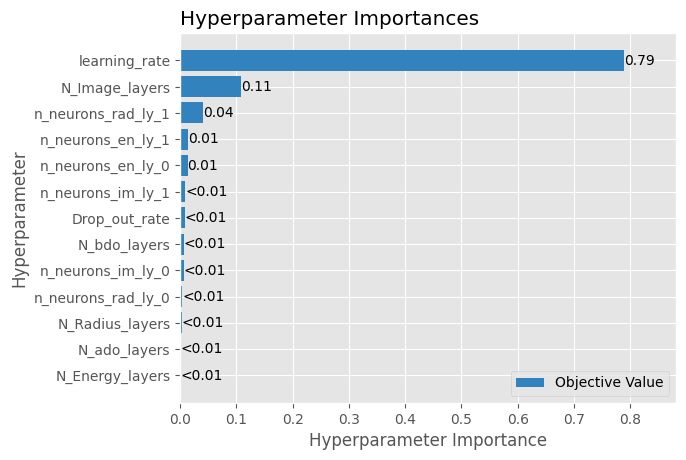

In [40]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.legend(loc = 'lower right')
#plt.savefig('figs/Optimized Models/10x10/Hyperparameter Importance.png', format = 'png', bbox_inches = 'tight')

In [12]:
best_model = create_OP_Model(best_trial)
history = best_model.fit(x = {'image_input': pixel_train, 'energy_input': energy_train, 'radius_input': radi_train},
                    y = {'nu_predict':label_train}, 
                    epochs = 100, 
                    batch_size = 100, 
                    validation_split = 0.3,
                    shuffle = True)

Epoch 1/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - AUC: 0.8035 - accuracy: 0.7470 - loss: 0.5308 - val_AUC: 0.6774 - val_accuracy: 0.5996 - val_loss: 0.7401
Epoch 2/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.9267 - accuracy: 0.8480 - loss: 0.3431 - val_AUC: 0.7442 - val_accuracy: 0.6410 - val_loss: 0.6641
Epoch 3/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.9445 - accuracy: 0.8701 - loss: 0.2997 - val_AUC: 0.7917 - val_accuracy: 0.6867 - val_loss: 0.6131
Epoch 4/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.9509 - accuracy: 0.8767 - loss: 0.2821 - val_AUC: 0.7695 - val_accuracy: 0.6561 - val_loss: 0.6452
Epoch 5/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.9571 - accuracy: 0.8877 - loss: 0.2642 - val_AUC: 0.8779 - val_accuracy: 0.7653 - val_loss: 0.4698
Epoch 6/100
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - AUC: 0.9623 - accuracy: 0.8936 - loss: 0.2478 - val_AUC: 0.8914 - val_accuracy: 0.7790 - val_loss: 0.4371
Epoch 7/100
1277/1277

## 3.2 - Train and Validation Progress

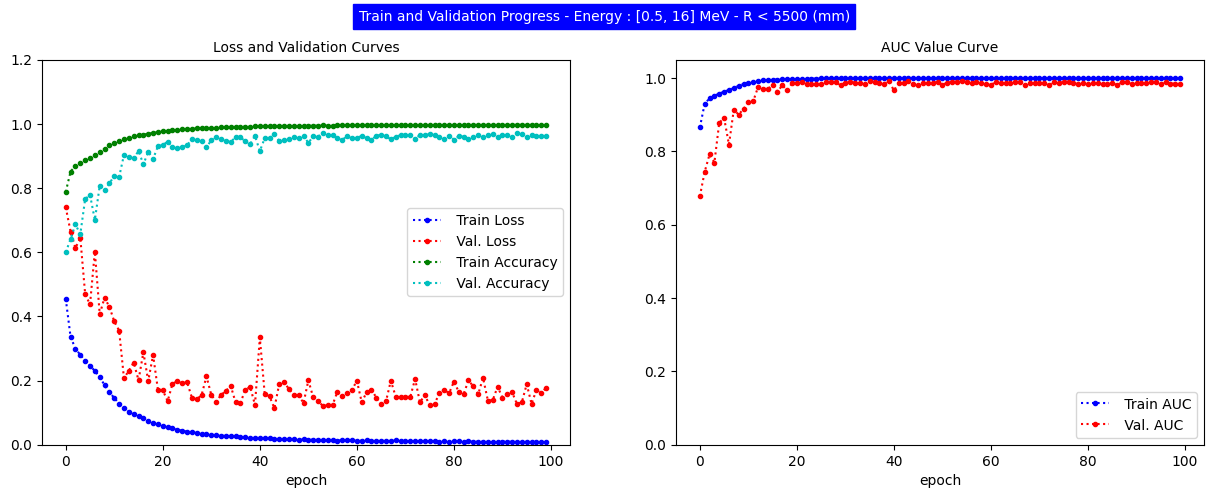

In [30]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))

axes[0].plot(history.history['loss'], 'b:.', label = ' Train Loss')
axes[0].plot(history.history['val_loss'], 'r:.', label = ' Val. Loss')
axes[0].plot(history.history['accuracy'], 'g:.',  label = ' Train Accuracy')
axes[0].plot(history.history['val_accuracy'], 'c:.', label = ' Val. Accuracy')
axes[1].plot(history.history['AUC'], 'b:.',  label = ' Train AUC')
axes[1].plot(history.history['val_AUC'], 'r:.', label = ' Val. AUC')

axes[0].set_title('Loss and Validation Curves', fontsize = 10)
axes[0].set_xlabel('epoch')
axes[0].legend(loc = 'best')
axes[1].set_title('AUC Value Curve', fontsize = 10)
axes[1].set_xlabel('epoch')
axes[1].legend(loc = 'lower right')

axes[0].set_ylim(0, 1.2)
axes[1].set_ylim(0, 1.05)

fig.suptitle('Train and Validation Progress - Energy : [0.5, 16] MeV - R < 5500 (mm)', backgroundcolor='blue', color='white', fontsize = 10)
#plt.savefig('figs/Optimized Models/10x10/Train_Val_progress.png', format = 'png', bbox_inches = 'tight')

# *Save/Load Model

# 4 - Observation and Analysis of Predictions

### 4.1.1 - NN Prediction

In [14]:
X_sig_pred = best_model.predict([pixel_sig_test_std, energy_sig_test_std, radi_sig_test_std])
X_bkg_pred = best_model.predict([pixel_bkg_test_std, energy_bkg_test_std, radi_bkg_test_std])

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


### 4.1.2 - Analysis of Predictions

In [15]:
X_sig_pred

array([[1.0000000e+00, 1.0026209e-10],
       [1.0000000e+00, 6.8544484e-12],
       [9.9990898e-01, 1.4615941e-04],
       ...,
       [1.0000000e+00, 9.7604598e-11],
       [1.0000000e+00, 2.9760006e-22],
       [1.0000000e+00, 1.4618364e-20]], dtype=float32)

In [16]:
X_bkg_pred

array([[2.1807876e-04, 9.9982375e-01],
       [4.8393991e-07, 9.9999970e-01],
       [2.2875385e-08, 9.9999994e-01],
       ...,
       [7.3739694e-21, 1.0000000e+00],
       [3.0866657e-05, 9.9997503e-01],
       [4.2350371e-06, 9.9999690e-01]], dtype=float32)

In [17]:
print('working with ' + str(len(X_sig_pred)) + ' of signal and ' + str(len(X_bkg_pred)) + ' of background as testing data')

working with 22796 of signal and 22796 of background as testing data


### 4.1.3 - Representation of Predictions

#### Distribution of Probabilities

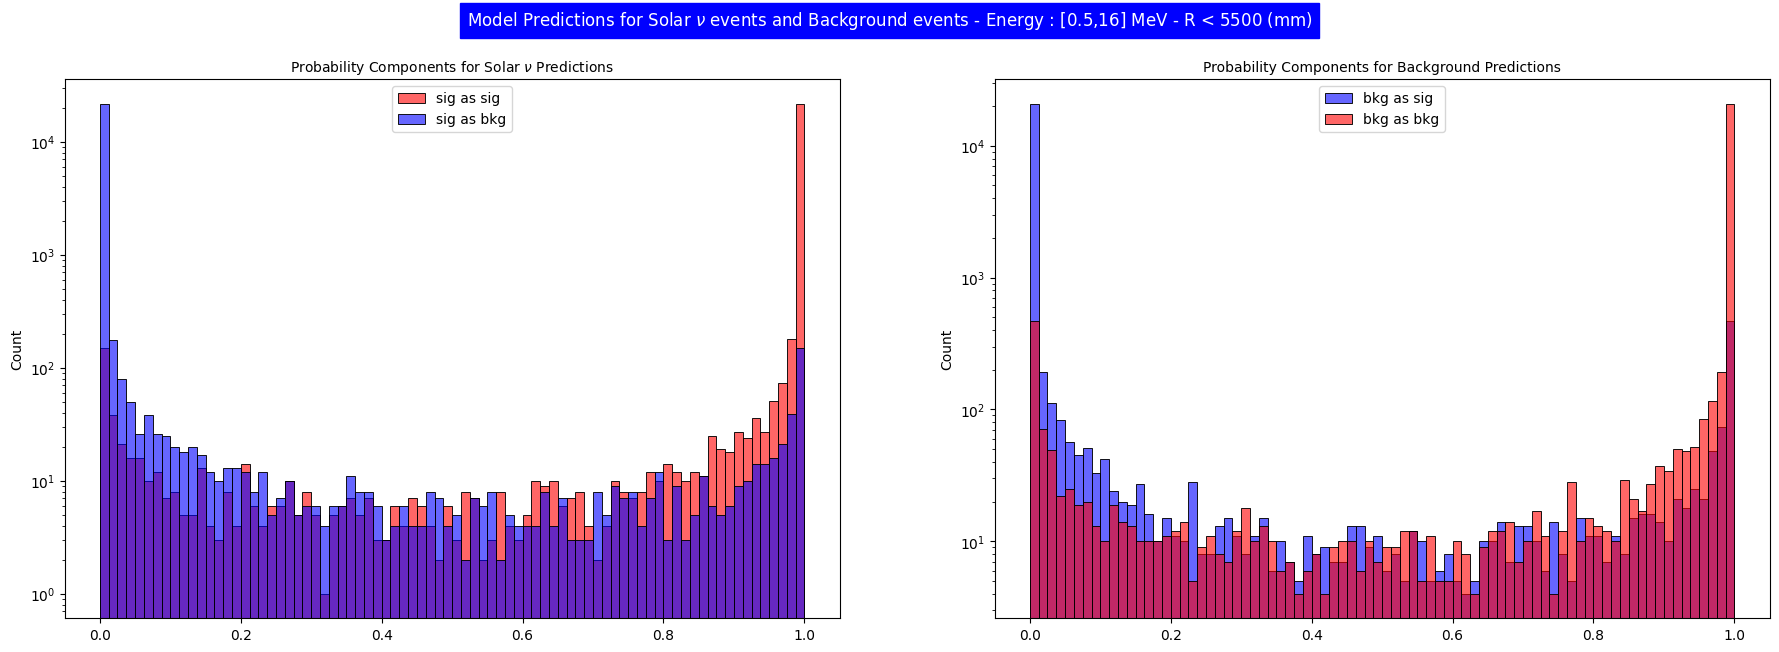

In [31]:
sn.reset_orig
bins = 80
fig, axes = plt.subplots(1, 2,  figsize=(22, 7))

sn.histplot(X_sig_pred[:,0], bins = bins, label = 'sig as sig', color = 'r', alpha = 0.6, ax = axes[0], log = True)
sn.histplot(X_sig_pred[:,1], bins = bins, label = 'sig as bkg', color = 'b', alpha = 0.6, ax = axes[0])
sn.histplot(X_bkg_pred[:,0], bins = bins, label = 'bkg as sig',color = 'b', alpha = 0.6, ax = axes[1], log = True)
sn.histplot(X_bkg_pred[:,1], bins = bins, label = 'bkg as bkg', color = 'r', alpha = 0.6, ax = axes[1])
axes[0].set_title('Probability Components for Solar $ν$ Predictions', fontsize = 10)
axes[1].set_title('Probability Components for Background Predictions', fontsize = 10)
axes[0].legend(loc = 'best')
axes[1].legend(loc = 'best')
plt.suptitle('Model Predictions for Solar $ν$ events and Background events - Energy : [0.5,16] MeV - R < 5500 (mm)', backgroundcolor='blue', color='white')
#plt.savefig('figs/Optimized Models/10x10/probability_predictions1.png', format = 'png', bbox_inches = 'tight')

### 4.1.4 - ROC Curve

In [19]:
X_pred = np.concatenate((X_sig_pred, X_bkg_pred))        #Predicted
X_exp = np.concatenate((label_sig_test, label_bkg_test)) #Expected

# Classification for solar_nu events
fpr_sig, tpr_sig, thresholds_sig = roc_curve(X_exp[:,0], X_pred[:,0])
auc_sig = auc(fpr_sig, tpr_sig)

# Classification for bkg events
fpr_bkg, tpr_bkg, thresholds_bkg = roc_curve(X_exp[:,1], X_pred[:,1])
auc_bkg = auc(fpr_bkg, tpr_bkg)

# Classification overall Model

fpr, tpr, thresholds = roc_curve(np.concatenate((X_exp[:,0], X_exp[:,1])), np.concatenate((X_pred[:,0], X_pred[:,1])))
auc_val = auc(fpr, tpr)

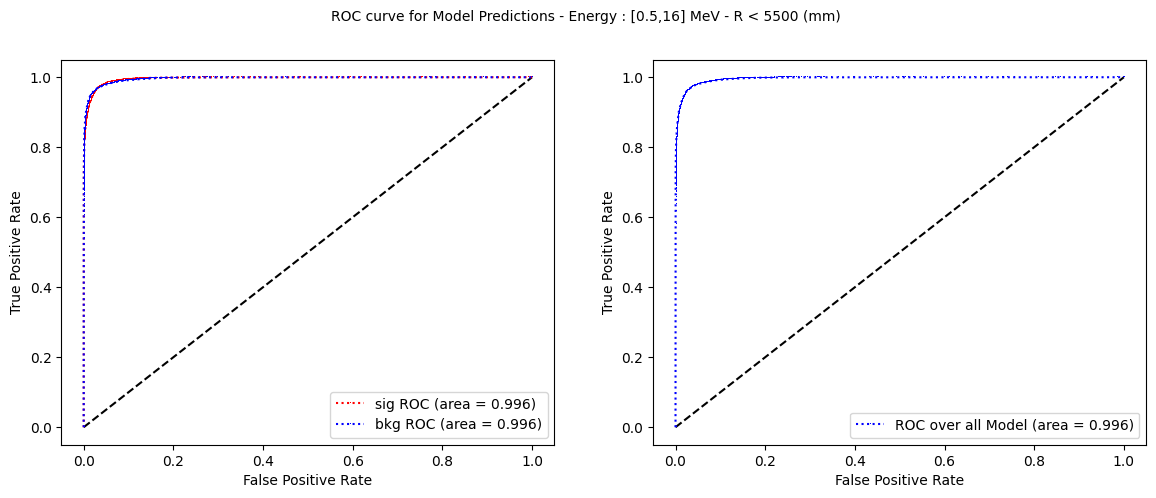

In [32]:
fig, axes = plt.subplots(1, 2,  figsize=(14, 5))


axes[0].plot([0, 1], [0, 1], 'k--') #x=y
axes[0].plot(fpr_sig, tpr_sig, 'r:,', label = 'sig ROC (area = {:.3f})'.format(auc_sig))
axes[0].plot(fpr_bkg, tpr_bkg, 'b:,', label = 'bkg ROC (area = {:.3f})'.format(auc_bkg))

axes[1].plot([0, 1], [0, 1], 'k--') #x=y
axes[1].plot(fpr, tpr, 'b:,', label = 'ROC over all Model (area = {:.3f})'.format(auc_val))

axes[0].set_ylabel('True Positive Rate')
axes[0].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlabel('False Positive Rate')

axes[0].legend(loc = 'lower right')
axes[1].legend(loc = 'lower right')

fig.suptitle('ROC curve for Model Predictions - Energy : [0.5,16] MeV - R < 5500 (mm)', fontsize = 10)

#plt.savefig('figs/Optimized Models/10x10/ROC.png', format = 'png', bbox_inches = 'tight')

### 4.1.5 - Reconstrucción de espector de solar $ν_e$ e de Tálio

Seran seleccionados unicamente energias de eventos de neutrinos solar con un predicción X_pred[:,0] > threshold para ver que tan bueno se reconstruye el espectro de neutrinos solares. Los mismo para eventos de Tálio. Asi, podra ser observado en que energias el modelo tiene mas dificultades en acertar predicciones

#### Recuperar Valores de Energia y Radio (Inverse Standard Scaler)

In [21]:
energy_sig_rc = scaler_en_sig.inverse_transform([energy_sig_test_std])[0]
energy_bkg_rc = scaler_en_bkg.inverse_transform([energy_bkg_test_std])[0]

radi_sig_rc = scaler_rad_sig.inverse_transform([radi_sig_test_std])[0]
radi_bkg_rc = scaler_rad_bkg.inverse_transform([radi_bkg_test_std])[0]

In [22]:
threshold_p = 0.9  #definition of probability treshold to pick valid predictions (90% of solar nu)

nu_energy_in_spectrum = []
nu_energy_out_spectrum = []

tl_energy_in_spectrum = []
tl_energy_out_spectrum = []

for i in np.where(X_sig_pred[:,0] >= threshold_p)[0]:
    nu_energy_in_spectrum.append(energy_sig_rc[i])
    
for j in np.where(X_sig_pred[:,0] < threshold_p)[0]:
    nu_energy_out_spectrum.append(energy_sig_rc[j])

for m in np.where(X_bkg_pred[:,1] >= threshold_p)[0]:
    tl_energy_in_spectrum.append(energy_bkg_rc[m])

for k in np.where(X_bkg_pred[:,1] < threshold_p)[0]:
    tl_energy_out_spectrum.append(energy_bkg_rc[k])
    
nu_energy_in_spectrum = np.array(nu_energy_in_spectrum)
nu_energy_out_spectrum = np.array(nu_energy_out_spectrum)
tl_energy_in_spectrum = np.array(tl_energy_in_spectrum)
tl_energy_out_spectrum = np.array(tl_energy_out_spectrum)

<>:9: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
C:\Users\joanc\AppData\Local\Temp\ipykernel_16892\410144179.py:9: SyntaxWarning: invalid escape sequence '\g'
  sn.histplot(tl_energy_in_spectrum, binwidth = binwidth_tl_en, color = 'b', label = 'Energy for $P(Tl) \geq$ trh',
C:\Users\joanc\AppData\Local\Temp\ipykernel_16892\410144179.py:14: SyntaxWarning: invalid escape sequence '\g'
  sn.histplot(nu_energy_in_spectrum, binwidth = binwidth_nu_en, color = 'r', label = 'Energy for $P(ν_e) \geq$ trh',


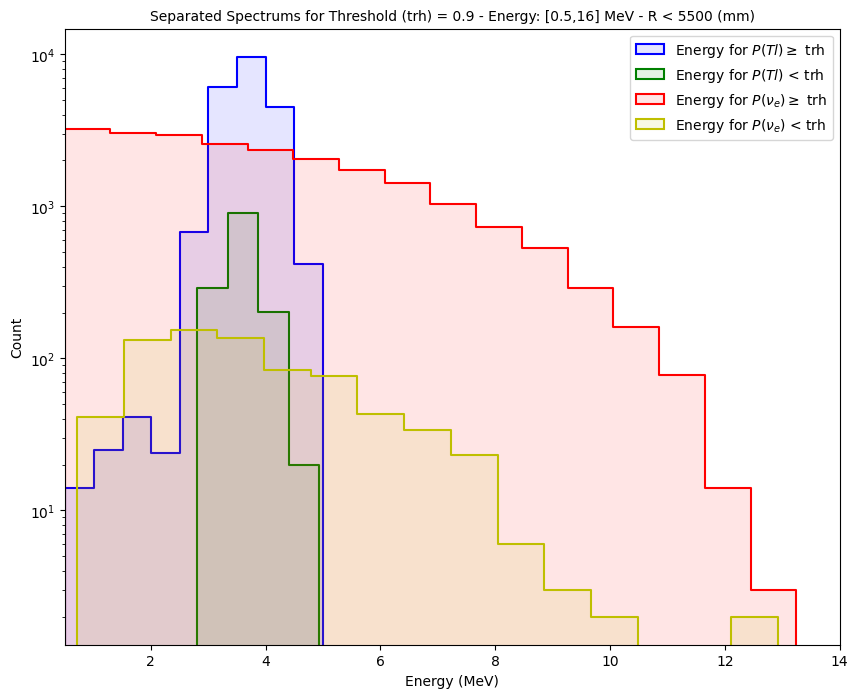

In [33]:
binwidth_nu_en = 0.8
binwidth_tl_en = 0.5
alpha_en_in = 0.1
alpha_en_out = 0.1
linewidth_en = 1.5

plt.figure(figsize =(10, 8))

sn.histplot(tl_energy_in_spectrum, binwidth = binwidth_tl_en, color = 'b', label = 'Energy for $P(Tl) \geq$ trh', 
            alpha = alpha_en_in, linewidth = linewidth_en, element = 'step', kde = False)
sn.histplot(tl_energy_out_spectrum, binwidth = binwidth_tl_en, color = 'g', label = 'Energy for $P(Tl)$ < trh', 
            alpha = alpha_en_out, linewidth = linewidth_en, element = 'step', kde = False)

sn.histplot(nu_energy_in_spectrum, binwidth = binwidth_nu_en, color = 'r', label = 'Energy for $P(ν_e) \geq$ trh', 
            alpha = alpha_en_in, linewidth = linewidth_en, element = 'step', kde = False)
sn.histplot(nu_energy_out_spectrum, binwidth = binwidth_nu_en, color = 'y', label = 'Energy for $P(ν_e)$ < trh', 
            alpha = alpha_en_out, linewidth = linewidth_en, element = 'step', kde = False)

#sn.histplot(energy_sig, bins = 20, color = 'r', label = 'All Solar $ν_e$ Spectrum', alpha = 0, linewidth = linewidth_en, element = 'step', kde = False)
plt.xlabel('Energy (MeV)')
plt.legend(loc = 'best')
plt.title('Separated Spectrums for Threshold (trh) = ' + str(threshold_p) + ' - Energy: [0.5,16] MeV - R < 5500 (mm)', fontsize = 10)
plt.yscale('log')
plt.xlim(0.5, 14)
#plt.savefig('figs/Optimized Models/10x10/effic_in_energy_pred_th.png', format = 'png', bbox_inches = 'tight')

### 4.1.6 - Efficience curve of predictions

Representar curva de eficiencia de las prediciones del modelo (sig=X_pred[:0], bkg=X_pred[:1]) en función de la energia y el radio del evento

In [27]:
#Efficiencia = Prob. de estar correcta la prediccion
X_sig_eff = X_sig_pred[:,0]
X_bkg_eff = X_bkg_pred[:,1]

x = np.concatenate((energy_sig_rc, energy_bkg_rc))
y = np.concatenate((radi_sig_rc, radi_bkg_rc))
z = np.concatenate((X_sig_eff, X_bkg_eff))

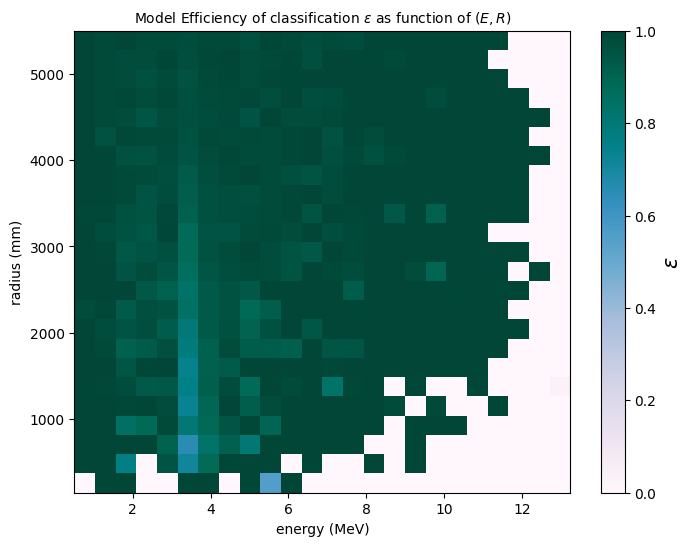

In [34]:
bins = 25

# Definir los límites y número de bins
x_edges = np.linspace(x.min(), x.max(), bins)
y_edges = np.linspace(y.min(), y.max(), bins)

# Inicializar una matriz para almacenar los valores de z
hist = np.zeros((len(x_edges)-1, len(y_edges)-1))

# Calcular los valores de z en cada bin
for i in range(len(x_edges)-1):
    for j in range(len(y_edges)-1):
        mask = (x >= x_edges[i]) & (x < x_edges[i+1]) & (y >= y_edges[j]) & (y < y_edges[j+1])
        if np.sum(mask) > 0:
            hist[i, j] = np.mean(z[mask])  # Otras estadísticas podrían ser np.sum, np.median, etc.

# Crear el plot
fig, ax = plt.subplots(figsize=(8,6))
c = ax.pcolormesh(x_edges, y_edges, hist.T, shading='auto', cmap = cm.PuBuGn)
cbar = fig.colorbar(c, ax=ax)

# Agregar un título a la barra de color
cbar.set_label('$ε$', fontsize = 15)

ax.set_xlabel('energy (MeV)')
ax.set_ylabel('radius (mm)')
ax.set_title('Model Efficiency of classification $ε$ as function of $(E,R)$', fontsize = 10)
#plt.xlim(0.5,16)
#plt.ylim(0,5500)
#plt.savefig('figs/Optimized Models/10x10/Eff_of_clasification(E,R).png', format = 'png', bbox_inches = 'tight')